In [1]:
# installs the tutorial package
!pip install m3_learning


In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
from m3_learning.viz.nn import embeddings, latent_generator
from m3_learning.nn.random import random_seed
from m3_learning.viz.style import set_style
from m3_learning.nn.time_series_nn.nn_util import Train, transform_nn, loss_function
from m3_learning.viz.layout import layout_fig, embedding_maps
from m3_learning.util.data_generators import generate_data
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import copy
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import torch
from tqdm import tqdm
import os
from torchsummary import summary

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

set_style("printing")
random_seed(seed=42)

%matplotlib inline


printing set for seaborn
Pytorch seed was set to 42
Numpy seed was set to 42


tensorflow seed was set to 42


In [4]:
# Loads dog image
image = io.imread(
    "https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/nala.jpg?raw=true"
)

# Crops dog image
image = image[200:1900:20, 100:1500:20] / 255


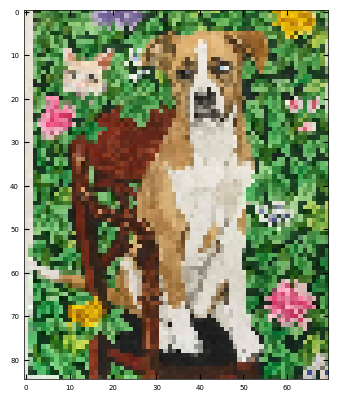

In [5]:
plt.imshow(image)


In [6]:
def non_linear_fn(t, x, y, z):
    tanh = nn.Tanh()
    selu = nn.SELU()
    sigmoid = nn.Sigmoid()

    # returns a function from variables
    return (
        tanh(torch.tensor(20 * (t - 2 * (x - 0.5))))
        + selu(torch.tensor((t - 2 * (y - 0.5))))
        + sigmoid(torch.tensor(-20 * (t - (z - 0.5))))
    )


In [7]:
# generates a hyperspectral image
dog_data = generate_data(image.reshape(-1, 3),
                         length=10, function=non_linear_fn)


In [8]:
# Conducts a test train split.
# because we are training an autoencoder x and y are the same
X_train, X_test, _, _ = train_test_split(
    dog_data, dog_data, test_size=0.2, random_state=42
)


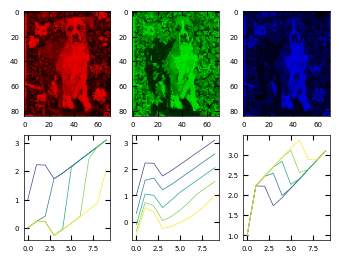

In [9]:
fig, ax = layout_fig(6, mod=3, figsize=(5, 2.5))

ax = ax.ravel()

cmap = plt.cm.viridis

for i, ax in enumerate(ax):
    if i < 3:
        # imagemap(ax, image[:, :, i],divider_=False, clim = (0,1))
        img = np.zeros(image.shape)
        img[:, :, i] = image[:, :, i]
        ax.imshow(img)
    else:
        values = np.zeros((5, 3))
        values[:, i - 3] = np.linspace(0, 1, 5)
        y_data = generate_data(values, length=10)
        for j in range(y_data.shape[0]):
            color = cmap((j + 1) / y_data.shape[0])
            ax.plot(y_data[j], c=color)


In [10]:
latent_dim = 12


class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.dense_1 = nn.Linear(10, self.latent_dim)

    def forward(self, x):
        # single dense layer in the model
        x = self.dense_1(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.dense_1 = nn.Linear(self.latent_dim, 10)

    def forward(self, x):
        # single dense layer in the decoder
        x = self.dense_1(x)
        return x


In [11]:
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        # encode
        embedding = self.encoder(x)
        # decode
        predicted = self.decoder(embedding)

        return predicted


In [12]:
import cpuinfo

cpudata = cpuinfo.get_cpu_info()["brand_raw"]
cpuname = cpudata.split(" ")[1]

if cpuname == "M1":
    device = "mps"
elif torch.cuda.device_count():
    device = "cuda"
else:
    device = "cpu"

print(f"You are running on a {device}")

encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)


You are running on a cuda


In [13]:
try:
    summary(model, ((X_train.shape[1:])))
except:
    model_cpu = copy.deepcopy(model).to("cpu")
    summary(model_cpu, ((X_train.shape[1:])))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 12]             132
           Encoder-2                   [-1, 12]               0
            Linear-3                   [-1, 10]             130
           Decoder-4                   [-1, 10]               0
Total params: 262
Trainable params: 262
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [14]:
train_iterator = torch.utils.data.DataLoader(
    X_train, batch_size=256, shuffle=True)


In [15]:
random_seed(seed=42)
Train(model, encoder, decoder, train_iterator, optimizer, 500, device=device)


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 602.16it/s]

Epoch 0, Train Loss: 2.0557
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 682.32it/s]

Epoch 1, Train Loss: 1.8709
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.35it/s]

Epoch 2, Train Loss: 1.7014
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.64it/s]

Epoch 3, Train Loss: 1.5465
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.89it/s]

Epoch 4, Train Loss: 1.3983
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.70it/s]

Epoch 5, Train Loss: 1.2586
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.80it/s]

Epoch 6, Train Loss: 1.1299
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 683.13it/s]

Epoch 7, Train Loss: 1.0058
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.42it/s]

Epoch 8, Train Loss: 0.8919
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 599.12it/s]

Epoch 9, Train Loss: 0.7870
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.07it/s]

Epoch 10, Train Loss: 0.6910
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 684.45it/s]

Epoch 11, Train Loss: 0.6044
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.21it/s]

Epoch 12, Train Loss: 0.5278
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.03it/s]

Epoch 13, Train Loss: 0.4611
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.46it/s]

Epoch 14, Train Loss: 0.4038
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.61it/s]

Epoch 15, Train Loss: 0.3553
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 694.17it/s]

Epoch 16, Train Loss: 0.3155
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.32it/s]

Epoch 17, Train Loss: 0.2828
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 694.35it/s]

Epoch 18, Train Loss: 0.2565
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.85it/s]

Epoch 19, Train Loss: 0.2355
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 692.65it/s]

Epoch 20, Train Loss: 0.2191
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 692.67it/s]

Epoch 21, Train Loss: 0.2055
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 693.80it/s]

Epoch 22, Train Loss: 0.1945
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.15it/s]

Epoch 23, Train Loss: 0.1857
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.08it/s]

Epoch 24, Train Loss: 0.1780
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.46it/s]

Epoch 25, Train Loss: 0.1714
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.26it/s]

Epoch 26, Train Loss: 0.1664
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.65it/s]

Epoch 27, Train Loss: 0.1614
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 679.26it/s]

Epoch 28, Train Loss: 0.1573
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.44it/s]

Epoch 29, Train Loss: 0.1535
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.76it/s]

Epoch 30, Train Loss: 0.1501
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 606.37it/s]

Epoch 31, Train Loss: 0.1467
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.10it/s]

Epoch 32, Train Loss: 0.1440
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.70it/s]

Epoch 33, Train Loss: 0.1412
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.35it/s]

Epoch 34, Train Loss: 0.1385
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 684.44it/s]

Epoch 35, Train Loss: 0.1361
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.00it/s]

Epoch 36, Train Loss: 0.1338
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.06it/s]

Epoch 37, Train Loss: 0.1314
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 683.78it/s]

Epoch 38, Train Loss: 0.1291
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.35it/s]

Epoch 39, Train Loss: 0.1268
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.01it/s]

Epoch 40, Train Loss: 0.1245
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.51it/s]

Epoch 41, Train Loss: 0.1225
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.42it/s]

Epoch 42, Train Loss: 0.1204
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 684.20it/s]

Epoch 43, Train Loss: 0.1181
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 680.79it/s]

Epoch 44, Train Loss: 0.1161
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.91it/s]

Epoch 45, Train Loss: 0.1140
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.13it/s]

Epoch 46, Train Loss: 0.1121
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.44it/s]

Epoch 47, Train Loss: 0.1099
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 684.06it/s]

Epoch 48, Train Loss: 0.1081
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.05it/s]

Epoch 49, Train Loss: 0.1062
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.55it/s]

Epoch 50, Train Loss: 0.1044
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.90it/s]

Epoch 51, Train Loss: 0.1024
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.45it/s]

Epoch 52, Train Loss: 0.1005
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 684.79it/s]

Epoch 53, Train Loss: 0.0986
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.84it/s]

Epoch 54, Train Loss: 0.0969
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.79it/s]

Epoch 55, Train Loss: 0.0949
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 683.33it/s]

Epoch 56, Train Loss: 0.0933
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.70it/s]

Epoch 57, Train Loss: 0.0914
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.82it/s]

Epoch 58, Train Loss: 0.0897
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.37it/s]

Epoch 59, Train Loss: 0.0880
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.58it/s]

Epoch 60, Train Loss: 0.0863
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.57it/s]

Epoch 61, Train Loss: 0.0847
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.06it/s]

Epoch 62, Train Loss: 0.0831
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.33it/s]

Epoch 63, Train Loss: 0.0816
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.76it/s]

Epoch 64, Train Loss: 0.0801
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 684.90it/s]

Epoch 65, Train Loss: 0.0784
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.84it/s]

Epoch 66, Train Loss: 0.0771
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.35it/s]

Epoch 67, Train Loss: 0.0755
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.35it/s]

Epoch 68, Train Loss: 0.0743
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 682.35it/s]

Epoch 69, Train Loss: 0.0727
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.64it/s]

Epoch 70, Train Loss: 0.0713
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.90it/s]

Epoch 71, Train Loss: 0.0701
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.07it/s]

Epoch 72, Train Loss: 0.0689
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.94it/s]

Epoch 73, Train Loss: 0.0676
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.17it/s]

Epoch 74, Train Loss: 0.0664
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.69it/s]

Epoch 75, Train Loss: 0.0651
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.22it/s]

Epoch 76, Train Loss: 0.0639
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 694.62it/s]

Epoch 77, Train Loss: 0.0628
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.15it/s]

Epoch 78, Train Loss: 0.0618
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 682.40it/s]

Epoch 79, Train Loss: 0.0607
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.89it/s]

Epoch 80, Train Loss: 0.0597
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.30it/s]

Epoch 81, Train Loss: 0.0586
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.24it/s]

Epoch 82, Train Loss: 0.0577
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 682.85it/s]

Epoch 83, Train Loss: 0.0568
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.49it/s]

Epoch 84, Train Loss: 0.0558
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.31it/s]

Epoch 85, Train Loss: 0.0549
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 692.29it/s]

Epoch 86, Train Loss: 0.0539
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.95it/s]

Epoch 87, Train Loss: 0.0531
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.12it/s]

Epoch 88, Train Loss: 0.0524
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 684.23it/s]

Epoch 89, Train Loss: 0.0515
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.05it/s]

Epoch 90, Train Loss: 0.0507
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.57it/s]

Epoch 91, Train Loss: 0.0500
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 683.67it/s]

Epoch 92, Train Loss: 0.0492
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 681.85it/s]

Epoch 93, Train Loss: 0.0484
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.27it/s]

Epoch 94, Train Loss: 0.0477
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.02it/s]

Epoch 95, Train Loss: 0.0470
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 682.58it/s]

Epoch 96, Train Loss: 0.0463
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.58it/s]

Epoch 97, Train Loss: 0.0457
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.24it/s]

Epoch 98, Train Loss: 0.0451
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 683.58it/s]

Epoch 99, Train Loss: 0.0445
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.56it/s]

Epoch 100, Train Loss: 0.0437
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 683.66it/s]

Epoch 101, Train Loss: 0.0431
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.07it/s]

Epoch 102, Train Loss: 0.0425
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.47it/s]

Epoch 103, Train Loss: 0.0420
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 683.18it/s]

Epoch 104, Train Loss: 0.0415
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.21it/s]

Epoch 105, Train Loss: 0.0409
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.16it/s]

Epoch 106, Train Loss: 0.0403
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.51it/s]

Epoch 107, Train Loss: 0.0397
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 692.40it/s]

Epoch 108, Train Loss: 0.0392
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.73it/s]

Epoch 109, Train Loss: 0.0388
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 684.50it/s]

Epoch 110, Train Loss: 0.0382
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 694.83it/s]

Epoch 111, Train Loss: 0.0378
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.16it/s]

Epoch 112, Train Loss: 0.0373
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 684.85it/s]

Epoch 113, Train Loss: 0.0369
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.77it/s]

Epoch 114, Train Loss: 0.0365
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.13it/s]

Epoch 115, Train Loss: 0.0359
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.32it/s]

Epoch 116, Train Loss: 0.0354
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.59it/s]

Epoch 117, Train Loss: 0.0350
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.46it/s]

Epoch 118, Train Loss: 0.0346
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.57it/s]

Epoch 119, Train Loss: 0.0341
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.06it/s]

Epoch 120, Train Loss: 0.0338
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.98it/s]

Epoch 121, Train Loss: 0.0333
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.53it/s]

Epoch 122, Train Loss: 0.0330
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.88it/s]

Epoch 123, Train Loss: 0.0326
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.72it/s]

Epoch 124, Train Loss: 0.0321
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.35it/s]

Epoch 125, Train Loss: 0.0318
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.79it/s]

Epoch 126, Train Loss: 0.0314
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.72it/s]

Epoch 127, Train Loss: 0.0311
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.64it/s]

Epoch 128, Train Loss: 0.0307
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.01it/s]

Epoch 129, Train Loss: 0.0304
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.96it/s]

Epoch 130, Train Loss: 0.0300
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.37it/s]

Epoch 131, Train Loss: 0.0297
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.18it/s]

Epoch 132, Train Loss: 0.0294
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.67it/s]

Epoch 133, Train Loss: 0.0290
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.06it/s]

Epoch 134, Train Loss: 0.0287
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.96it/s]

Epoch 135, Train Loss: 0.0283
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.38it/s]

Epoch 136, Train Loss: 0.0280
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 693.61it/s]

Epoch 137, Train Loss: 0.0278
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.21it/s]

Epoch 138, Train Loss: 0.0274
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.53it/s]

Epoch 139, Train Loss: 0.0271
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.53it/s]

Epoch 140, Train Loss: 0.0268
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.88it/s]

Epoch 141, Train Loss: 0.0266
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.29it/s]

Epoch 142, Train Loss: 0.0262
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.29it/s]

Epoch 143, Train Loss: 0.0259
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.10it/s]

Epoch 144, Train Loss: 0.0257
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.42it/s]

Epoch 145, Train Loss: 0.0254
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.34it/s]

Epoch 146, Train Loss: 0.0252
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.60it/s]

Epoch 147, Train Loss: 0.0250
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 682.23it/s]

Epoch 148, Train Loss: 0.0246
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.61it/s]

Epoch 149, Train Loss: 0.0245
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.82it/s]

Epoch 150, Train Loss: 0.0242
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.94it/s]

Epoch 151, Train Loss: 0.0239
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.51it/s]

Epoch 152, Train Loss: 0.0237
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.14it/s]

Epoch 153, Train Loss: 0.0234
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.82it/s]

Epoch 154, Train Loss: 0.0232
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.83it/s]

Epoch 155, Train Loss: 0.0230
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.50it/s]

Epoch 156, Train Loss: 0.0227
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.86it/s]

Epoch 157, Train Loss: 0.0225
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.51it/s]

Epoch 158, Train Loss: 0.0224
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 693.27it/s]

Epoch 159, Train Loss: 0.0220
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.02it/s]

Epoch 160, Train Loss: 0.0218
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.19it/s]

Epoch 161, Train Loss: 0.0217
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.57it/s]

Epoch 162, Train Loss: 0.0215
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.90it/s]

Epoch 163, Train Loss: 0.0212
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.63it/s]

Epoch 164, Train Loss: 0.0211
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.36it/s]

Epoch 165, Train Loss: 0.0208
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.87it/s]

Epoch 166, Train Loss: 0.0207
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.61it/s]

Epoch 167, Train Loss: 0.0204
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 692.59it/s]

Epoch 168, Train Loss: 0.0202
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 692.66it/s]

Epoch 169, Train Loss: 0.0201
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.79it/s]

Epoch 170, Train Loss: 0.0199
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.66it/s]

Epoch 171, Train Loss: 0.0197
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.83it/s]

Epoch 172, Train Loss: 0.0195
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.33it/s]

Epoch 173, Train Loss: 0.0193
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.97it/s]

Epoch 174, Train Loss: 0.0192
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.80it/s]

Epoch 175, Train Loss: 0.0190
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.43it/s]

Epoch 176, Train Loss: 0.0187
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.26it/s]

Epoch 177, Train Loss: 0.0187
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.43it/s]

Epoch 178, Train Loss: 0.0185
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.64it/s]

Epoch 179, Train Loss: 0.0182
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.89it/s]

Epoch 180, Train Loss: 0.0181
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.63it/s]

Epoch 181, Train Loss: 0.0179
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.83it/s]

Epoch 182, Train Loss: 0.0178
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.20it/s]

Epoch 183, Train Loss: 0.0176
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.71it/s]

Epoch 184, Train Loss: 0.0174
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.80it/s]

Epoch 185, Train Loss: 0.0173
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.85it/s]

Epoch 186, Train Loss: 0.0171
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.80it/s]

Epoch 187, Train Loss: 0.0169
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.00it/s]

Epoch 188, Train Loss: 0.0168
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.07it/s]

Epoch 189, Train Loss: 0.0166
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 694.25it/s]

Epoch 190, Train Loss: 0.0165
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 592.42it/s]

Epoch 191, Train Loss: 0.0164
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.55it/s]

Epoch 192, Train Loss: 0.0162
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.79it/s]

Epoch 193, Train Loss: 0.0161
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.60it/s]

Epoch 194, Train Loss: 0.0159
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.50it/s]

Epoch 195, Train Loss: 0.0158
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.16it/s]

Epoch 196, Train Loss: 0.0156
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 683.75it/s]

Epoch 197, Train Loss: 0.0155
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 683.51it/s]

Epoch 198, Train Loss: 0.0153
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.12it/s]

Epoch 199, Train Loss: 0.0152
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.94it/s]

Epoch 200, Train Loss: 0.0150
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.88it/s]

Epoch 201, Train Loss: 0.0148
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.97it/s]

Epoch 202, Train Loss: 0.0147
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.58it/s]

Epoch 203, Train Loss: 0.0145
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.61it/s]

Epoch 204, Train Loss: 0.0144
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.08it/s]

Epoch 205, Train Loss: 0.0143
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.45it/s]

Epoch 206, Train Loss: 0.0141
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 692.04it/s]

Epoch 207, Train Loss: 0.0139
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 680.86it/s]

Epoch 208, Train Loss: 0.0138
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.27it/s]

Epoch 209, Train Loss: 0.0136
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 694.97it/s]

Epoch 210, Train Loss: 0.0135
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.05it/s]

Epoch 211, Train Loss: 0.0134
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.04it/s]

Epoch 212, Train Loss: 0.0133
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 637.49it/s]

Epoch 213, Train Loss: 0.0131
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 695.17it/s]

Epoch 214, Train Loss: 0.0129
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 692.16it/s]

Epoch 215, Train Loss: 0.0128
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 669.21it/s]

Epoch 216, Train Loss: 0.0127
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 638.61it/s]

Epoch 217, Train Loss: 0.0125
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 629.01it/s]

Epoch 218, Train Loss: 0.0123
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.94it/s]

Epoch 219, Train Loss: 0.0122
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.53it/s]

Epoch 220, Train Loss: 0.0120
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.75it/s]

Epoch 221, Train Loss: 0.0119
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.44it/s]

Epoch 222, Train Loss: 0.0118
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.49it/s]

Epoch 223, Train Loss: 0.0116
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.37it/s]

Epoch 224, Train Loss: 0.0115
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 692.80it/s]

Epoch 225, Train Loss: 0.0114
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 695.71it/s]

Epoch 226, Train Loss: 0.0112
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.04it/s]

Epoch 227, Train Loss: 0.0110
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 692.19it/s]

Epoch 228, Train Loss: 0.0109
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.31it/s]

Epoch 229, Train Loss: 0.0108
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 694.79it/s]

Epoch 230, Train Loss: 0.0106
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 695.00it/s]

Epoch 231, Train Loss: 0.0105
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.48it/s]

Epoch 232, Train Loss: 0.0104
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.36it/s]

Epoch 233, Train Loss: 0.0102
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.01it/s]

Epoch 234, Train Loss: 0.0101
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 694.38it/s]

Epoch 235, Train Loss: 0.0099
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.68it/s]

Epoch 236, Train Loss: 0.0098
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.38it/s]

Epoch 237, Train Loss: 0.0096
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.46it/s]

Epoch 238, Train Loss: 0.0096
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.91it/s]

Epoch 239, Train Loss: 0.0094
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.79it/s]

Epoch 240, Train Loss: 0.0093
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.37it/s]

Epoch 241, Train Loss: 0.0092
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.40it/s]

Epoch 242, Train Loss: 0.0090
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.86it/s]

Epoch 243, Train Loss: 0.0088
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.10it/s]

Epoch 244, Train Loss: 0.0087
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.73it/s]

Epoch 245, Train Loss: 0.0086
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.20it/s]

Epoch 246, Train Loss: 0.0084
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.60it/s]

Epoch 247, Train Loss: 0.0083
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.96it/s]

Epoch 248, Train Loss: 0.0082
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.41it/s]

Epoch 249, Train Loss: 0.0080
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.58it/s]

Epoch 250, Train Loss: 0.0079
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.90it/s]

Epoch 251, Train Loss: 0.0078
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.03it/s]

Epoch 252, Train Loss: 0.0077
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.48it/s]

Epoch 253, Train Loss: 0.0075
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 692.29it/s]

Epoch 254, Train Loss: 0.0074
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 680.90it/s]

Epoch 255, Train Loss: 0.0073
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 692.78it/s]

Epoch 256, Train Loss: 0.0071
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 692.49it/s]

Epoch 257, Train Loss: 0.0070
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.13it/s]

Epoch 258, Train Loss: 0.0069
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 694.42it/s]

Epoch 259, Train Loss: 0.0067
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.37it/s]

Epoch 260, Train Loss: 0.0066
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.97it/s]

Epoch 261, Train Loss: 0.0065
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.47it/s]

Epoch 262, Train Loss: 0.0064
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.58it/s]

Epoch 263, Train Loss: 0.0062
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.18it/s]

Epoch 264, Train Loss: 0.0061
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.12it/s]

Epoch 265, Train Loss: 0.0060
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.49it/s]

Epoch 266, Train Loss: 0.0059
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 693.50it/s]

Epoch 267, Train Loss: 0.0057
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.82it/s]

Epoch 268, Train Loss: 0.0056
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.09it/s]

Epoch 269, Train Loss: 0.0055
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.44it/s]

Epoch 270, Train Loss: 0.0054
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.83it/s]

Epoch 271, Train Loss: 0.0052
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.21it/s]

Epoch 272, Train Loss: 0.0052
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.58it/s]

Epoch 273, Train Loss: 0.0050
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 695.30it/s]

Epoch 274, Train Loss: 0.0049
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.97it/s]

Epoch 275, Train Loss: 0.0048
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.17it/s]

Epoch 276, Train Loss: 0.0047
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.43it/s]

Epoch 277, Train Loss: 0.0046
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.26it/s]

Epoch 278, Train Loss: 0.0045
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.24it/s]

Epoch 279, Train Loss: 0.0043
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.02it/s]

Epoch 280, Train Loss: 0.0042
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 683.84it/s]

Epoch 281, Train Loss: 0.0041
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.66it/s]

Epoch 282, Train Loss: 0.0040
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.77it/s]

Epoch 283, Train Loss: 0.0039
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.20it/s]

Epoch 284, Train Loss: 0.0038
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.26it/s]

Epoch 285, Train Loss: 0.0037
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.43it/s]

Epoch 286, Train Loss: 0.0036
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.23it/s]

Epoch 287, Train Loss: 0.0035
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 681.36it/s]

Epoch 288, Train Loss: 0.0034
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.55it/s]

Epoch 289, Train Loss: 0.0033
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 696.70it/s]

Epoch 290, Train Loss: 0.0032
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.32it/s]

Epoch 291, Train Loss: 0.0031
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.48it/s]

Epoch 292, Train Loss: 0.0030
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 620.15it/s]

Epoch 293, Train Loss: 0.0029
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.32it/s]

Epoch 294, Train Loss: 0.0028
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.89it/s]

Epoch 295, Train Loss: 0.0027
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 622.88it/s]

Epoch 296, Train Loss: 0.0026
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.54it/s]

Epoch 297, Train Loss: 0.0025
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 684.51it/s]

Epoch 298, Train Loss: 0.0024
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.54it/s]

Epoch 299, Train Loss: 0.0023
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.18it/s]

Epoch 300, Train Loss: 0.0023
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.46it/s]

Epoch 301, Train Loss: 0.0022
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.38it/s]

Epoch 302, Train Loss: 0.0021
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.35it/s]

Epoch 303, Train Loss: 0.0020
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.40it/s]

Epoch 304, Train Loss: 0.0019
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.15it/s]

Epoch 305, Train Loss: 0.0019
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.27it/s]

Epoch 306, Train Loss: 0.0018
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.12it/s]

Epoch 307, Train Loss: 0.0017
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 631.79it/s]

Epoch 308, Train Loss: 0.0016
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.21it/s]

Epoch 309, Train Loss: 0.0016
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.45it/s]

Epoch 310, Train Loss: 0.0015
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.54it/s]

Epoch 311, Train Loss: 0.0014
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 588.90it/s]

Epoch 312, Train Loss: 0.0014
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.27it/s]

Epoch 313, Train Loss: 0.0013
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 683.90it/s]

Epoch 314, Train Loss: 0.0013
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.39it/s]

Epoch 315, Train Loss: 0.0012
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.57it/s]

Epoch 316, Train Loss: 0.0011
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.89it/s]

Epoch 317, Train Loss: 0.0011
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.95it/s]

Epoch 318, Train Loss: 0.0010
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.11it/s]

Epoch 319, Train Loss: 0.0010
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.65it/s]

Epoch 320, Train Loss: 0.0009
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.26it/s]

Epoch 321, Train Loss: 0.0009
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.89it/s]

Epoch 322, Train Loss: 0.0009
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.53it/s]

Epoch 323, Train Loss: 0.0008
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 693.67it/s]

Epoch 324, Train Loss: 0.0008
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.53it/s]

Epoch 325, Train Loss: 0.0007
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.14it/s]

Epoch 326, Train Loss: 0.0007
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.97it/s]

Epoch 327, Train Loss: 0.0007
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.87it/s]

Epoch 328, Train Loss: 0.0006
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 692.09it/s]

Epoch 329, Train Loss: 0.0006
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.01it/s]

Epoch 330, Train Loss: 0.0006
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.38it/s]

Epoch 331, Train Loss: 0.0005
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.59it/s]

Epoch 332, Train Loss: 0.0005
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.76it/s]

Epoch 333, Train Loss: 0.0005
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.89it/s]

Epoch 334, Train Loss: 0.0004
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.59it/s]

Epoch 335, Train Loss: 0.0004
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 684.72it/s]

Epoch 336, Train Loss: 0.0004
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 680.52it/s]

Epoch 337, Train Loss: 0.0004
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 683.09it/s]

Epoch 338, Train Loss: 0.0004
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.93it/s]

Epoch 339, Train Loss: 0.0003
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.22it/s]

Epoch 340, Train Loss: 0.0003
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 692.16it/s]

Epoch 341, Train Loss: 0.0003
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.65it/s]

Epoch 342, Train Loss: 0.0003
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.38it/s]

Epoch 343, Train Loss: 0.0003
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 694.03it/s]

Epoch 344, Train Loss: 0.0003
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 693.11it/s]

Epoch 345, Train Loss: 0.0002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 696.47it/s]

Epoch 346, Train Loss: 0.0002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.70it/s]

Epoch 347, Train Loss: 0.0002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.33it/s]

Epoch 348, Train Loss: 0.0002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 692.21it/s]

Epoch 349, Train Loss: 0.0002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.06it/s]

Epoch 350, Train Loss: 0.0002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 694.62it/s]

Epoch 351, Train Loss: 0.0002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.63it/s]

Epoch 352, Train Loss: 0.0002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 695.12it/s]

Epoch 353, Train Loss: 0.0002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 694.43it/s]

Epoch 354, Train Loss: 0.0002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 693.44it/s]

Epoch 355, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.35it/s]

Epoch 356, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.73it/s]

Epoch 357, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.94it/s]

Epoch 358, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.55it/s]

Epoch 359, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.99it/s]

Epoch 360, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.39it/s]

Epoch 361, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.81it/s]

Epoch 362, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.20it/s]

Epoch 363, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.34it/s]

Epoch 364, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.51it/s]

Epoch 365, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 694.88it/s]

Epoch 366, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.62it/s]

Epoch 367, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.51it/s]

Epoch 368, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.29it/s]

Epoch 369, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.50it/s]

Epoch 370, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.62it/s]

Epoch 371, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.16it/s]

Epoch 372, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.63it/s]

Epoch 373, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.70it/s]

Epoch 374, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.60it/s]

Epoch 375, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.29it/s]

Epoch 376, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.39it/s]

Epoch 377, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 683.03it/s]

Epoch 378, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.70it/s]

Epoch 379, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 692.43it/s]

Epoch 380, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.33it/s]

Epoch 381, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.68it/s]

Epoch 382, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 694.24it/s]

Epoch 383, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 692.11it/s]

Epoch 384, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.85it/s]

Epoch 385, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.20it/s]

Epoch 386, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 693.73it/s]

Epoch 387, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.10it/s]

Epoch 388, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 681.51it/s]

Epoch 389, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.24it/s]

Epoch 390, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 677.71it/s]

Epoch 391, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.79it/s]

Epoch 392, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 692.14it/s]

Epoch 393, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 599.52it/s]

Epoch 394, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.76it/s]

Epoch 395, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.18it/s]

Epoch 396, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.56it/s]

Epoch 397, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.08it/s]

Epoch 398, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.73it/s]

Epoch 399, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 628.53it/s]

Epoch 400, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 679.74it/s]

Epoch 401, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.31it/s]

Epoch 402, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.41it/s]

Epoch 403, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.44it/s]

Epoch 404, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 634.43it/s]

Epoch 405, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 621.63it/s]

Epoch 406, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 596.79it/s]

Epoch 407, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.03it/s]

Epoch 408, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.45it/s]

Epoch 409, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 628.73it/s]

Epoch 410, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 696.48it/s]

Epoch 411, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.29it/s]

Epoch 412, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.36it/s]

Epoch 413, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.95it/s]

Epoch 414, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 692.65it/s]

Epoch 415, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.15it/s]

Epoch 416, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 694.16it/s]

Epoch 417, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.84it/s]

Epoch 418, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 692.64it/s]

Epoch 419, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.47it/s]

Epoch 420, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.96it/s]

Epoch 421, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 692.76it/s]

Epoch 422, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.93it/s]

Epoch 423, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.50it/s]

Epoch 424, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.02it/s]

Epoch 425, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.87it/s]

Epoch 426, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.67it/s]

Epoch 427, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 683.54it/s]

Epoch 428, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.15it/s]

Epoch 429, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 692.82it/s]

Epoch 430, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 694.42it/s]

Epoch 431, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 695.21it/s]

Epoch 432, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.62it/s]

Epoch 433, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 692.65it/s]

Epoch 434, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 693.01it/s]

Epoch 435, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 693.59it/s]

Epoch 436, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 693.05it/s]

Epoch 437, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 693.35it/s]

Epoch 438, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 693.74it/s]

Epoch 439, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.59it/s]

Epoch 440, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 692.54it/s]

Epoch 441, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 693.83it/s]

Epoch 442, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 694.19it/s]

Epoch 443, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.65it/s]

Epoch 444, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 693.84it/s]

Epoch 445, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 627.47it/s]

Epoch 446, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.29it/s]

Epoch 447, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 694.49it/s]

Epoch 448, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 695.23it/s]

Epoch 449, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 697.00it/s]

Epoch 450, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.53it/s]

Epoch 451, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.39it/s]

Epoch 452, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.04it/s]

Epoch 453, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.09it/s]

Epoch 454, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.83it/s]

Epoch 455, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.10it/s]

Epoch 456, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.53it/s]

Epoch 457, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 693.18it/s]

Epoch 458, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 693.24it/s]

Epoch 459, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 694.30it/s]

Epoch 460, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.59it/s]

Epoch 461, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 694.92it/s]

Epoch 462, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.67it/s]

Epoch 463, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.19it/s]

Epoch 464, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.81it/s]

Epoch 465, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 679.74it/s]

Epoch 466, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.47it/s]

Epoch 467, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.07it/s]

Epoch 468, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 696.66it/s]

Epoch 469, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.86it/s]

Epoch 470, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.76it/s]

Epoch 471, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.53it/s]

Epoch 472, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.01it/s]

Epoch 473, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 684.74it/s]

Epoch 474, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 623.80it/s]

Epoch 475, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.36it/s]

Epoch 476, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.39it/s]

Epoch 477, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.03it/s]

Epoch 478, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 695.73it/s]

Epoch 479, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 695.33it/s]

Epoch 480, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 628.86it/s]

Epoch 481, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 696.49it/s]

Epoch 482, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 629.29it/s]

Epoch 483, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.17it/s]

Epoch 484, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 694.08it/s]

Epoch 485, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 636.27it/s]

Epoch 486, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 601.52it/s]

Epoch 487, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 684.90it/s]

Epoch 488, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.79it/s]

Epoch 489, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.83it/s]

Epoch 490, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.89it/s]

Epoch 491, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.68it/s]

Epoch 492, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 620.50it/s]

Epoch 493, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 696.84it/s]

Epoch 494, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 617.74it/s]

Epoch 495, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 622.15it/s]

Epoch 496, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.81it/s]

Epoch 497, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.97it/s]

Epoch 498, Train Loss: 0.0000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 609.42it/s]

Epoch 499, Train Loss: 0.0000
.............................


In [16]:
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)


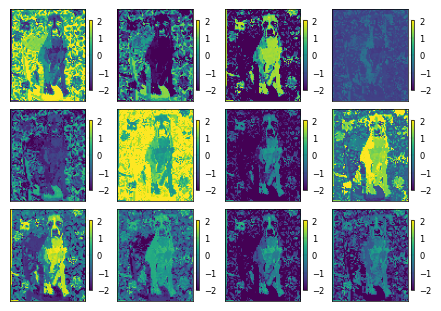

In [17]:
embeddings(encode, shape_=image.shape[0:2], figsize=(5, 3), clim=(-2, 2))


In [18]:
encoder = Encoder(latent_dim=3).to(device)
decoder = Decoder(latent_dim=3).to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)


In [19]:
summary(model, ((X_train.shape[1:])))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 3]              33
           Encoder-2                    [-1, 3]               0
            Linear-3                   [-1, 10]              40
           Decoder-4                   [-1, 10]               0
Total params: 73
Trainable params: 73
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [20]:
train_iterator = torch.utils.data.DataLoader(
    X_train, batch_size=256, shuffle=True)


In [21]:
random_seed(seed=42)
Train(model, encoder, decoder, train_iterator, optimizer, 500, device=device)


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 706.56it/s]

Epoch 0, Train Loss: 2.3594
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 733.40it/s]

Epoch 1, Train Loss: 2.3181
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 741.10it/s]

Epoch 2, Train Loss: 2.2805
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 747.78it/s]

Epoch 3, Train Loss: 2.2494
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 741.32it/s]

Epoch 4, Train Loss: 2.2163
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 740.35it/s]

Epoch 5, Train Loss: 2.1850
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 740.86it/s]

Epoch 6, Train Loss: 2.1561
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 738.88it/s]

Epoch 7, Train Loss: 2.1224
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 739.60it/s]

Epoch 8, Train Loss: 2.0912
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 739.47it/s]

Epoch 9, Train Loss: 2.0593
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 739.59it/s]

Epoch 10, Train Loss: 2.0236
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 739.17it/s]

Epoch 11, Train Loss: 1.9853
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 739.21it/s]

Epoch 12, Train Loss: 1.9495
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 739.83it/s]

Epoch 13, Train Loss: 1.9113
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 739.32it/s]

Epoch 14, Train Loss: 1.8703
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 734.79it/s]

Epoch 15, Train Loss: 1.8264
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 734.09it/s]

Epoch 16, Train Loss: 1.7808
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 740.91it/s]

Epoch 17, Train Loss: 1.7369
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 738.99it/s]

Epoch 18, Train Loss: 1.6876
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 737.59it/s]

Epoch 19, Train Loss: 1.6333
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 737.96it/s]

Epoch 20, Train Loss: 1.5798
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 742.45it/s]

Epoch 21, Train Loss: 1.5261
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 738.34it/s]

Epoch 22, Train Loss: 1.4660
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 736.55it/s]

Epoch 23, Train Loss: 1.4064
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 739.14it/s]

Epoch 24, Train Loss: 1.3457
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 739.73it/s]

Epoch 25, Train Loss: 1.2864
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 737.20it/s]

Epoch 26, Train Loss: 1.2266
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 740.51it/s]

Epoch 27, Train Loss: 1.1686
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 742.35it/s]

Epoch 28, Train Loss: 1.1097
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 743.48it/s]

Epoch 29, Train Loss: 1.0524
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 740.87it/s]

Epoch 30, Train Loss: 0.9975
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 738.82it/s]

Epoch 31, Train Loss: 0.9439
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 739.37it/s]

Epoch 32, Train Loss: 0.8917
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 740.00it/s]

Epoch 33, Train Loss: 0.8427
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 738.82it/s]

Epoch 34, Train Loss: 0.7950
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 738.50it/s]

Epoch 35, Train Loss: 0.7502
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 737.22it/s]

Epoch 36, Train Loss: 0.7077
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 737.66it/s]

Epoch 37, Train Loss: 0.6668
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 737.82it/s]

Epoch 38, Train Loss: 0.6293
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 738.02it/s]

Epoch 39, Train Loss: 0.5935
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 737.60it/s]

Epoch 40, Train Loss: 0.5598
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 736.70it/s]

Epoch 41, Train Loss: 0.5290
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 738.28it/s]

Epoch 42, Train Loss: 0.5001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 738.76it/s]

Epoch 43, Train Loss: 0.4723
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 738.47it/s]

Epoch 44, Train Loss: 0.4470
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 738.19it/s]

Epoch 45, Train Loss: 0.4242
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 737.34it/s]

Epoch 46, Train Loss: 0.4030
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 739.18it/s]

Epoch 47, Train Loss: 0.3825
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 737.37it/s]

Epoch 48, Train Loss: 0.3655
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 736.71it/s]

Epoch 49, Train Loss: 0.3486
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 735.25it/s]

Epoch 50, Train Loss: 0.3335
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 737.63it/s]

Epoch 51, Train Loss: 0.3193
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 738.41it/s]

Epoch 52, Train Loss: 0.3065
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 737.11it/s]

Epoch 53, Train Loss: 0.2943
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 739.85it/s]

Epoch 54, Train Loss: 0.2836
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 739.59it/s]

Epoch 55, Train Loss: 0.2732
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 741.58it/s]

Epoch 56, Train Loss: 0.2647
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 738.38it/s]

Epoch 57, Train Loss: 0.2565
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 738.95it/s]

Epoch 58, Train Loss: 0.2486
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 737.21it/s]

Epoch 59, Train Loss: 0.2418
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 738.96it/s]

Epoch 60, Train Loss: 0.2354
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 738.52it/s]

Epoch 61, Train Loss: 0.2295
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 739.18it/s]

Epoch 62, Train Loss: 0.2243
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 739.18it/s]

Epoch 63, Train Loss: 0.2194
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 739.20it/s]

Epoch 64, Train Loss: 0.2149
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 737.64it/s]

Epoch 65, Train Loss: 0.2106
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 738.15it/s]

Epoch 66, Train Loss: 0.2071
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 738.43it/s]

Epoch 67, Train Loss: 0.2032
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 737.91it/s]

Epoch 68, Train Loss: 0.2003
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 738.26it/s]

Epoch 69, Train Loss: 0.1968
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 736.66it/s]

Epoch 70, Train Loss: 0.1943
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 738.40it/s]

Epoch 71, Train Loss: 0.1916
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 738.95it/s]

Epoch 72, Train Loss: 0.1892
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 741.20it/s]

Epoch 73, Train Loss: 0.1871
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 738.41it/s]

Epoch 74, Train Loss: 0.1847
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 737.27it/s]

Epoch 75, Train Loss: 0.1827
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 738.30it/s]

Epoch 76, Train Loss: 0.1810
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 736.54it/s]

Epoch 77, Train Loss: 0.1790
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 736.82it/s]

Epoch 78, Train Loss: 0.1775
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 737.92it/s]

Epoch 79, Train Loss: 0.1761
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 737.31it/s]

Epoch 80, Train Loss: 0.1748
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 738.18it/s]

Epoch 81, Train Loss: 0.1733
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 736.22it/s]

Epoch 82, Train Loss: 0.1723
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 738.20it/s]

Epoch 83, Train Loss: 0.1712
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 737.13it/s]

Epoch 84, Train Loss: 0.1699
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 738.15it/s]

Epoch 85, Train Loss: 0.1690
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 736.96it/s]

Epoch 86, Train Loss: 0.1679
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 739.03it/s]

Epoch 87, Train Loss: 0.1672
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 738.63it/s]

Epoch 88, Train Loss: 0.1664
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 738.09it/s]

Epoch 89, Train Loss: 0.1657
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 738.36it/s]

Epoch 90, Train Loss: 0.1649
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 644.54it/s]

Epoch 91, Train Loss: 0.1641
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 736.76it/s]

Epoch 92, Train Loss: 0.1634
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 734.97it/s]

Epoch 93, Train Loss: 0.1628
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 735.29it/s]

Epoch 94, Train Loss: 0.1623
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 735.11it/s]

Epoch 95, Train Loss: 0.1619
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 736.40it/s]

Epoch 96, Train Loss: 0.1612
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 738.33it/s]

Epoch 97, Train Loss: 0.1608
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 736.00it/s]

Epoch 98, Train Loss: 0.1604
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 734.82it/s]

Epoch 99, Train Loss: 0.1599
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 734.37it/s]

Epoch 100, Train Loss: 0.1595
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 737.68it/s]

Epoch 101, Train Loss: 0.1592
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 733.52it/s]

Epoch 102, Train Loss: 0.1587
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 733.74it/s]

Epoch 103, Train Loss: 0.1585
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 728.42it/s]

Epoch 104, Train Loss: 0.1581
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 735.59it/s]

Epoch 105, Train Loss: 0.1578
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 734.13it/s]

Epoch 106, Train Loss: 0.1574
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 741.36it/s]

Epoch 107, Train Loss: 0.1570
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 739.91it/s]

Epoch 108, Train Loss: 0.1569
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 741.33it/s]

Epoch 109, Train Loss: 0.1566
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 738.86it/s]

Epoch 110, Train Loss: 0.1563
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 738.65it/s]

Epoch 111, Train Loss: 0.1561
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 736.70it/s]

Epoch 112, Train Loss: 0.1559
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 742.15it/s]

Epoch 113, Train Loss: 0.1558
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 742.25it/s]

Epoch 114, Train Loss: 0.1554
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 741.24it/s]

Epoch 115, Train Loss: 0.1551
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 740.88it/s]

Epoch 116, Train Loss: 0.1547
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 741.13it/s]

Epoch 117, Train Loss: 0.1545
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 738.75it/s]

Epoch 118, Train Loss: 0.1544
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 740.00it/s]

Epoch 119, Train Loss: 0.1540
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 739.62it/s]

Epoch 120, Train Loss: 0.1540
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 741.69it/s]

Epoch 121, Train Loss: 0.1537
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 740.56it/s]

Epoch 122, Train Loss: 0.1535
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 740.80it/s]

Epoch 123, Train Loss: 0.1534
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 738.89it/s]

Epoch 124, Train Loss: 0.1530
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 742.08it/s]

Epoch 125, Train Loss: 0.1527
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 738.93it/s]

Epoch 126, Train Loss: 0.1527
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 733.70it/s]

Epoch 127, Train Loss: 0.1524
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.76it/s]

Epoch 128, Train Loss: 0.1520
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 632.03it/s]

Epoch 129, Train Loss: 0.1518
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.02it/s]

Epoch 130, Train Loss: 0.1518
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.29it/s]

Epoch 131, Train Loss: 0.1514
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.76it/s]

Epoch 132, Train Loss: 0.1514
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.23it/s]

Epoch 133, Train Loss: 0.1510
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.72it/s]

Epoch 134, Train Loss: 0.1509
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.61it/s]

Epoch 135, Train Loss: 0.1506
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.91it/s]

Epoch 136, Train Loss: 0.1505
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.79it/s]

Epoch 137, Train Loss: 0.1501
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 679.30it/s]

Epoch 138, Train Loss: 0.1499
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.47it/s]

Epoch 139, Train Loss: 0.1496
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.30it/s]

Epoch 140, Train Loss: 0.1493
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.45it/s]

Epoch 141, Train Loss: 0.1493
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.42it/s]

Epoch 142, Train Loss: 0.1490
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.19it/s]

Epoch 143, Train Loss: 0.1486
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.77it/s]

Epoch 144, Train Loss: 0.1485
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.01it/s]

Epoch 145, Train Loss: 0.1483
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.67it/s]

Epoch 146, Train Loss: 0.1479
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.26it/s]

Epoch 147, Train Loss: 0.1478
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.60it/s]

Epoch 148, Train Loss: 0.1474
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.15it/s]

Epoch 149, Train Loss: 0.1474
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.79it/s]

Epoch 150, Train Loss: 0.1470
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.47it/s]

Epoch 151, Train Loss: 0.1469
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.86it/s]

Epoch 152, Train Loss: 0.1466
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.29it/s]

Epoch 153, Train Loss: 0.1463
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.58it/s]

Epoch 154, Train Loss: 0.1461
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.29it/s]

Epoch 155, Train Loss: 0.1458
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 684.70it/s]

Epoch 156, Train Loss: 0.1456
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.14it/s]

Epoch 157, Train Loss: 0.1452
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.19it/s]

Epoch 158, Train Loss: 0.1451
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.28it/s]

Epoch 159, Train Loss: 0.1447
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.90it/s]

Epoch 160, Train Loss: 0.1445
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.82it/s]

Epoch 161, Train Loss: 0.1441
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.68it/s]

Epoch 162, Train Loss: 0.1440
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 693.05it/s]

Epoch 163, Train Loss: 0.1438
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.63it/s]

Epoch 164, Train Loss: 0.1434
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 692.90it/s]

Epoch 165, Train Loss: 0.1431
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.41it/s]

Epoch 166, Train Loss: 0.1429
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.64it/s]

Epoch 167, Train Loss: 0.1426
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.60it/s]

Epoch 168, Train Loss: 0.1425
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.28it/s]

Epoch 169, Train Loss: 0.1422
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.50it/s]

Epoch 170, Train Loss: 0.1420
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.60it/s]

Epoch 171, Train Loss: 0.1414
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.74it/s]

Epoch 172, Train Loss: 0.1412
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.44it/s]

Epoch 173, Train Loss: 0.1411
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.10it/s]

Epoch 174, Train Loss: 0.1407
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.50it/s]

Epoch 175, Train Loss: 0.1407
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.85it/s]

Epoch 176, Train Loss: 0.1399
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.04it/s]

Epoch 177, Train Loss: 0.1402
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.66it/s]

Epoch 178, Train Loss: 0.1397
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.49it/s]

Epoch 179, Train Loss: 0.1395
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.06it/s]

Epoch 180, Train Loss: 0.1391
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.78it/s]

Epoch 181, Train Loss: 0.1387
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.60it/s]

Epoch 182, Train Loss: 0.1385
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.80it/s]

Epoch 183, Train Loss: 0.1382
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.70it/s]

Epoch 184, Train Loss: 0.1378
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.13it/s]

Epoch 185, Train Loss: 0.1378
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.05it/s]

Epoch 186, Train Loss: 0.1371
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.43it/s]

Epoch 187, Train Loss: 0.1370
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.22it/s]

Epoch 188, Train Loss: 0.1367
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.23it/s]

Epoch 189, Train Loss: 0.1365
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.99it/s]

Epoch 190, Train Loss: 0.1363
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.51it/s]

Epoch 191, Train Loss: 0.1361
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.99it/s]

Epoch 192, Train Loss: 0.1356
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.05it/s]

Epoch 193, Train Loss: 0.1355
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.53it/s]

Epoch 194, Train Loss: 0.1350
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.98it/s]

Epoch 195, Train Loss: 0.1349
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.92it/s]

Epoch 196, Train Loss: 0.1343
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.41it/s]

Epoch 197, Train Loss: 0.1342
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.62it/s]

Epoch 198, Train Loss: 0.1338
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.20it/s]

Epoch 199, Train Loss: 0.1336
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.98it/s]

Epoch 200, Train Loss: 0.1333
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.12it/s]

Epoch 201, Train Loss: 0.1328
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.63it/s]

Epoch 202, Train Loss: 0.1326
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.02it/s]

Epoch 203, Train Loss: 0.1325
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.72it/s]

Epoch 204, Train Loss: 0.1321
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.12it/s]

Epoch 205, Train Loss: 0.1320
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.93it/s]

Epoch 206, Train Loss: 0.1314
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.34it/s]

Epoch 207, Train Loss: 0.1311
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.35it/s]

Epoch 208, Train Loss: 0.1309
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.32it/s]

Epoch 209, Train Loss: 0.1304
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.07it/s]

Epoch 210, Train Loss: 0.1303
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.10it/s]

Epoch 211, Train Loss: 0.1302
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.02it/s]

Epoch 212, Train Loss: 0.1298
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.13it/s]

Epoch 213, Train Loss: 0.1294
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.94it/s]

Epoch 214, Train Loss: 0.1292
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.17it/s]

Epoch 215, Train Loss: 0.1287
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.15it/s]

Epoch 216, Train Loss: 0.1285
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.10it/s]

Epoch 217, Train Loss: 0.1282
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.91it/s]

Epoch 218, Train Loss: 0.1280
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.57it/s]

Epoch 219, Train Loss: 0.1277
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.70it/s]

Epoch 220, Train Loss: 0.1274
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.09it/s]

Epoch 221, Train Loss: 0.1271
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.19it/s]

Epoch 222, Train Loss: 0.1268
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.15it/s]

Epoch 223, Train Loss: 0.1266
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.47it/s]

Epoch 224, Train Loss: 0.1264
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 693.52it/s]

Epoch 225, Train Loss: 0.1260
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.52it/s]

Epoch 226, Train Loss: 0.1255
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.47it/s]

Epoch 227, Train Loss: 0.1253
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.35it/s]

Epoch 228, Train Loss: 0.1250
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.35it/s]

Epoch 229, Train Loss: 0.1250
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.98it/s]

Epoch 230, Train Loss: 0.1244
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.66it/s]

Epoch 231, Train Loss: 0.1242
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.55it/s]

Epoch 232, Train Loss: 0.1238
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.59it/s]

Epoch 233, Train Loss: 0.1237
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.81it/s]

Epoch 234, Train Loss: 0.1233
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.14it/s]

Epoch 235, Train Loss: 0.1228
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.14it/s]

Epoch 236, Train Loss: 0.1228
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.84it/s]

Epoch 237, Train Loss: 0.1223
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.06it/s]

Epoch 238, Train Loss: 0.1220
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.88it/s]

Epoch 239, Train Loss: 0.1219
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.21it/s]

Epoch 240, Train Loss: 0.1217
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 661.74it/s]

Epoch 241, Train Loss: 0.1215
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 632.59it/s]

Epoch 242, Train Loss: 0.1210
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.05it/s]

Epoch 243, Train Loss: 0.1206
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.93it/s]

Epoch 244, Train Loss: 0.1204
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 682.11it/s]

Epoch 245, Train Loss: 0.1203
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 676.54it/s]

Epoch 246, Train Loss: 0.1198
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 683.71it/s]

Epoch 247, Train Loss: 0.1195
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.73it/s]

Epoch 248, Train Loss: 0.1193
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.85it/s]

Epoch 249, Train Loss: 0.1189
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 684.78it/s]

Epoch 250, Train Loss: 0.1188
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.16it/s]

Epoch 251, Train Loss: 0.1184
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.39it/s]

Epoch 252, Train Loss: 0.1184
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 684.43it/s]

Epoch 253, Train Loss: 0.1180
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.56it/s]

Epoch 254, Train Loss: 0.1177
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 683.24it/s]

Epoch 255, Train Loss: 0.1174
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 681.90it/s]

Epoch 256, Train Loss: 0.1170
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.14it/s]

Epoch 257, Train Loss: 0.1169
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.01it/s]

Epoch 258, Train Loss: 0.1166
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.44it/s]

Epoch 259, Train Loss: 0.1162
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.50it/s]

Epoch 260, Train Loss: 0.1161
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.28it/s]

Epoch 261, Train Loss: 0.1159
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.89it/s]

Epoch 262, Train Loss: 0.1156
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.38it/s]

Epoch 263, Train Loss: 0.1152
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.16it/s]

Epoch 264, Train Loss: 0.1150
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 681.33it/s]

Epoch 265, Train Loss: 0.1147
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.80it/s]

Epoch 266, Train Loss: 0.1145
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.17it/s]

Epoch 267, Train Loss: 0.1143
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.04it/s]

Epoch 268, Train Loss: 0.1140
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.51it/s]

Epoch 269, Train Loss: 0.1137
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.07it/s]

Epoch 270, Train Loss: 0.1135
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.93it/s]

Epoch 271, Train Loss: 0.1132
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 684.08it/s]

Epoch 272, Train Loss: 0.1132
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.66it/s]

Epoch 273, Train Loss: 0.1127
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.79it/s]

Epoch 274, Train Loss: 0.1126
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 677.70it/s]

Epoch 275, Train Loss: 0.1125
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 684.55it/s]

Epoch 276, Train Loss: 0.1122
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.29it/s]

Epoch 277, Train Loss: 0.1119
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.76it/s]

Epoch 278, Train Loss: 0.1117
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.03it/s]

Epoch 279, Train Loss: 0.1113
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.47it/s]

Epoch 280, Train Loss: 0.1113
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.15it/s]

Epoch 281, Train Loss: 0.1110
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.35it/s]

Epoch 282, Train Loss: 0.1109
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.58it/s]

Epoch 283, Train Loss: 0.1106
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.65it/s]

Epoch 284, Train Loss: 0.1104
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.88it/s]

Epoch 285, Train Loss: 0.1100
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.96it/s]

Epoch 286, Train Loss: 0.1097
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.33it/s]

Epoch 287, Train Loss: 0.1094
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 590.31it/s]

Epoch 288, Train Loss: 0.1096
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 671.78it/s]

Epoch 289, Train Loss: 0.1092
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 682.73it/s]

Epoch 290, Train Loss: 0.1091
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 684.27it/s]

Epoch 291, Train Loss: 0.1089
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 678.94it/s]

Epoch 292, Train Loss: 0.1084
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 631.90it/s]

Epoch 293, Train Loss: 0.1084
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.01it/s]

Epoch 294, Train Loss: 0.1083
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.23it/s]

Epoch 295, Train Loss: 0.1081
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 681.44it/s]

Epoch 296, Train Loss: 0.1079
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.95it/s]

Epoch 297, Train Loss: 0.1076
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.88it/s]

Epoch 298, Train Loss: 0.1073
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.03it/s]

Epoch 299, Train Loss: 0.1072
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.58it/s]

Epoch 300, Train Loss: 0.1068
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.30it/s]

Epoch 301, Train Loss: 0.1068
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 680.04it/s]

Epoch 302, Train Loss: 0.1068
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 672.27it/s]

Epoch 303, Train Loss: 0.1066
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 678.64it/s]

Epoch 304, Train Loss: 0.1063
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 681.49it/s]

Epoch 305, Train Loss: 0.1062
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 679.13it/s]

Epoch 306, Train Loss: 0.1058
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 678.89it/s]

Epoch 307, Train Loss: 0.1058
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 677.09it/s]

Epoch 308, Train Loss: 0.1060
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 672.90it/s]

Epoch 309, Train Loss: 0.1054
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 682.05it/s]

Epoch 310, Train Loss: 0.1054
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.46it/s]

Epoch 311, Train Loss: 0.1052
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.60it/s]

Epoch 312, Train Loss: 0.1052
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.99it/s]

Epoch 313, Train Loss: 0.1050
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.30it/s]

Epoch 314, Train Loss: 0.1048
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.80it/s]

Epoch 315, Train Loss: 0.1045
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 692.33it/s]

Epoch 316, Train Loss: 0.1043
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.76it/s]

Epoch 317, Train Loss: 0.1042
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.83it/s]

Epoch 318, Train Loss: 0.1040
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.79it/s]

Epoch 319, Train Loss: 0.1040
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 683.28it/s]

Epoch 320, Train Loss: 0.1040
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.38it/s]

Epoch 321, Train Loss: 0.1037
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.32it/s]

Epoch 322, Train Loss: 0.1037
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 684.37it/s]

Epoch 323, Train Loss: 0.1035
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.96it/s]

Epoch 324, Train Loss: 0.1033
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.13it/s]

Epoch 325, Train Loss: 0.1033
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.14it/s]

Epoch 326, Train Loss: 0.1029
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 692.72it/s]

Epoch 327, Train Loss: 0.1027
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 692.00it/s]

Epoch 328, Train Loss: 0.1028
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 680.75it/s]

Epoch 329, Train Loss: 0.1027
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.86it/s]

Epoch 330, Train Loss: 0.1027
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.60it/s]

Epoch 331, Train Loss: 0.1022
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.51it/s]

Epoch 332, Train Loss: 0.1023
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.20it/s]

Epoch 333, Train Loss: 0.1022
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.99it/s]

Epoch 334, Train Loss: 0.1020
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 682.49it/s]

Epoch 335, Train Loss: 0.1018
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 682.66it/s]

Epoch 336, Train Loss: 0.1019
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 683.84it/s]

Epoch 337, Train Loss: 0.1017
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.87it/s]

Epoch 338, Train Loss: 0.1017
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.55it/s]

Epoch 339, Train Loss: 0.1014
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.09it/s]

Epoch 340, Train Loss: 0.1011
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.97it/s]

Epoch 341, Train Loss: 0.1010
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 635.10it/s]

Epoch 342, Train Loss: 0.1010
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 693.96it/s]

Epoch 343, Train Loss: 0.1010
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 684.77it/s]

Epoch 344, Train Loss: 0.1008
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.78it/s]

Epoch 345, Train Loss: 0.1007
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 635.93it/s]

Epoch 346, Train Loss: 0.1006
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 693.02it/s]

Epoch 347, Train Loss: 0.1004
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.59it/s]

Epoch 348, Train Loss: 0.1002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.10it/s]

Epoch 349, Train Loss: 0.1000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.78it/s]

Epoch 350, Train Loss: 0.1001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 683.19it/s]

Epoch 351, Train Loss: 0.1000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 681.73it/s]

Epoch 352, Train Loss: 0.0998
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.01it/s]

Epoch 353, Train Loss: 0.0997
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.37it/s]

Epoch 354, Train Loss: 0.0998
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 671.74it/s]

Epoch 355, Train Loss: 0.0995
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 670.07it/s]

Epoch 356, Train Loss: 0.0992
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.78it/s]

Epoch 357, Train Loss: 0.0991
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.02it/s]

Epoch 358, Train Loss: 0.0992
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 678.65it/s]

Epoch 359, Train Loss: 0.0989
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.70it/s]

Epoch 360, Train Loss: 0.0986
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.36it/s]

Epoch 361, Train Loss: 0.0988
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 677.92it/s]

Epoch 362, Train Loss: 0.0987
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.18it/s]

Epoch 363, Train Loss: 0.0987
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 682.91it/s]

Epoch 364, Train Loss: 0.0985
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.97it/s]

Epoch 365, Train Loss: 0.0983
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.90it/s]

Epoch 366, Train Loss: 0.0982
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.90it/s]

Epoch 367, Train Loss: 0.0980
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.51it/s]

Epoch 368, Train Loss: 0.0980
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 679.76it/s]

Epoch 369, Train Loss: 0.0979
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.64it/s]

Epoch 370, Train Loss: 0.0975
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.11it/s]

Epoch 371, Train Loss: 0.0977
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.16it/s]

Epoch 372, Train Loss: 0.0974
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.77it/s]

Epoch 373, Train Loss: 0.0974
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.11it/s]

Epoch 374, Train Loss: 0.0973
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.11it/s]

Epoch 375, Train Loss: 0.0971
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 692.17it/s]

Epoch 376, Train Loss: 0.0971
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 693.14it/s]

Epoch 377, Train Loss: 0.0969
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 692.77it/s]

Epoch 378, Train Loss: 0.0966
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.91it/s]

Epoch 379, Train Loss: 0.0966
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 683.94it/s]

Epoch 380, Train Loss: 0.0966
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 631.21it/s]

Epoch 381, Train Loss: 0.0963
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.21it/s]

Epoch 382, Train Loss: 0.0961
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.86it/s]

Epoch 383, Train Loss: 0.0962
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 683.86it/s]

Epoch 384, Train Loss: 0.0960
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 598.42it/s]

Epoch 385, Train Loss: 0.0959
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.28it/s]

Epoch 386, Train Loss: 0.0958
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.40it/s]

Epoch 387, Train Loss: 0.0956
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.03it/s]

Epoch 388, Train Loss: 0.0955
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 679.98it/s]

Epoch 389, Train Loss: 0.0954
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.00it/s]

Epoch 390, Train Loss: 0.0953
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.67it/s]

Epoch 391, Train Loss: 0.0951
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.67it/s]

Epoch 392, Train Loss: 0.0949
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.56it/s]

Epoch 393, Train Loss: 0.0948
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.94it/s]

Epoch 394, Train Loss: 0.0946
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.40it/s]

Epoch 395, Train Loss: 0.0944
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.28it/s]

Epoch 396, Train Loss: 0.0943
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.75it/s]

Epoch 397, Train Loss: 0.0943
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.79it/s]

Epoch 398, Train Loss: 0.0941
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.86it/s]

Epoch 399, Train Loss: 0.0941
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.05it/s]

Epoch 400, Train Loss: 0.0939
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.17it/s]

Epoch 401, Train Loss: 0.0937
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.06it/s]

Epoch 402, Train Loss: 0.0935
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 692.90it/s]

Epoch 403, Train Loss: 0.0934
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 693.88it/s]

Epoch 404, Train Loss: 0.0934
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.98it/s]

Epoch 405, Train Loss: 0.0931
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.81it/s]

Epoch 406, Train Loss: 0.0930
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.38it/s]

Epoch 407, Train Loss: 0.0929
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.67it/s]

Epoch 408, Train Loss: 0.0926
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.70it/s]

Epoch 409, Train Loss: 0.0925
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.14it/s]

Epoch 410, Train Loss: 0.0926
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 683.13it/s]

Epoch 411, Train Loss: 0.0925
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.14it/s]

Epoch 412, Train Loss: 0.0922
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 586.53it/s]

Epoch 413, Train Loss: 0.0922
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.16it/s]

Epoch 414, Train Loss: 0.0918
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 692.42it/s]

Epoch 415, Train Loss: 0.0918
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.03it/s]

Epoch 416, Train Loss: 0.0914
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.62it/s]

Epoch 417, Train Loss: 0.0914
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.36it/s]

Epoch 418, Train Loss: 0.0916
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.58it/s]

Epoch 419, Train Loss: 0.0913
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.25it/s]

Epoch 420, Train Loss: 0.0911
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.27it/s]

Epoch 421, Train Loss: 0.0908
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.85it/s]

Epoch 422, Train Loss: 0.0908
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.67it/s]

Epoch 423, Train Loss: 0.0904
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.82it/s]

Epoch 424, Train Loss: 0.0904
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 692.36it/s]

Epoch 425, Train Loss: 0.0904
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.91it/s]

Epoch 426, Train Loss: 0.0903
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.37it/s]

Epoch 427, Train Loss: 0.0901
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.16it/s]

Epoch 428, Train Loss: 0.0900
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.79it/s]

Epoch 429, Train Loss: 0.0899
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.31it/s]

Epoch 430, Train Loss: 0.0896
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.07it/s]

Epoch 431, Train Loss: 0.0896
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.19it/s]

Epoch 432, Train Loss: 0.0894
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 696.47it/s]

Epoch 433, Train Loss: 0.0894
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.40it/s]

Epoch 434, Train Loss: 0.0892
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.85it/s]

Epoch 435, Train Loss: 0.0889
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.51it/s]

Epoch 436, Train Loss: 0.0888
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.56it/s]

Epoch 437, Train Loss: 0.0887
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.15it/s]

Epoch 438, Train Loss: 0.0885
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.83it/s]

Epoch 439, Train Loss: 0.0884
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.09it/s]

Epoch 440, Train Loss: 0.0883
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 679.52it/s]

Epoch 441, Train Loss: 0.0882
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.41it/s]

Epoch 442, Train Loss: 0.0878
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 692.98it/s]

Epoch 443, Train Loss: 0.0878
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.04it/s]

Epoch 444, Train Loss: 0.0876
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.94it/s]

Epoch 445, Train Loss: 0.0875
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.83it/s]

Epoch 446, Train Loss: 0.0872
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.13it/s]

Epoch 447, Train Loss: 0.0872
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.35it/s]

Epoch 448, Train Loss: 0.0870
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 693.41it/s]

Epoch 449, Train Loss: 0.0870
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 693.85it/s]

Epoch 450, Train Loss: 0.0868
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 693.52it/s]

Epoch 451, Train Loss: 0.0867
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 693.79it/s]

Epoch 452, Train Loss: 0.0867
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.52it/s]

Epoch 453, Train Loss: 0.0864
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.91it/s]

Epoch 454, Train Loss: 0.0863
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.62it/s]

Epoch 455, Train Loss: 0.0860
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 691.35it/s]

Epoch 456, Train Loss: 0.0858
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.83it/s]

Epoch 457, Train Loss: 0.0857
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.77it/s]

Epoch 458, Train Loss: 0.0857
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.84it/s]

Epoch 459, Train Loss: 0.0856
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.87it/s]

Epoch 460, Train Loss: 0.0854
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.08it/s]

Epoch 461, Train Loss: 0.0852
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.06it/s]

Epoch 462, Train Loss: 0.0850
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.65it/s]

Epoch 463, Train Loss: 0.0849
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.21it/s]

Epoch 464, Train Loss: 0.0849
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.03it/s]

Epoch 465, Train Loss: 0.0847
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.03it/s]

Epoch 466, Train Loss: 0.0845
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.44it/s]

Epoch 467, Train Loss: 0.0843
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.35it/s]

Epoch 468, Train Loss: 0.0843
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.84it/s]

Epoch 469, Train Loss: 0.0841
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.48it/s]

Epoch 470, Train Loss: 0.0840
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.46it/s]

Epoch 471, Train Loss: 0.0839
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 681.57it/s]

Epoch 472, Train Loss: 0.0837
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.41it/s]

Epoch 473, Train Loss: 0.0837
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.73it/s]

Epoch 474, Train Loss: 0.0833
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 692.27it/s]

Epoch 475, Train Loss: 0.0834
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 682.94it/s]

Epoch 476, Train Loss: 0.0831
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.91it/s]

Epoch 477, Train Loss: 0.0830
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.78it/s]

Epoch 478, Train Loss: 0.0830
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.00it/s]

Epoch 479, Train Loss: 0.0827
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.60it/s]

Epoch 480, Train Loss: 0.0826
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.13it/s]

Epoch 481, Train Loss: 0.0824
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 684.23it/s]

Epoch 482, Train Loss: 0.0824
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.71it/s]

Epoch 483, Train Loss: 0.0824
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 685.44it/s]

Epoch 484, Train Loss: 0.0822
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.36it/s]

Epoch 485, Train Loss: 0.0819
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.32it/s]

Epoch 486, Train Loss: 0.0818
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.39it/s]

Epoch 487, Train Loss: 0.0819
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 684.78it/s]

Epoch 488, Train Loss: 0.0817
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.85it/s]

Epoch 489, Train Loss: 0.0815
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.99it/s]

Epoch 490, Train Loss: 0.0813
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.41it/s]

Epoch 491, Train Loss: 0.0813
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.73it/s]

Epoch 492, Train Loss: 0.0813
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.86it/s]

Epoch 493, Train Loss: 0.0811
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 689.92it/s]

Epoch 494, Train Loss: 0.0809
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.15it/s]

Epoch 495, Train Loss: 0.0806
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 688.52it/s]

Epoch 496, Train Loss: 0.0806
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 684.17it/s]

Epoch 497, Train Loss: 0.0806
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 684.96it/s]

Epoch 498, Train Loss: 0.0804
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 686.63it/s]

Epoch 499, Train Loss: 0.0803
.............................


In [22]:
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)


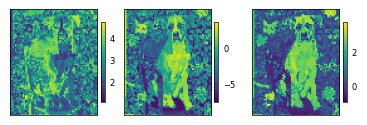

In [23]:
embeddings(encode, shape_=image.shape[0:2], figsize=(4.5, 1.25))


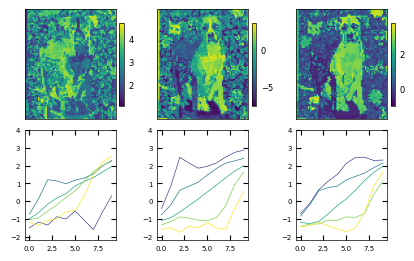

In [24]:
latent_generator(decoder, encode, image, 5, 10, device=device,
                 figsize=(5, 2.5), divider_=False)


In [25]:
latent_dim = 12

# input (batch,)


class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(1, 12, batch_first=True, bidirectional=True)
        self.embedding = nn.Linear(24, self.latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, (_, __) = self.lstm(x)
        x = x[:, -1, :]
        x = self.embedding(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(self.latent_dim, 12,
                            batch_first=True, bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
        x = x[:, :, None]
        x = x.transpose(1, 2)
        x = x.repeat([1, 10, 1])
        x, (_, __) = self.lstm(x)
        x = x.transpose(1, 2)
        x = self.tdd(x)
        x = x.transpose(1, 2)
        return x


In [26]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)


In [27]:
train_iterator = torch.utils.data.DataLoader(
    np.atleast_3d(X_train), batch_size=256, shuffle=False
)


In [28]:
random_seed(seed=42)
Train(model, encoder, decoder, train_iterator, optimizer, 500, device=device)


  0%|          | 0/19 [00:00<?, ?it/s]

  5%|▌         | 1/19 [00:00<00:04,  3.67it/s]

100%|██████████| 19/19 [00:00<00:00, 64.18it/s]

100%|██████████| 19/19 [00:00<00:00, 50.85it/s]

Epoch 0, Train Loss: 2.2412
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.63it/s]

Epoch 1, Train Loss: 2.2313
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.38it/s]

Epoch 2, Train Loss: 2.2214
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.98it/s]

Epoch 3, Train Loss: 2.2117
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.28it/s]

Epoch 4, Train Loss: 2.2020
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.36it/s]

Epoch 5, Train Loss: 2.1923
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.67it/s]

Epoch 6, Train Loss: 2.1826
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.16it/s]

Epoch 7, Train Loss: 2.1729
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.34it/s]

Epoch 8, Train Loss: 2.1631
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.58it/s]

Epoch 9, Train Loss: 2.1533
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 190.46it/s]

Epoch 10, Train Loss: 2.1433
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 201.43it/s]

Epoch 11, Train Loss: 2.1333
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 202.21it/s]

Epoch 12, Train Loss: 2.1230
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.76it/s]

Epoch 13, Train Loss: 2.1126
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.53it/s]

Epoch 14, Train Loss: 2.1019
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.26it/s]

Epoch 15, Train Loss: 2.0911
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.58it/s]

Epoch 16, Train Loss: 2.0799
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 191.03it/s]

Epoch 17, Train Loss: 2.0686
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.49it/s]

Epoch 18, Train Loss: 2.0569
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 190.38it/s]

Epoch 19, Train Loss: 2.0449
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.88it/s]

Epoch 20, Train Loss: 2.0326
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.66it/s]

Epoch 21, Train Loss: 2.0200
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.41it/s]

Epoch 22, Train Loss: 2.0070
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.51it/s]

Epoch 23, Train Loss: 1.9937
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 191.71it/s]

Epoch 24, Train Loss: 1.9799
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.11it/s]

Epoch 25, Train Loss: 1.9658
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.81it/s]

Epoch 26, Train Loss: 1.9512
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.46it/s]

Epoch 27, Train Loss: 1.9362
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.24it/s]

Epoch 28, Train Loss: 1.9208
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.58it/s]

Epoch 29, Train Loss: 1.9050
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.80it/s]

Epoch 30, Train Loss: 1.8887
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.93it/s]

Epoch 31, Train Loss: 1.8719
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.38it/s]

Epoch 32, Train Loss: 1.8548
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.86it/s]

Epoch 33, Train Loss: 1.8372
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.27it/s]

Epoch 34, Train Loss: 1.8192
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.41it/s]

Epoch 35, Train Loss: 1.8008
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.21it/s]

Epoch 36, Train Loss: 1.7821
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.41it/s]

Epoch 37, Train Loss: 1.7630
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 201.29it/s]

Epoch 38, Train Loss: 1.7436
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.56it/s]

Epoch 39, Train Loss: 1.7240
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.00it/s]

Epoch 40, Train Loss: 1.7042
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.47it/s]

Epoch 41, Train Loss: 1.6842
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.09it/s]

Epoch 42, Train Loss: 1.6642
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.23it/s]

Epoch 43, Train Loss: 1.6441
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.32it/s]

Epoch 44, Train Loss: 1.6241
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.51it/s]

Epoch 45, Train Loss: 1.6043
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.29it/s]

Epoch 46, Train Loss: 1.5846
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.78it/s]

Epoch 47, Train Loss: 1.5652
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.59it/s]

Epoch 48, Train Loss: 1.5462
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.00it/s]

Epoch 49, Train Loss: 1.5276
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 201.28it/s]

Epoch 50, Train Loss: 1.5093
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 201.67it/s]

Epoch 51, Train Loss: 1.4916
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 202.05it/s]

Epoch 52, Train Loss: 1.4743
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.67it/s]

Epoch 53, Train Loss: 1.4574
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.48it/s]

Epoch 54, Train Loss: 1.4410
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 202.07it/s]

Epoch 55, Train Loss: 1.4251
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.66it/s]

Epoch 56, Train Loss: 1.4096
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.51it/s]

Epoch 57, Train Loss: 1.3944
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.88it/s]

Epoch 58, Train Loss: 1.3796
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.64it/s]

Epoch 59, Train Loss: 1.3650
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.58it/s]

Epoch 60, Train Loss: 1.3507
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.70it/s]

Epoch 61, Train Loss: 1.3366
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.65it/s]

Epoch 62, Train Loss: 1.3226
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 191.27it/s]

Epoch 63, Train Loss: 1.3087
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.62it/s]

Epoch 64, Train Loss: 1.2948
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.82it/s]

Epoch 65, Train Loss: 1.2810
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.90it/s]

Epoch 66, Train Loss: 1.2672
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.82it/s]

Epoch 67, Train Loss: 1.2534
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.17it/s]

Epoch 68, Train Loss: 1.2395
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 191.22it/s]

Epoch 69, Train Loss: 1.2255
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.10it/s]

Epoch 70, Train Loss: 1.2115
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.75it/s]

Epoch 71, Train Loss: 1.1974
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.84it/s]

Epoch 72, Train Loss: 1.1832
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.32it/s]

Epoch 73, Train Loss: 1.1689
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.21it/s]

Epoch 74, Train Loss: 1.1546
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 190.05it/s]

Epoch 75, Train Loss: 1.1401
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.66it/s]

Epoch 76, Train Loss: 1.1256
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.24it/s]

Epoch 77, Train Loss: 1.1109
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.65it/s]

Epoch 78, Train Loss: 1.0962
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.70it/s]

Epoch 79, Train Loss: 1.0814
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.13it/s]

Epoch 80, Train Loss: 1.0666
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.54it/s]

Epoch 81, Train Loss: 1.0516
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.04it/s]

Epoch 82, Train Loss: 1.0367
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.60it/s]

Epoch 83, Train Loss: 1.0217
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.29it/s]

Epoch 84, Train Loss: 1.0067
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 202.78it/s]

Epoch 85, Train Loss: 0.9916
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.70it/s]

Epoch 86, Train Loss: 0.9766
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 202.02it/s]

Epoch 87, Train Loss: 0.9615
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.18it/s]

Epoch 88, Train Loss: 0.9465
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.34it/s]

Epoch 89, Train Loss: 0.9314
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.06it/s]

Epoch 90, Train Loss: 0.9164
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.09it/s]

Epoch 91, Train Loss: 0.9015
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.97it/s]

Epoch 92, Train Loss: 0.8866
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.82it/s]

Epoch 93, Train Loss: 0.8717
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.52it/s]

Epoch 94, Train Loss: 0.8569
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 189.56it/s]

100%|██████████| 19/19 [00:00<00:00, 188.74it/s]

Epoch 95, Train Loss: 0.8422
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.08it/s]

Epoch 96, Train Loss: 0.8275
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 191.14it/s]

Epoch 97, Train Loss: 0.8129
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.24it/s]

Epoch 98, Train Loss: 0.7984
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.29it/s]

Epoch 99, Train Loss: 0.7840
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.37it/s]

Epoch 100, Train Loss: 0.7697
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 188.90it/s]

100%|██████████| 19/19 [00:00<00:00, 187.98it/s]

Epoch 101, Train Loss: 0.7555
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 191.60it/s]

Epoch 102, Train Loss: 0.7414
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.13it/s]

Epoch 103, Train Loss: 0.7274
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.97it/s]

Epoch 104, Train Loss: 0.7135
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.98it/s]

Epoch 105, Train Loss: 0.6997
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.88it/s]

Epoch 106, Train Loss: 0.6861
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.33it/s]

Epoch 107, Train Loss: 0.6726
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.15it/s]

Epoch 108, Train Loss: 0.6592
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.52it/s]

Epoch 109, Train Loss: 0.6459
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.84it/s]

Epoch 110, Train Loss: 0.6328
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.25it/s]

Epoch 111, Train Loss: 0.6199
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.18it/s]

Epoch 112, Train Loss: 0.6070
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 186.30it/s]

100%|██████████| 19/19 [00:00<00:00, 185.48it/s]

Epoch 113, Train Loss: 0.5944
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.93it/s]

Epoch 114, Train Loss: 0.5818
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.67it/s]

Epoch 115, Train Loss: 0.5695
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.60it/s]

Epoch 116, Train Loss: 0.5573
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.31it/s]

Epoch 117, Train Loss: 0.5453
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.36it/s]

Epoch 118, Train Loss: 0.5334
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.22it/s]

Epoch 119, Train Loss: 0.5218
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.17it/s]

Epoch 120, Train Loss: 0.5104
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 191.92it/s]

Epoch 121, Train Loss: 0.4991
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.89it/s]

Epoch 122, Train Loss: 0.4881
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.85it/s]

Epoch 123, Train Loss: 0.4774
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 181.83it/s]

100%|██████████| 19/19 [00:00<00:00, 181.00it/s]

Epoch 124, Train Loss: 0.4668
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.66it/s]

Epoch 125, Train Loss: 0.4566
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.34it/s]

Epoch 126, Train Loss: 0.4466
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.87it/s]

Epoch 127, Train Loss: 0.4369
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.44it/s]

Epoch 128, Train Loss: 0.4274
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.71it/s]

Epoch 129, Train Loss: 0.4183
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.48it/s]

Epoch 130, Train Loss: 0.4094
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.02it/s]

Epoch 131, Train Loss: 0.4008
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 187.48it/s]

100%|██████████| 19/19 [00:00<00:00, 186.19it/s]

Epoch 132, Train Loss: 0.3925
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.68it/s]

Epoch 133, Train Loss: 0.3845
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.88it/s]

Epoch 134, Train Loss: 0.3767
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.44it/s]

Epoch 135, Train Loss: 0.3692
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.00it/s]

Epoch 136, Train Loss: 0.3620
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.40it/s]

Epoch 137, Train Loss: 0.3550
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.16it/s]

Epoch 138, Train Loss: 0.3482
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.56it/s]

Epoch 139, Train Loss: 0.3417
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.31it/s]

Epoch 140, Train Loss: 0.3354
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.43it/s]

Epoch 141, Train Loss: 0.3294
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.57it/s]

Epoch 142, Train Loss: 0.3235
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.15it/s]

Epoch 143, Train Loss: 0.3179
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 202.57it/s]

Epoch 144, Train Loss: 0.3124
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.36it/s]

Epoch 145, Train Loss: 0.3072
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.73it/s]

Epoch 146, Train Loss: 0.3021
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.93it/s]

Epoch 147, Train Loss: 0.2973
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.58it/s]

Epoch 148, Train Loss: 0.2926
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.69it/s]

Epoch 149, Train Loss: 0.2880
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.35it/s]

Epoch 150, Train Loss: 0.2837
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.91it/s]

Epoch 151, Train Loss: 0.2795
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.62it/s]

Epoch 152, Train Loss: 0.2755
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.45it/s]

Epoch 153, Train Loss: 0.2716
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.96it/s]

Epoch 154, Train Loss: 0.2678
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.83it/s]

Epoch 155, Train Loss: 0.2642
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.82it/s]

Epoch 156, Train Loss: 0.2607
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 202.69it/s]

Epoch 157, Train Loss: 0.2574
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.55it/s]

Epoch 158, Train Loss: 0.2542
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.81it/s]

Epoch 159, Train Loss: 0.2511
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.33it/s]

Epoch 160, Train Loss: 0.2481
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.76it/s]

Epoch 161, Train Loss: 0.2453
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.46it/s]

Epoch 162, Train Loss: 0.2425
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.71it/s]

Epoch 163, Train Loss: 0.2399
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.11it/s]

Epoch 164, Train Loss: 0.2374
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 201.66it/s]

Epoch 165, Train Loss: 0.2349
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 201.20it/s]

Epoch 166, Train Loss: 0.2326
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.89it/s]

Epoch 167, Train Loss: 0.2303
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 218.52it/s]

Epoch 168, Train Loss: 0.2281
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 219.72it/s]

Epoch 169, Train Loss: 0.2261
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 245.55it/s]

Epoch 170, Train Loss: 0.2241
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 245.71it/s]

Epoch 171, Train Loss: 0.2221
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 245.72it/s]

Epoch 172, Train Loss: 0.2203
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 254.75it/s]

Epoch 173, Train Loss: 0.2185
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 254.33it/s]

Epoch 174, Train Loss: 0.2167
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.41it/s]

Epoch 175, Train Loss: 0.2151
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.69it/s]

Epoch 176, Train Loss: 0.2135
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.22it/s]

Epoch 177, Train Loss: 0.2119
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.30it/s]

Epoch 178, Train Loss: 0.2104
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 230.49it/s]

Epoch 179, Train Loss: 0.2090
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.00it/s]

Epoch 180, Train Loss: 0.2076
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 241.09it/s]

Epoch 181, Train Loss: 0.2062
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 238.36it/s]

Epoch 182, Train Loss: 0.2049
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 232.26it/s]

Epoch 183, Train Loss: 0.2036
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 239.64it/s]

Epoch 184, Train Loss: 0.2024
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 233.70it/s]

Epoch 185, Train Loss: 0.2012
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 238.47it/s]

Epoch 186, Train Loss: 0.2000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 235.64it/s]

Epoch 187, Train Loss: 0.1989
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 241.99it/s]

Epoch 188, Train Loss: 0.1977
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 233.06it/s]

Epoch 189, Train Loss: 0.1967
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 248.58it/s]

Epoch 190, Train Loss: 0.1956
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.53it/s]

Epoch 191, Train Loss: 0.1945
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.58it/s]

Epoch 192, Train Loss: 0.1935
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.54it/s]

Epoch 193, Train Loss: 0.1925
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.33it/s]

Epoch 194, Train Loss: 0.1915
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 247.67it/s]

Epoch 195, Train Loss: 0.1906
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.37it/s]

Epoch 196, Train Loss: 0.1897
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 239.95it/s]

Epoch 197, Train Loss: 0.1888
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 241.08it/s]

Epoch 198, Train Loss: 0.1879
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 232.70it/s]

Epoch 199, Train Loss: 0.1871
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 236.68it/s]

Epoch 200, Train Loss: 0.1862
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 236.49it/s]

Epoch 201, Train Loss: 0.1854
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 238.74it/s]

Epoch 202, Train Loss: 0.1847
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 227.89it/s]

Epoch 203, Train Loss: 0.1839
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 241.03it/s]

Epoch 204, Train Loss: 0.1832
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 233.02it/s]

Epoch 205, Train Loss: 0.1825
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 242.86it/s]

Epoch 206, Train Loss: 0.1818
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 242.12it/s]

Epoch 207, Train Loss: 0.1812
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 232.49it/s]

Epoch 208, Train Loss: 0.1805
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 238.46it/s]

Epoch 209, Train Loss: 0.1799
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 233.52it/s]

Epoch 210, Train Loss: 0.1793
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.81it/s]

Epoch 211, Train Loss: 0.1787
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.56it/s]

Epoch 212, Train Loss: 0.1781
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.08it/s]

Epoch 213, Train Loss: 0.1776
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.16it/s]

Epoch 214, Train Loss: 0.1771
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 221.43it/s]

Epoch 215, Train Loss: 0.1765
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 230.66it/s]

Epoch 216, Train Loss: 0.1760
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.10it/s]

Epoch 217, Train Loss: 0.1755
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 239.53it/s]

Epoch 218, Train Loss: 0.1750
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.86it/s]

Epoch 219, Train Loss: 0.1746
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 239.56it/s]

Epoch 220, Train Loss: 0.1741
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 244.91it/s]

Epoch 221, Train Loss: 0.1736
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 248.53it/s]

Epoch 222, Train Loss: 0.1732
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 216.05it/s]

Epoch 223, Train Loss: 0.1728
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 238.02it/s]

Epoch 224, Train Loss: 0.1723
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.63it/s]

Epoch 225, Train Loss: 0.1719
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 244.15it/s]

Epoch 226, Train Loss: 0.1715
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.40it/s]

Epoch 227, Train Loss: 0.1711
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.08it/s]

Epoch 228, Train Loss: 0.1707
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 244.05it/s]

Epoch 229, Train Loss: 0.1704
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.75it/s]

Epoch 230, Train Loss: 0.1700
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 233.20it/s]

Epoch 231, Train Loss: 0.1696
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 229.88it/s]

Epoch 232, Train Loss: 0.1692
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 232.26it/s]

Epoch 233, Train Loss: 0.1689
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.76it/s]

Epoch 234, Train Loss: 0.1685
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.43it/s]

Epoch 235, Train Loss: 0.1682
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 248.20it/s]

Epoch 236, Train Loss: 0.1678
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.65it/s]

Epoch 237, Train Loss: 0.1675
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 239.07it/s]

Epoch 238, Train Loss: 0.1672
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 230.02it/s]

Epoch 239, Train Loss: 0.1668
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 241.37it/s]

Epoch 240, Train Loss: 0.1665
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 241.31it/s]

Epoch 241, Train Loss: 0.1662
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 230.47it/s]

Epoch 242, Train Loss: 0.1659
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 241.49it/s]

Epoch 243, Train Loss: 0.1655
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 241.32it/s]

Epoch 244, Train Loss: 0.1652
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 233.04it/s]

Epoch 245, Train Loss: 0.1649
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.49it/s]

Epoch 246, Train Loss: 0.1646
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 235.40it/s]

Epoch 247, Train Loss: 0.1643
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 244.25it/s]

Epoch 248, Train Loss: 0.1640
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 241.13it/s]

Epoch 249, Train Loss: 0.1637
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 232.91it/s]

Epoch 250, Train Loss: 0.1634
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.58it/s]

Epoch 251, Train Loss: 0.1631
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 229.19it/s]

Epoch 252, Train Loss: 0.1628
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.67it/s]

Epoch 253, Train Loss: 0.1625
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 233.00it/s]

Epoch 254, Train Loss: 0.1622
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 232.62it/s]

Epoch 255, Train Loss: 0.1619
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 244.66it/s]

Epoch 256, Train Loss: 0.1616
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 239.80it/s]

Epoch 257, Train Loss: 0.1614
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.33it/s]

Epoch 258, Train Loss: 0.1611
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 241.81it/s]

Epoch 259, Train Loss: 0.1608
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.54it/s]

Epoch 260, Train Loss: 0.1605
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 232.70it/s]

Epoch 261, Train Loss: 0.1602
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 225.66it/s]

Epoch 262, Train Loss: 0.1599
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 220.64it/s]

Epoch 263, Train Loss: 0.1597
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 220.50it/s]

Epoch 264, Train Loss: 0.1594
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.34it/s]

Epoch 265, Train Loss: 0.1591
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 224.33it/s]

Epoch 266, Train Loss: 0.1588
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.47it/s]

Epoch 267, Train Loss: 0.1585
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 248.56it/s]

Epoch 268, Train Loss: 0.1583
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 232.68it/s]

Epoch 269, Train Loss: 0.1580
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 242.07it/s]

Epoch 270, Train Loss: 0.1577
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 230.78it/s]

Epoch 271, Train Loss: 0.1574
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 216.71it/s]

Epoch 272, Train Loss: 0.1571
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.53it/s]

Epoch 273, Train Loss: 0.1569
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 218.20it/s]

Epoch 274, Train Loss: 0.1566
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 222.98it/s]

Epoch 275, Train Loss: 0.1563
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.78it/s]

Epoch 276, Train Loss: 0.1560
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 239.71it/s]

Epoch 277, Train Loss: 0.1558
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.23it/s]

Epoch 278, Train Loss: 0.1555
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 233.95it/s]

Epoch 279, Train Loss: 0.1552
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 229.19it/s]

Epoch 280, Train Loss: 0.1549
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 238.46it/s]

Epoch 281, Train Loss: 0.1547
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 235.14it/s]

Epoch 282, Train Loss: 0.1544
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.95it/s]

Epoch 283, Train Loss: 0.1541
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.74it/s]

Epoch 284, Train Loss: 0.1538
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.98it/s]

Epoch 285, Train Loss: 0.1536
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 249.37it/s]

Epoch 286, Train Loss: 0.1533
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.69it/s]

Epoch 287, Train Loss: 0.1530
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 238.49it/s]

Epoch 288, Train Loss: 0.1528
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.70it/s]

Epoch 289, Train Loss: 0.1525
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 245.24it/s]

Epoch 290, Train Loss: 0.1522
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 238.91it/s]

Epoch 291, Train Loss: 0.1520
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.77it/s]

Epoch 292, Train Loss: 0.1517
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 248.92it/s]

Epoch 293, Train Loss: 0.1514
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 239.27it/s]

Epoch 294, Train Loss: 0.1511
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 239.07it/s]

Epoch 295, Train Loss: 0.1509
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 216.90it/s]

Epoch 296, Train Loss: 0.1506
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.75it/s]

Epoch 297, Train Loss: 0.1503
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 235.30it/s]

Epoch 298, Train Loss: 0.1501
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 247.08it/s]

Epoch 299, Train Loss: 0.1498
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 233.86it/s]

Epoch 300, Train Loss: 0.1496
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.50it/s]

Epoch 301, Train Loss: 0.1493
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 239.09it/s]

Epoch 302, Train Loss: 0.1490
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.46it/s]

Epoch 303, Train Loss: 0.1488
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 230.32it/s]

Epoch 304, Train Loss: 0.1485
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 239.46it/s]

Epoch 305, Train Loss: 0.1483
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.12it/s]

Epoch 306, Train Loss: 0.1480
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 238.61it/s]

Epoch 307, Train Loss: 0.1477
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 229.30it/s]

Epoch 308, Train Loss: 0.1475
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 247.80it/s]

Epoch 309, Train Loss: 0.1472
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 219.24it/s]

Epoch 310, Train Loss: 0.1470
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 239.08it/s]

Epoch 311, Train Loss: 0.1467
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 238.23it/s]

Epoch 312, Train Loss: 0.1465
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 235.09it/s]

Epoch 313, Train Loss: 0.1462
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.35it/s]

Epoch 314, Train Loss: 0.1460
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.59it/s]

Epoch 315, Train Loss: 0.1457
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 221.77it/s]

Epoch 316, Train Loss: 0.1455
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.17it/s]

Epoch 317, Train Loss: 0.1452
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.09it/s]

Epoch 318, Train Loss: 0.1450
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.76it/s]

Epoch 319, Train Loss: 0.1447
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 235.56it/s]

Epoch 320, Train Loss: 0.1445
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 245.75it/s]

Epoch 321, Train Loss: 0.1442
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 238.36it/s]

Epoch 322, Train Loss: 0.1440
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 236.03it/s]

Epoch 323, Train Loss: 0.1438
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 230.89it/s]

Epoch 324, Train Loss: 0.1435
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 229.56it/s]

Epoch 325, Train Loss: 0.1433
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.06it/s]

Epoch 326, Train Loss: 0.1430
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 230.78it/s]

Epoch 327, Train Loss: 0.1428
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 245.10it/s]

Epoch 328, Train Loss: 0.1426
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.91it/s]

Epoch 329, Train Loss: 0.1423
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 217.88it/s]

Epoch 330, Train Loss: 0.1421
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.95it/s]

Epoch 331, Train Loss: 0.1419
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 254.48it/s]

Epoch 332, Train Loss: 0.1416
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 254.00it/s]

Epoch 333, Train Loss: 0.1414
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.72it/s]

Epoch 334, Train Loss: 0.1412
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 254.08it/s]

Epoch 335, Train Loss: 0.1409
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 254.26it/s]

Epoch 336, Train Loss: 0.1407
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 242.82it/s]

Epoch 337, Train Loss: 0.1405
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 254.29it/s]

Epoch 338, Train Loss: 0.1403
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 245.06it/s]

Epoch 339, Train Loss: 0.1400
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 242.70it/s]

Epoch 340, Train Loss: 0.1398
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 244.79it/s]

Epoch 341, Train Loss: 0.1396
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 242.80it/s]

Epoch 342, Train Loss: 0.1394
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 254.45it/s]

Epoch 343, Train Loss: 0.1392
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 244.68it/s]

Epoch 344, Train Loss: 0.1389
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 242.30it/s]

Epoch 345, Train Loss: 0.1387
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 230.96it/s]

Epoch 346, Train Loss: 0.1385
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.07it/s]

Epoch 347, Train Loss: 0.1383
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.91it/s]

Epoch 348, Train Loss: 0.1381
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 202.83it/s]

Epoch 349, Train Loss: 0.1379
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.12it/s]

Epoch 350, Train Loss: 0.1377
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.31it/s]

Epoch 351, Train Loss: 0.1375
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.53it/s]

Epoch 352, Train Loss: 0.1372
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.97it/s]

Epoch 353, Train Loss: 0.1370
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.08it/s]

Epoch 354, Train Loss: 0.1368
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.77it/s]

Epoch 355, Train Loss: 0.1366
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.59it/s]

Epoch 356, Train Loss: 0.1364
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.07it/s]

Epoch 357, Train Loss: 0.1362
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.17it/s]

Epoch 358, Train Loss: 0.1360
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.49it/s]

Epoch 359, Train Loss: 0.1358
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 201.53it/s]

Epoch 360, Train Loss: 0.1356
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.41it/s]

Epoch 361, Train Loss: 0.1354
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.97it/s]

Epoch 362, Train Loss: 0.1353
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.96it/s]

Epoch 363, Train Loss: 0.1351
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.70it/s]

Epoch 364, Train Loss: 0.1349
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.44it/s]

Epoch 365, Train Loss: 0.1347
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 190.15it/s]

Epoch 366, Train Loss: 0.1345
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.73it/s]

Epoch 367, Train Loss: 0.1343
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.67it/s]

Epoch 368, Train Loss: 0.1341
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.49it/s]

Epoch 369, Train Loss: 0.1339
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 189.72it/s]

100%|██████████| 19/19 [00:00<00:00, 188.88it/s]

Epoch 370, Train Loss: 0.1338
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.08it/s]

Epoch 371, Train Loss: 0.1336
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.92it/s]

Epoch 372, Train Loss: 0.1334
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.17it/s]

Epoch 373, Train Loss: 0.1332
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 190.97it/s]

Epoch 374, Train Loss: 0.1331
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.89it/s]

Epoch 375, Train Loss: 0.1329
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.33it/s]

Epoch 376, Train Loss: 0.1327
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.30it/s]

Epoch 377, Train Loss: 0.1325
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.62it/s]

Epoch 378, Train Loss: 0.1324
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.50it/s]

Epoch 379, Train Loss: 0.1322
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.01it/s]

Epoch 380, Train Loss: 0.1320
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.58it/s]

Epoch 381, Train Loss: 0.1319
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.96it/s]

Epoch 382, Train Loss: 0.1317
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.07it/s]

Epoch 383, Train Loss: 0.1315
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.32it/s]

Epoch 384, Train Loss: 0.1314
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.52it/s]

Epoch 385, Train Loss: 0.1312
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.35it/s]

Epoch 386, Train Loss: 0.1310
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 189.62it/s]

100%|██████████| 19/19 [00:00<00:00, 188.52it/s]

Epoch 387, Train Loss: 0.1309
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.22it/s]

Epoch 388, Train Loss: 0.1307
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.77it/s]

Epoch 389, Train Loss: 0.1306
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.84it/s]

Epoch 390, Train Loss: 0.1304
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.87it/s]

Epoch 391, Train Loss: 0.1303
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.59it/s]

Epoch 392, Train Loss: 0.1301
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.12it/s]

Epoch 393, Train Loss: 0.1299
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 187.46it/s]

100%|██████████| 19/19 [00:00<00:00, 186.67it/s]

Epoch 394, Train Loss: 0.1298
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.59it/s]

Epoch 395, Train Loss: 0.1296
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.76it/s]

Epoch 396, Train Loss: 0.1295
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.68it/s]

Epoch 397, Train Loss: 0.1293
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.30it/s]

Epoch 398, Train Loss: 0.1292
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.89it/s]

Epoch 399, Train Loss: 0.1290
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 190.11it/s]

Epoch 400, Train Loss: 0.1289
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.18it/s]

Epoch 401, Train Loss: 0.1288
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.80it/s]

Epoch 402, Train Loss: 0.1286
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.67it/s]

Epoch 403, Train Loss: 0.1285
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.96it/s]

Epoch 404, Train Loss: 0.1283
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.41it/s]

Epoch 405, Train Loss: 0.1282
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.19it/s]

Epoch 406, Train Loss: 0.1280
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.98it/s]

Epoch 407, Train Loss: 0.1279
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 188.88it/s]

100%|██████████| 19/19 [00:00<00:00, 188.17it/s]

Epoch 408, Train Loss: 0.1277
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.20it/s]

Epoch 409, Train Loss: 0.1276
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.61it/s]

Epoch 410, Train Loss: 0.1275
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.47it/s]

Epoch 411, Train Loss: 0.1273
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.31it/s]

Epoch 412, Train Loss: 0.1272
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 189.94it/s]

Epoch 413, Train Loss: 0.1270
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.95it/s]

Epoch 414, Train Loss: 0.1269
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.19it/s]

Epoch 415, Train Loss: 0.1268
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.89it/s]

Epoch 416, Train Loss: 0.1266
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.42it/s]

Epoch 417, Train Loss: 0.1265
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.99it/s]

Epoch 418, Train Loss: 0.1264
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.90it/s]

Epoch 419, Train Loss: 0.1262
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.46it/s]

Epoch 420, Train Loss: 0.1261
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.02it/s]

Epoch 421, Train Loss: 0.1260
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.57it/s]

Epoch 422, Train Loss: 0.1258
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 201.46it/s]

Epoch 423, Train Loss: 0.1257
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 206.58it/s]

Epoch 424, Train Loss: 0.1256
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 190.61it/s]

Epoch 425, Train Loss: 0.1254
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.36it/s]

Epoch 426, Train Loss: 0.1253
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.11it/s]

Epoch 427, Train Loss: 0.1251
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 201.88it/s]

Epoch 428, Train Loss: 0.1250
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.65it/s]

Epoch 429, Train Loss: 0.1249
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.51it/s]

Epoch 430, Train Loss: 0.1248
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.06it/s]

Epoch 431, Train Loss: 0.1246
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.04it/s]

Epoch 432, Train Loss: 0.1245
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 191.87it/s]

Epoch 433, Train Loss: 0.1244
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 201.35it/s]

Epoch 434, Train Loss: 0.1242
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.17it/s]

Epoch 435, Train Loss: 0.1241
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 184.09it/s]

100%|██████████| 19/19 [00:00<00:00, 183.22it/s]

Epoch 436, Train Loss: 0.1240
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.68it/s]

Epoch 437, Train Loss: 0.1238
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.26it/s]

Epoch 438, Train Loss: 0.1237
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.98it/s]

Epoch 439, Train Loss: 0.1236
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 189.33it/s]

100%|██████████| 19/19 [00:00<00:00, 188.45it/s]

Epoch 440, Train Loss: 0.1234
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.01it/s]

Epoch 441, Train Loss: 0.1233
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.64it/s]

Epoch 442, Train Loss: 0.1232
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 201.80it/s]

Epoch 443, Train Loss: 0.1231
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.13it/s]

Epoch 444, Train Loss: 0.1229
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.84it/s]

Epoch 445, Train Loss: 0.1228
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.96it/s]

Epoch 446, Train Loss: 0.1227
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.16it/s]

Epoch 447, Train Loss: 0.1225
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 201.51it/s]

Epoch 448, Train Loss: 0.1224
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 202.20it/s]

Epoch 449, Train Loss: 0.1223
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 203.64it/s]

Epoch 450, Train Loss: 0.1222
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.61it/s]

Epoch 451, Train Loss: 0.1220
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.36it/s]

Epoch 452, Train Loss: 0.1219
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.53it/s]

Epoch 453, Train Loss: 0.1218
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.77it/s]

Epoch 454, Train Loss: 0.1216
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.23it/s]

Epoch 455, Train Loss: 0.1215
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.93it/s]

Epoch 456, Train Loss: 0.1214
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.63it/s]

Epoch 457, Train Loss: 0.1213
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.38it/s]

Epoch 458, Train Loss: 0.1211
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.78it/s]

Epoch 459, Train Loss: 0.1210
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.29it/s]

Epoch 460, Train Loss: 0.1209
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.51it/s]

Epoch 461, Train Loss: 0.1208
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 202.92it/s]

Epoch 462, Train Loss: 0.1206
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.35it/s]

Epoch 463, Train Loss: 0.1205
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.74it/s]

Epoch 464, Train Loss: 0.1204
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.88it/s]

Epoch 465, Train Loss: 0.1202
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.59it/s]

Epoch 466, Train Loss: 0.1201
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.21it/s]

Epoch 467, Train Loss: 0.1200
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 191.23it/s]

Epoch 468, Train Loss: 0.1199
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 190.05it/s]

Epoch 469, Train Loss: 0.1197
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.79it/s]

Epoch 470, Train Loss: 0.1196
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.81it/s]

Epoch 471, Train Loss: 0.1195
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.18it/s]

Epoch 472, Train Loss: 0.1194
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.37it/s]

Epoch 473, Train Loss: 0.1192
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.70it/s]

Epoch 474, Train Loss: 0.1191
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.19it/s]

Epoch 475, Train Loss: 0.1190
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 202.18it/s]

Epoch 476, Train Loss: 0.1188
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.24it/s]

Epoch 477, Train Loss: 0.1187
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.04it/s]

Epoch 478, Train Loss: 0.1186
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 187.16it/s]

100%|██████████| 19/19 [00:00<00:00, 186.09it/s]

Epoch 479, Train Loss: 0.1185
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.37it/s]

Epoch 480, Train Loss: 0.1183
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 186.17it/s]

100%|██████████| 19/19 [00:00<00:00, 185.45it/s]

Epoch 481, Train Loss: 0.1182
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.68it/s]

Epoch 482, Train Loss: 0.1181
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.61it/s]

Epoch 483, Train Loss: 0.1180
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.55it/s]

Epoch 484, Train Loss: 0.1178
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.88it/s]

Epoch 485, Train Loss: 0.1177
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.50it/s]

Epoch 486, Train Loss: 0.1176
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.35it/s]

Epoch 487, Train Loss: 0.1174
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 191.63it/s]

Epoch 488, Train Loss: 0.1173
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 201.39it/s]

Epoch 489, Train Loss: 0.1172
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.75it/s]

Epoch 490, Train Loss: 0.1171
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.78it/s]

Epoch 491, Train Loss: 0.1169
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.69it/s]

Epoch 492, Train Loss: 0.1168
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.63it/s]

Epoch 493, Train Loss: 0.1167
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.85it/s]

Epoch 494, Train Loss: 0.1166
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.78it/s]

Epoch 495, Train Loss: 0.1164
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.53it/s]

Epoch 496, Train Loss: 0.1163
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.50it/s]

Epoch 497, Train Loss: 0.1162
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.78it/s]

Epoch 498, Train Loss: 0.1160
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.79it/s]

Epoch 499, Train Loss: 0.1159
.............................


In [29]:
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)


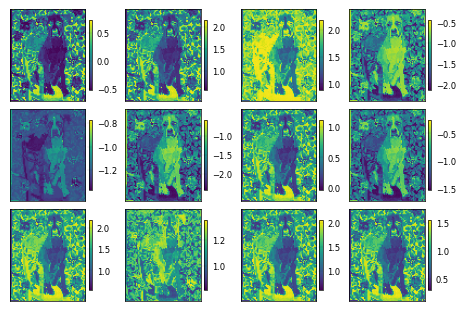

In [30]:
embeddings(encode, shape_=image.shape[0:2], figsize=(5, 3))


In [31]:
encoder = Encoder(latent_dim=3).to(device)
decoder = Decoder(latent_dim=3).to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)


In [32]:
model


Autoencoder(
  (encoder): Encoder(
    (lstm): LSTM(1, 12, batch_first=True, bidirectional=True)
    (embedding): Linear(in_features=24, out_features=3, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (lstm): LSTM(3, 12, batch_first=True, bidirectional=True)
    (tdd): Conv1d(24, 1, kernel_size=(1,), stride=(1,))
  )
)

In [33]:
train_iterator = torch.utils.data.DataLoader(
    np.atleast_3d(X_train), batch_size=256, shuffle=False
)


In [34]:
random_seed(seed=42)

Train(model, encoder, decoder, train_iterator, optimizer, 500, device=device)


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.29it/s]

Epoch 0, Train Loss: 2.0366
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.89it/s]

Epoch 1, Train Loss: 2.0331
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.22it/s]

Epoch 2, Train Loss: 2.0296
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.07it/s]

Epoch 3, Train Loss: 2.0262
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 188.15it/s]

100%|██████████| 19/19 [00:00<00:00, 186.89it/s]

Epoch 4, Train Loss: 2.0227
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.48it/s]

Epoch 5, Train Loss: 2.0193
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.41it/s]

Epoch 6, Train Loss: 2.0158
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 188.01it/s]

100%|██████████| 19/19 [00:00<00:00, 187.23it/s]

Epoch 7, Train Loss: 2.0124
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.18it/s]

Epoch 8, Train Loss: 2.0089
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 201.59it/s]

Epoch 9, Train Loss: 2.0054
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 187.87it/s]

100%|██████████| 19/19 [00:00<00:00, 186.94it/s]

Epoch 10, Train Loss: 2.0019
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 187.76it/s]

100%|██████████| 19/19 [00:00<00:00, 186.86it/s]

Epoch 11, Train Loss: 1.9984
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 202.47it/s]

Epoch 12, Train Loss: 1.9948
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.22it/s]

Epoch 13, Train Loss: 1.9912
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.32it/s]

Epoch 14, Train Loss: 1.9876
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.26it/s]

Epoch 15, Train Loss: 1.9839
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.81it/s]

Epoch 16, Train Loss: 1.9801
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.60it/s]

Epoch 17, Train Loss: 1.9763
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.32it/s]

Epoch 18, Train Loss: 1.9725
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.51it/s]

Epoch 19, Train Loss: 1.9685
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.35it/s]

Epoch 20, Train Loss: 1.9645
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.16it/s]

Epoch 21, Train Loss: 1.9604
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 201.36it/s]

Epoch 22, Train Loss: 1.9562
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.61it/s]

Epoch 23, Train Loss: 1.9519
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.90it/s]

Epoch 24, Train Loss: 1.9476
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.23it/s]

Epoch 25, Train Loss: 1.9431
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.54it/s]

Epoch 26, Train Loss: 1.9384
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.03it/s]

Epoch 27, Train Loss: 1.9337
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 202.77it/s]

Epoch 28, Train Loss: 1.9288
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.12it/s]

Epoch 29, Train Loss: 1.9238
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.13it/s]

Epoch 30, Train Loss: 1.9186
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.44it/s]

Epoch 31, Train Loss: 1.9133
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.04it/s]

Epoch 32, Train Loss: 1.9077
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.54it/s]

Epoch 33, Train Loss: 1.9021
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.29it/s]

Epoch 34, Train Loss: 1.8962
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.93it/s]

Epoch 35, Train Loss: 1.8901
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.08it/s]

Epoch 36, Train Loss: 1.8838
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.42it/s]

Epoch 37, Train Loss: 1.8773
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.36it/s]

Epoch 38, Train Loss: 1.8705
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.09it/s]

Epoch 39, Train Loss: 1.8635
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.99it/s]

Epoch 40, Train Loss: 1.8563
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 202.04it/s]

Epoch 41, Train Loss: 1.8487
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.93it/s]

Epoch 42, Train Loss: 1.8409
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.15it/s]

Epoch 43, Train Loss: 1.8328
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.71it/s]

Epoch 44, Train Loss: 1.8244
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.95it/s]

Epoch 45, Train Loss: 1.8156
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.37it/s]

Epoch 46, Train Loss: 1.8065
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.36it/s]

Epoch 47, Train Loss: 1.7971
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.55it/s]

Epoch 48, Train Loss: 1.7872
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.74it/s]

Epoch 49, Train Loss: 1.7770
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.54it/s]

Epoch 50, Train Loss: 1.7664
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.60it/s]

Epoch 51, Train Loss: 1.7553
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.16it/s]

Epoch 52, Train Loss: 1.7437
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.39it/s]

Epoch 53, Train Loss: 1.7317
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.76it/s]

Epoch 54, Train Loss: 1.7192
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 203.47it/s]

Epoch 55, Train Loss: 1.7062
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.65it/s]

Epoch 56, Train Loss: 1.6927
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.68it/s]

Epoch 57, Train Loss: 1.6786
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.94it/s]

Epoch 58, Train Loss: 1.6640
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 201.58it/s]

Epoch 59, Train Loss: 1.6488
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.34it/s]

Epoch 60, Train Loss: 1.6331
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.32it/s]

Epoch 61, Train Loss: 1.6169
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.65it/s]

Epoch 62, Train Loss: 1.6002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.74it/s]

Epoch 63, Train Loss: 1.5830
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.66it/s]

Epoch 64, Train Loss: 1.5653
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.80it/s]

Epoch 65, Train Loss: 1.5472
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.25it/s]

Epoch 66, Train Loss: 1.5287
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.61it/s]

Epoch 67, Train Loss: 1.5099
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.57it/s]

Epoch 68, Train Loss: 1.4908
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.06it/s]

Epoch 69, Train Loss: 1.4715
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.97it/s]

Epoch 70, Train Loss: 1.4519
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.53it/s]

Epoch 71, Train Loss: 1.4322
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 187.82it/s]

100%|██████████| 19/19 [00:00<00:00, 187.10it/s]

Epoch 72, Train Loss: 1.4124
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.78it/s]

Epoch 73, Train Loss: 1.3925
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.71it/s]

Epoch 74, Train Loss: 1.3726
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.82it/s]

Epoch 75, Train Loss: 1.3526
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.61it/s]

Epoch 76, Train Loss: 1.3327
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 189.94it/s]

Epoch 77, Train Loss: 1.3128
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 187.47it/s]

100%|██████████| 19/19 [00:00<00:00, 186.46it/s]

Epoch 78, Train Loss: 1.2929
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.78it/s]

Epoch 79, Train Loss: 1.2731
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.81it/s]

Epoch 80, Train Loss: 1.2534
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 191.18it/s]

Epoch 81, Train Loss: 1.2337
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.74it/s]

Epoch 82, Train Loss: 1.2141
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.08it/s]

Epoch 83, Train Loss: 1.1946
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.31it/s]

Epoch 84, Train Loss: 1.1752
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 203.03it/s]

Epoch 85, Train Loss: 1.1558
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.63it/s]

Epoch 86, Train Loss: 1.1365
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.58it/s]

Epoch 87, Train Loss: 1.1172
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.44it/s]

Epoch 88, Train Loss: 1.0979
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 207.21it/s]

Epoch 89, Train Loss: 1.0786
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 239.50it/s]

Epoch 90, Train Loss: 1.0593
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 230.57it/s]

Epoch 91, Train Loss: 1.0400
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 241.31it/s]

Epoch 92, Train Loss: 1.0206
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 239.21it/s]

Epoch 93, Train Loss: 1.0010
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 232.22it/s]

Epoch 94, Train Loss: 0.9814
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 230.28it/s]

Epoch 95, Train Loss: 0.9616
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 221.85it/s]

Epoch 96, Train Loss: 0.9417
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 230.43it/s]

Epoch 97, Train Loss: 0.9216
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.66it/s]

Epoch 98, Train Loss: 0.9012
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.45it/s]

Epoch 99, Train Loss: 0.8807
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 241.49it/s]

Epoch 100, Train Loss: 0.8600
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.74it/s]

Epoch 101, Train Loss: 0.8391
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 242.71it/s]

Epoch 102, Train Loss: 0.8181
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.50it/s]

Epoch 103, Train Loss: 0.7968
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.30it/s]

Epoch 104, Train Loss: 0.7754
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 241.97it/s]

Epoch 105, Train Loss: 0.7539
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 241.12it/s]

Epoch 106, Train Loss: 0.7324
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 239.58it/s]

Epoch 107, Train Loss: 0.7108
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 238.52it/s]

Epoch 108, Train Loss: 0.6893
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 229.52it/s]

Epoch 109, Train Loss: 0.6680
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 249.37it/s]

Epoch 110, Train Loss: 0.6468
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 224.22it/s]

Epoch 111, Train Loss: 0.6259
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 225.63it/s]

Epoch 112, Train Loss: 0.6053
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.14it/s]

Epoch 113, Train Loss: 0.5853
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 239.09it/s]

Epoch 114, Train Loss: 0.5657
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.64it/s]

Epoch 115, Train Loss: 0.5467
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.40it/s]

Epoch 116, Train Loss: 0.5284
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 230.69it/s]

Epoch 117, Train Loss: 0.5108
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 242.08it/s]

Epoch 118, Train Loss: 0.4939
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 241.13it/s]

Epoch 119, Train Loss: 0.4779
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.14it/s]

Epoch 120, Train Loss: 0.4626
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 224.94it/s]

Epoch 121, Train Loss: 0.4482
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 230.76it/s]

Epoch 122, Train Loss: 0.4346
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.79it/s]

Epoch 123, Train Loss: 0.4218
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.22it/s]

Epoch 124, Train Loss: 0.4097
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.89it/s]

Epoch 125, Train Loss: 0.3984
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.87it/s]

Epoch 126, Train Loss: 0.3878
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 233.92it/s]

Epoch 127, Train Loss: 0.3778
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 247.13it/s]

Epoch 128, Train Loss: 0.3685
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.20it/s]

Epoch 129, Train Loss: 0.3597
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.26it/s]

Epoch 130, Train Loss: 0.3515
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 242.08it/s]

Epoch 131, Train Loss: 0.3438
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.61it/s]

Epoch 132, Train Loss: 0.3365
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 241.57it/s]

Epoch 133, Train Loss: 0.3297
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.18it/s]

Epoch 134, Train Loss: 0.3232
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 242.37it/s]

Epoch 135, Train Loss: 0.3171
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 241.99it/s]

Epoch 136, Train Loss: 0.3114
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 239.03it/s]

Epoch 137, Train Loss: 0.3060
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 248.98it/s]

Epoch 138, Train Loss: 0.3009
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 232.19it/s]

Epoch 139, Train Loss: 0.2961
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.77it/s]

Epoch 140, Train Loss: 0.2915
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.44it/s]

Epoch 141, Train Loss: 0.2872
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 232.08it/s]

Epoch 142, Train Loss: 0.2831
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 241.65it/s]

Epoch 143, Train Loss: 0.2792
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.62it/s]

Epoch 144, Train Loss: 0.2756
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 229.80it/s]

Epoch 145, Train Loss: 0.2721
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.45it/s]

Epoch 146, Train Loss: 0.2688
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 239.76it/s]

Epoch 147, Train Loss: 0.2657
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 232.75it/s]

Epoch 148, Train Loss: 0.2628
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.46it/s]

Epoch 149, Train Loss: 0.2600
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 241.39it/s]

Epoch 150, Train Loss: 0.2574
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.24it/s]

Epoch 151, Train Loss: 0.2549
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.12it/s]

Epoch 152, Train Loss: 0.2525
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 230.41it/s]

Epoch 153, Train Loss: 0.2502
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 242.18it/s]

Epoch 154, Train Loss: 0.2481
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.87it/s]

Epoch 155, Train Loss: 0.2461
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 242.33it/s]

Epoch 156, Train Loss: 0.2441
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 229.17it/s]

Epoch 157, Train Loss: 0.2423
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.29it/s]

Epoch 158, Train Loss: 0.2405
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.79it/s]

Epoch 159, Train Loss: 0.2389
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 220.57it/s]

Epoch 160, Train Loss: 0.2373
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 238.80it/s]

Epoch 161, Train Loss: 0.2358
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 230.41it/s]

Epoch 162, Train Loss: 0.2343
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 248.26it/s]

Epoch 163, Train Loss: 0.2329
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 241.96it/s]

Epoch 164, Train Loss: 0.2316
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 239.29it/s]

Epoch 165, Train Loss: 0.2303
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 224.36it/s]

Epoch 166, Train Loss: 0.2291
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 191.06it/s]

Epoch 167, Train Loss: 0.2280
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.69it/s]

Epoch 168, Train Loss: 0.2269
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.14it/s]

Epoch 169, Train Loss: 0.2258
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.28it/s]

Epoch 170, Train Loss: 0.2248
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.36it/s]

Epoch 171, Train Loss: 0.2238
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.20it/s]

Epoch 172, Train Loss: 0.2228
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.12it/s]

Epoch 173, Train Loss: 0.2219
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.65it/s]

Epoch 174, Train Loss: 0.2210
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.39it/s]

Epoch 175, Train Loss: 0.2201
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 203.22it/s]

Epoch 176, Train Loss: 0.2193
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.15it/s]

Epoch 177, Train Loss: 0.2185
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.95it/s]

Epoch 178, Train Loss: 0.2177
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 202.28it/s]

Epoch 179, Train Loss: 0.2169
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.44it/s]

Epoch 180, Train Loss: 0.2162
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 189.56it/s]

100%|██████████| 19/19 [00:00<00:00, 188.85it/s]

Epoch 181, Train Loss: 0.2155
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.23it/s]

Epoch 182, Train Loss: 0.2147
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 191.66it/s]

Epoch 183, Train Loss: 0.2140
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 191.00it/s]

Epoch 184, Train Loss: 0.2134
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.23it/s]

Epoch 185, Train Loss: 0.2127
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.87it/s]

Epoch 186, Train Loss: 0.2120
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 187.80it/s]

100%|██████████| 19/19 [00:00<00:00, 186.80it/s]

Epoch 187, Train Loss: 0.2114
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.45it/s]

Epoch 188, Train Loss: 0.2108
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.04it/s]

Epoch 189, Train Loss: 0.2101
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.68it/s]

Epoch 190, Train Loss: 0.2095
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.24it/s]

Epoch 191, Train Loss: 0.2089
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.03it/s]

Epoch 192, Train Loss: 0.2083
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.81it/s]

Epoch 193, Train Loss: 0.2078
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.03it/s]

Epoch 194, Train Loss: 0.2072
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.65it/s]

Epoch 195, Train Loss: 0.2066
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.84it/s]

Epoch 196, Train Loss: 0.2061
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 188.87it/s]

100%|██████████| 19/19 [00:00<00:00, 188.10it/s]

Epoch 197, Train Loss: 0.2055
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.84it/s]

Epoch 198, Train Loss: 0.2049
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.49it/s]

Epoch 199, Train Loss: 0.2044
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.12it/s]

Epoch 200, Train Loss: 0.2039
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.63it/s]

Epoch 201, Train Loss: 0.2033
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.06it/s]

Epoch 202, Train Loss: 0.2028
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.28it/s]

Epoch 203, Train Loss: 0.2023
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.52it/s]

Epoch 204, Train Loss: 0.2018
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 188.86it/s]

100%|██████████| 19/19 [00:00<00:00, 188.08it/s]

Epoch 205, Train Loss: 0.2013
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.80it/s]

Epoch 206, Train Loss: 0.2008
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.50it/s]

Epoch 207, Train Loss: 0.2002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.90it/s]

Epoch 208, Train Loss: 0.1998
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.81it/s]

Epoch 209, Train Loss: 0.1993
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.90it/s]

Epoch 210, Train Loss: 0.1988
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.57it/s]

Epoch 211, Train Loss: 0.1983
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.12it/s]

Epoch 212, Train Loss: 0.1978
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.85it/s]

Epoch 213, Train Loss: 0.1973
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.16it/s]

Epoch 214, Train Loss: 0.1968
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.15it/s]

Epoch 215, Train Loss: 0.1964
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 189.92it/s]

100%|██████████| 19/19 [00:00<00:00, 189.01it/s]

Epoch 216, Train Loss: 0.1959
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.92it/s]

Epoch 217, Train Loss: 0.1955
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.15it/s]

Epoch 218, Train Loss: 0.1950
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.17it/s]

Epoch 219, Train Loss: 0.1945
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 190.29it/s]

Epoch 220, Train Loss: 0.1941
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 201.41it/s]

Epoch 221, Train Loss: 0.1936
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.53it/s]

Epoch 222, Train Loss: 0.1932
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.17it/s]

Epoch 223, Train Loss: 0.1928


.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.73it/s]

Epoch 224, Train Loss: 0.1923
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.92it/s]

Epoch 225, Train Loss: 0.1919
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.37it/s]

Epoch 226, Train Loss: 0.1915
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.09it/s]

Epoch 227, Train Loss: 0.1910
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 191.26it/s]

Epoch 228, Train Loss: 0.1906
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.31it/s]

Epoch 229, Train Loss: 0.1902
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 189.87it/s]

Epoch 230, Train Loss: 0.1898
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.44it/s]

Epoch 231, Train Loss: 0.1894
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.33it/s]

Epoch 232, Train Loss: 0.1889
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.37it/s]

Epoch 233, Train Loss: 0.1885
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.19it/s]

Epoch 234, Train Loss: 0.1881
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.85it/s]

Epoch 235, Train Loss: 0.1877
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.63it/s]

Epoch 236, Train Loss: 0.1873
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.49it/s]

Epoch 237, Train Loss: 0.1869
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.90it/s]

Epoch 238, Train Loss: 0.1865
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.68it/s]

Epoch 239, Train Loss: 0.1861
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.67it/s]

Epoch 240, Train Loss: 0.1858
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.42it/s]

Epoch 241, Train Loss: 0.1854
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.42it/s]

Epoch 242, Train Loss: 0.1850
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.48it/s]

Epoch 243, Train Loss: 0.1846
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.09it/s]

Epoch 244, Train Loss: 0.1842
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.75it/s]

Epoch 245, Train Loss: 0.1838
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.55it/s]

Epoch 246, Train Loss: 0.1835
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 191.27it/s]

Epoch 247, Train Loss: 0.1831
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 201.88it/s]

Epoch 248, Train Loss: 0.1827
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.27it/s]

Epoch 249, Train Loss: 0.1823
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.54it/s]

Epoch 250, Train Loss: 0.1820
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.47it/s]

Epoch 251, Train Loss: 0.1816
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 203.51it/s]

Epoch 252, Train Loss: 0.1812
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.81it/s]

Epoch 253, Train Loss: 0.1809
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.19it/s]

Epoch 254, Train Loss: 0.1805
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.61it/s]

Epoch 255, Train Loss: 0.1802
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.55it/s]

Epoch 256, Train Loss: 0.1798
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 186.68it/s]

100%|██████████| 19/19 [00:00<00:00, 185.72it/s]

Epoch 257, Train Loss: 0.1794
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.79it/s]

Epoch 258, Train Loss: 0.1791
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.92it/s]

Epoch 259, Train Loss: 0.1787
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.38it/s]

Epoch 260, Train Loss: 0.1784
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.19it/s]

Epoch 261, Train Loss: 0.1780
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.11it/s]

Epoch 262, Train Loss: 0.1777
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 188.25it/s]

100%|██████████| 19/19 [00:00<00:00, 187.09it/s]

Epoch 263, Train Loss: 0.1773
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 183.32it/s]

100%|██████████| 19/19 [00:00<00:00, 182.28it/s]

Epoch 264, Train Loss: 0.1770
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.98it/s]

Epoch 265, Train Loss: 0.1766
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.96it/s]

Epoch 266, Train Loss: 0.1763
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.06it/s]

Epoch 267, Train Loss: 0.1759
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 191.91it/s]

Epoch 268, Train Loss: 0.1756
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.92it/s]

Epoch 269, Train Loss: 0.1752
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.99it/s]

Epoch 270, Train Loss: 0.1749
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.63it/s]

Epoch 271, Train Loss: 0.1746
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.82it/s]

Epoch 272, Train Loss: 0.1742
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.61it/s]

Epoch 273, Train Loss: 0.1739
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.93it/s]

Epoch 274, Train Loss: 0.1735
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 201.63it/s]

Epoch 275, Train Loss: 0.1732
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.25it/s]

Epoch 276, Train Loss: 0.1729
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.27it/s]

Epoch 277, Train Loss: 0.1725
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.19it/s]

Epoch 278, Train Loss: 0.1722
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.10it/s]

Epoch 279, Train Loss: 0.1719
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 185.43it/s]

100%|██████████| 19/19 [00:00<00:00, 184.63it/s]

Epoch 280, Train Loss: 0.1715
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 190.96it/s]

Epoch 281, Train Loss: 0.1712
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.85it/s]

Epoch 282, Train Loss: 0.1709
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.74it/s]

Epoch 283, Train Loss: 0.1705
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.36it/s]

Epoch 284, Train Loss: 0.1702
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.20it/s]

Epoch 285, Train Loss: 0.1699
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.53it/s]

Epoch 286, Train Loss: 0.1695
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.88it/s]

Epoch 287, Train Loss: 0.1692
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.93it/s]

Epoch 288, Train Loss: 0.1689
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.66it/s]

Epoch 289, Train Loss: 0.1686
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.05it/s]

Epoch 290, Train Loss: 0.1682
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.95it/s]

Epoch 291, Train Loss: 0.1679
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.15it/s]

Epoch 292, Train Loss: 0.1676
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.13it/s]

Epoch 293, Train Loss: 0.1673
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.51it/s]

Epoch 294, Train Loss: 0.1670
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.75it/s]

Epoch 295, Train Loss: 0.1667
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.39it/s]

Epoch 296, Train Loss: 0.1663
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.52it/s]

Epoch 297, Train Loss: 0.1660
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.28it/s]

Epoch 298, Train Loss: 0.1657
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.06it/s]

Epoch 299, Train Loss: 0.1654
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.65it/s]

Epoch 300, Train Loss: 0.1651
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.61it/s]

Epoch 301, Train Loss: 0.1648
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.33it/s]

Epoch 302, Train Loss: 0.1645
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 189.86it/s]

100%|██████████| 19/19 [00:00<00:00, 188.86it/s]

Epoch 303, Train Loss: 0.1642
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 189.68it/s]

Epoch 304, Train Loss: 0.1639
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 190.57it/s]

Epoch 305, Train Loss: 0.1636
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.81it/s]

Epoch 306, Train Loss: 0.1633
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.01it/s]

Epoch 307, Train Loss: 0.1630
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.90it/s]

Epoch 308, Train Loss: 0.1627
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.17it/s]

Epoch 309, Train Loss: 0.1624
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.73it/s]

Epoch 310, Train Loss: 0.1621
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.68it/s]

Epoch 311, Train Loss: 0.1618
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 188.42it/s]

100%|██████████| 19/19 [00:00<00:00, 187.61it/s]

Epoch 312, Train Loss: 0.1616
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.62it/s]

Epoch 313, Train Loss: 0.1613
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.61it/s]

Epoch 314, Train Loss: 0.1610
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.59it/s]

Epoch 315, Train Loss: 0.1607
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.79it/s]

Epoch 316, Train Loss: 0.1604
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 191.43it/s]

Epoch 317, Train Loss: 0.1602
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.72it/s]

Epoch 318, Train Loss: 0.1599
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.21it/s]

Epoch 319, Train Loss: 0.1596
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.61it/s]

Epoch 320, Train Loss: 0.1593
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.89it/s]

Epoch 321, Train Loss: 0.1591
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.23it/s]

Epoch 322, Train Loss: 0.1588
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.62it/s]

Epoch 323, Train Loss: 0.1585
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.41it/s]

Epoch 324, Train Loss: 0.1583
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.83it/s]

Epoch 325, Train Loss: 0.1580
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.40it/s]

Epoch 326, Train Loss: 0.1578
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 191.45it/s]

Epoch 327, Train Loss: 0.1575
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.50it/s]

Epoch 328, Train Loss: 0.1573
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.69it/s]

Epoch 329, Train Loss: 0.1570
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.10it/s]

Epoch 330, Train Loss: 0.1568
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.55it/s]

Epoch 331, Train Loss: 0.1565
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.35it/s]

Epoch 332, Train Loss: 0.1563
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.73it/s]

Epoch 333, Train Loss: 0.1561
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.41it/s]

Epoch 334, Train Loss: 0.1558
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.50it/s]

Epoch 335, Train Loss: 0.1556
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.88it/s]

Epoch 336, Train Loss: 0.1554
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 210.92it/s]

Epoch 337, Train Loss: 0.1551
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 254.42it/s]

Epoch 338, Train Loss: 0.1549
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.99it/s]

Epoch 339, Train Loss: 0.1547
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 254.21it/s]

Epoch 340, Train Loss: 0.1544
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 254.41it/s]

Epoch 341, Train Loss: 0.1542
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 244.92it/s]

Epoch 342, Train Loss: 0.1540
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 244.59it/s]

Epoch 343, Train Loss: 0.1538
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 254.00it/s]

Epoch 344, Train Loss: 0.1536
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 244.75it/s]

Epoch 345, Train Loss: 0.1534
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 245.66it/s]

Epoch 346, Train Loss: 0.1532
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.46it/s]

Epoch 347, Train Loss: 0.1530
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.88it/s]

Epoch 348, Train Loss: 0.1528
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 244.25it/s]

Epoch 349, Train Loss: 0.1525
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.56it/s]

Epoch 350, Train Loss: 0.1523
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.68it/s]

Epoch 351, Train Loss: 0.1522
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.40it/s]

Epoch 352, Train Loss: 0.1520
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.23it/s]

Epoch 353, Train Loss: 0.1518
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.57it/s]

Epoch 354, Train Loss: 0.1516
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.44it/s]

Epoch 355, Train Loss: 0.1514
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 232.78it/s]

Epoch 356, Train Loss: 0.1512
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 222.39it/s]

Epoch 357, Train Loss: 0.1510
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.27it/s]

Epoch 358, Train Loss: 0.1508
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 244.74it/s]

Epoch 359, Train Loss: 0.1506
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 241.84it/s]

Epoch 360, Train Loss: 0.1505
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.90it/s]

Epoch 361, Train Loss: 0.1503
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.73it/s]

Epoch 362, Train Loss: 0.1501
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.59it/s]

Epoch 363, Train Loss: 0.1499
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 252.87it/s]

Epoch 364, Train Loss: 0.1498
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.76it/s]

Epoch 365, Train Loss: 0.1496
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 241.51it/s]

Epoch 366, Train Loss: 0.1494
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 241.34it/s]

Epoch 367, Train Loss: 0.1492
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 244.74it/s]

Epoch 368, Train Loss: 0.1491
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 246.58it/s]

Epoch 369, Train Loss: 0.1489
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 248.98it/s]

Epoch 370, Train Loss: 0.1487
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.47it/s]

Epoch 371, Train Loss: 0.1486
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.79it/s]

Epoch 372, Train Loss: 0.1484
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.05it/s]

Epoch 373, Train Loss: 0.1483
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.17it/s]

Epoch 374, Train Loss: 0.1481
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.97it/s]

Epoch 375, Train Loss: 0.1479
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.76it/s]

Epoch 376, Train Loss: 0.1478
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 201.53it/s]

Epoch 377, Train Loss: 0.1476
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.46it/s]

Epoch 378, Train Loss: 0.1475
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.59it/s]

Epoch 379, Train Loss: 0.1473
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.24it/s]

Epoch 380, Train Loss: 0.1472
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 189.18it/s]

100%|██████████| 19/19 [00:00<00:00, 188.17it/s]

Epoch 381, Train Loss: 0.1470
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.66it/s]

Epoch 382, Train Loss: 0.1469


.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.13it/s]

Epoch 383, Train Loss: 0.1467
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.98it/s]

Epoch 384, Train Loss: 0.1466
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.36it/s]

Epoch 385, Train Loss: 0.1464
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.60it/s]

Epoch 386, Train Loss: 0.1463
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.85it/s]

Epoch 387, Train Loss: 0.1461
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.87it/s]

Epoch 388, Train Loss: 0.1460
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.22it/s]

Epoch 389, Train Loss: 0.1459
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.29it/s]

Epoch 390, Train Loss: 0.1457
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.07it/s]

Epoch 391, Train Loss: 0.1456
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.80it/s]

Epoch 392, Train Loss: 0.1454
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.05it/s]

Epoch 393, Train Loss: 0.1453
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 202.79it/s]

Epoch 394, Train Loss: 0.1452
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.61it/s]

Epoch 395, Train Loss: 0.1450
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.77it/s]

Epoch 396, Train Loss: 0.1449
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.98it/s]

Epoch 397, Train Loss: 0.1447
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.39it/s]

Epoch 398, Train Loss: 0.1446
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.65it/s]

Epoch 399, Train Loss: 0.1445
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.12it/s]

Epoch 400, Train Loss: 0.1443
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.48it/s]

Epoch 401, Train Loss: 0.1442
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.90it/s]

Epoch 402, Train Loss: 0.1441
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.46it/s]

Epoch 403, Train Loss: 0.1439
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.63it/s]

Epoch 404, Train Loss: 0.1438
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.39it/s]

Epoch 405, Train Loss: 0.1437
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.37it/s]

Epoch 406, Train Loss: 0.1435
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 205.05it/s]

Epoch 407, Train Loss: 0.1434
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 202.90it/s]

Epoch 408, Train Loss: 0.1433
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.29it/s]

Epoch 409, Train Loss: 0.1432
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.01it/s]

Epoch 410, Train Loss: 0.1430
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 201.88it/s]

Epoch 411, Train Loss: 0.1429
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 203.41it/s]

Epoch 412, Train Loss: 0.1428
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 191.33it/s]

Epoch 413, Train Loss: 0.1426
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 202.38it/s]

Epoch 414, Train Loss: 0.1425
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.21it/s]

Epoch 415, Train Loss: 0.1424
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 189.97it/s]

Epoch 416, Train Loss: 0.1423
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.64it/s]

Epoch 417, Train Loss: 0.1421
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.32it/s]

Epoch 418, Train Loss: 0.1420
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.35it/s]

Epoch 419, Train Loss: 0.1419
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.20it/s]

Epoch 420, Train Loss: 0.1418
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 189.84it/s]

100%|██████████| 19/19 [00:00<00:00, 188.77it/s]

Epoch 421, Train Loss: 0.1417
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.40it/s]

Epoch 422, Train Loss: 0.1415
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.96it/s]

Epoch 423, Train Loss: 0.1414
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.67it/s]

Epoch 424, Train Loss: 0.1413
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.84it/s]

Epoch 425, Train Loss: 0.1412
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.54it/s]

Epoch 426, Train Loss: 0.1410
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.96it/s]

Epoch 427, Train Loss: 0.1409
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.25it/s]

Epoch 428, Train Loss: 0.1408
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.13it/s]

Epoch 429, Train Loss: 0.1407
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.06it/s]

Epoch 430, Train Loss: 0.1406
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.86it/s]

Epoch 431, Train Loss: 0.1404
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.25it/s]

Epoch 432, Train Loss: 0.1403
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.34it/s]

Epoch 433, Train Loss: 0.1402
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.19it/s]

Epoch 434, Train Loss: 0.1401
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.96it/s]

Epoch 435, Train Loss: 0.1400
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.89it/s]

Epoch 436, Train Loss: 0.1399
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.93it/s]

Epoch 437, Train Loss: 0.1397
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.97it/s]

Epoch 438, Train Loss: 0.1396
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.06it/s]

Epoch 439, Train Loss: 0.1395
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.55it/s]

Epoch 440, Train Loss: 0.1394
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 202.91it/s]

Epoch 441, Train Loss: 0.1393
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.89it/s]

Epoch 442, Train Loss: 0.1392
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.03it/s]

Epoch 443, Train Loss: 0.1390
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.64it/s]

Epoch 444, Train Loss: 0.1389
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.74it/s]

Epoch 445, Train Loss: 0.1388
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.99it/s]

Epoch 446, Train Loss: 0.1387
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.83it/s]

Epoch 447, Train Loss: 0.1386
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 205.14it/s]

Epoch 448, Train Loss: 0.1385
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.09it/s]

Epoch 449, Train Loss: 0.1383
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.82it/s]

Epoch 450, Train Loss: 0.1382
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.85it/s]

Epoch 451, Train Loss: 0.1381
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.11it/s]

Epoch 452, Train Loss: 0.1380
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.60it/s]

Epoch 453, Train Loss: 0.1379
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.39it/s]

Epoch 454, Train Loss: 0.1378
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 203.73it/s]

Epoch 455, Train Loss: 0.1377
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.53it/s]

Epoch 456, Train Loss: 0.1376
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.53it/s]

Epoch 457, Train Loss: 0.1374
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.87it/s]

Epoch 458, Train Loss: 0.1373
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.95it/s]

Epoch 459, Train Loss: 0.1372
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 199.17it/s]

Epoch 460, Train Loss: 0.1371
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.51it/s]

Epoch 461, Train Loss: 0.1370
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.94it/s]

Epoch 462, Train Loss: 0.1369
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.18it/s]

Epoch 463, Train Loss: 0.1368
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 202.54it/s]

Epoch 464, Train Loss: 0.1367
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.83it/s]

Epoch 465, Train Loss: 0.1365
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.97it/s]

Epoch 466, Train Loss: 0.1364
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.22it/s]

Epoch 467, Train Loss: 0.1363
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 203.91it/s]

Epoch 468, Train Loss: 0.1362
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.80it/s]

Epoch 469, Train Loss: 0.1361
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.68it/s]

Epoch 470, Train Loss: 0.1360
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 202.03it/s]

Epoch 471, Train Loss: 0.1359
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.75it/s]

Epoch 472, Train Loss: 0.1358
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 202.85it/s]

Epoch 473, Train Loss: 0.1357
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.98it/s]

Epoch 474, Train Loss: 0.1356
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.33it/s]

Epoch 475, Train Loss: 0.1354
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 189.89it/s]

Epoch 476, Train Loss: 0.1353
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.94it/s]

Epoch 477, Train Loss: 0.1352
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.49it/s]

Epoch 478, Train Loss: 0.1351
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 203.48it/s]

Epoch 479, Train Loss: 0.1350
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.60it/s]

Epoch 480, Train Loss: 0.1349
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.26it/s]

Epoch 481, Train Loss: 0.1348
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.38it/s]

Epoch 482, Train Loss: 0.1347
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.75it/s]

Epoch 483, Train Loss: 0.1346
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.85it/s]

Epoch 484, Train Loss: 0.1345
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.28it/s]

Epoch 485, Train Loss: 0.1344
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 192.32it/s]

Epoch 486, Train Loss: 0.1343
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.05it/s]

Epoch 487, Train Loss: 0.1342
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 201.12it/s]

Epoch 488, Train Loss: 0.1340
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.34it/s]

Epoch 489, Train Loss: 0.1339
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.49it/s]

Epoch 490, Train Loss: 0.1338
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 202.95it/s]

Epoch 491, Train Loss: 0.1337
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.72it/s]

Epoch 492, Train Loss: 0.1336
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.17it/s]

Epoch 493, Train Loss: 0.1335
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 201.79it/s]

Epoch 494, Train Loss: 0.1334
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.09it/s]

Epoch 495, Train Loss: 0.1333
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.46it/s]

Epoch 496, Train Loss: 0.1332
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 190.51it/s]

Epoch 497, Train Loss: 0.1331
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.27it/s]

Epoch 498, Train Loss: 0.1330
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.41it/s]

Epoch 499, Train Loss: 0.1329
.............................


In [35]:
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)


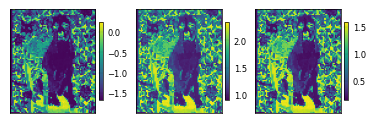

In [36]:
embeddings(encode, shape_=image.shape[0:2], figsize=(4.5, 1.25))


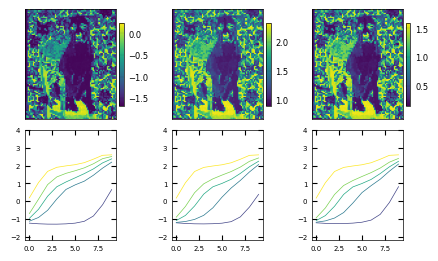

In [37]:
latent_generator(decoder, encode, image, 5, 10, device=device,
                 figsize=(5, 2.5), divider_=False)


In [38]:
latent_dim = 12

# input (batch,)


class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(1, 12, batch_first=True, bidirectional=True)
        self.embedding = nn.Linear(24, self.latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, (_, __) = self.lstm(x)
        x = x[:, -1, :]
        x = self.embedding(x)
        x = self.relu(x)  # add a relu
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(self.latent_dim, 12,
                            batch_first=True, bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
        x = x[:, :, None]
        x = x.transpose(1, 2)
        x = x.repeat([1, 10, 1])
        x, (_, __) = self.lstm(x)
        x = x.transpose(1, 2)
        x = self.tdd(x)
        x = x.transpose(1, 2)
        return x


In [39]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)


In [40]:
model


Autoencoder(
  (encoder): Encoder(
    (lstm): LSTM(1, 12, batch_first=True, bidirectional=True)
    (embedding): Linear(in_features=24, out_features=12, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (lstm): LSTM(12, 12, batch_first=True, bidirectional=True)
    (tdd): Conv1d(24, 1, kernel_size=(1,), stride=(1,))
  )
)

In [41]:
train_iterator = torch.utils.data.DataLoader(
    np.atleast_3d(X_train), batch_size=256, shuffle=False
)


In [42]:
random_seed(seed=42)

Train(
    model,
    encoder,
    decoder,
    train_iterator,
    optimizer,
    500,
    coef=1e-3,
    mse=False,
    device=device,
)


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 149.84it/s]

100%|██████████| 19/19 [00:00<00:00, 151.33it/s]

Epoch 0, Train Loss: 2.1840
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 166.56it/s]

100%|██████████| 19/19 [00:00<00:00, 165.57it/s]

Epoch 1, Train Loss: 2.1752
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.24it/s]

100%|██████████| 19/19 [00:00<00:00, 167.10it/s]

Epoch 2, Train Loss: 2.1666
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 169.80it/s]

100%|██████████| 19/19 [00:00<00:00, 169.88it/s]

Epoch 3, Train Loss: 2.1581
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.32it/s]

100%|██████████| 19/19 [00:00<00:00, 169.89it/s]

Epoch 4, Train Loss: 2.1497
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.43it/s]

100%|██████████| 19/19 [00:00<00:00, 168.08it/s]

Epoch 5, Train Loss: 2.1414
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 214.99it/s]

Epoch 6, Train Loss: 2.1332
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 206.00it/s]

Epoch 7, Train Loss: 2.1250
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 209.18it/s]

Epoch 8, Train Loss: 2.1169
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 206.10it/s]

Epoch 9, Train Loss: 2.1088
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 214.91it/s]

Epoch 10, Train Loss: 2.1007
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 222.25it/s]

Epoch 11, Train Loss: 2.0927
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 215.82it/s]

Epoch 12, Train Loss: 2.0848
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 221.00it/s]

Epoch 13, Train Loss: 2.0770
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 221.95it/s]

Epoch 14, Train Loss: 2.0693
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 174.35it/s]

100%|██████████| 19/19 [00:00<00:00, 172.52it/s]

Epoch 15, Train Loss: 2.0616
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 164.18it/s]

100%|██████████| 19/19 [00:00<00:00, 166.05it/s]

Epoch 16, Train Loss: 2.0540
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 170.20it/s]

100%|██████████| 19/19 [00:00<00:00, 170.74it/s]

Epoch 17, Train Loss: 2.0464
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 164.50it/s]

100%|██████████| 19/19 [00:00<00:00, 165.81it/s]

Epoch 18, Train Loss: 2.0389
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 171.50it/s]

100%|██████████| 19/19 [00:00<00:00, 168.71it/s]

Epoch 19, Train Loss: 2.0315
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 172.71it/s]

100%|██████████| 19/19 [00:00<00:00, 172.60it/s]

Epoch 20, Train Loss: 2.0242
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 165.20it/s]

100%|██████████| 19/19 [00:00<00:00, 166.32it/s]

Epoch 21, Train Loss: 2.0170
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.67it/s]

100%|██████████| 19/19 [00:00<00:00, 167.64it/s]

Epoch 22, Train Loss: 2.0099
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.83it/s]

100%|██████████| 19/19 [00:00<00:00, 168.19it/s]

Epoch 23, Train Loss: 2.0028
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.15it/s]

100%|██████████| 19/19 [00:00<00:00, 168.19it/s]

Epoch 24, Train Loss: 1.9958
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.98it/s]

100%|██████████| 19/19 [00:00<00:00, 165.89it/s]

Epoch 25, Train Loss: 1.9888
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.13it/s]

100%|██████████| 19/19 [00:00<00:00, 163.06it/s]

Epoch 26, Train Loss: 1.9819
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.11it/s]

100%|██████████| 19/19 [00:00<00:00, 167.25it/s]

Epoch 27, Train Loss: 1.9749
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 164.79it/s]

100%|██████████| 19/19 [00:00<00:00, 165.43it/s]

Epoch 28, Train Loss: 1.9679
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 164.78it/s]

100%|██████████| 19/19 [00:00<00:00, 161.31it/s]

Epoch 29, Train Loss: 1.9611
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 170.24it/s]

100%|██████████| 19/19 [00:00<00:00, 170.90it/s]

Epoch 30, Train Loss: 1.9546
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.80it/s]

100%|██████████| 19/19 [00:00<00:00, 168.01it/s]

Epoch 31, Train Loss: 1.9482
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 164.80it/s]

100%|██████████| 19/19 [00:00<00:00, 165.58it/s]

Epoch 32, Train Loss: 1.9419
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.30it/s]

100%|██████████| 19/19 [00:00<00:00, 166.44it/s]

Epoch 33, Train Loss: 1.9357
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 174.13it/s]

100%|██████████| 19/19 [00:00<00:00, 172.32it/s]

Epoch 34, Train Loss: 1.9296
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 170.43it/s]

100%|██████████| 19/19 [00:00<00:00, 170.98it/s]

Epoch 35, Train Loss: 1.9235
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 169.57it/s]

100%|██████████| 19/19 [00:00<00:00, 169.94it/s]

Epoch 36, Train Loss: 1.9176
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 165.55it/s]

100%|██████████| 19/19 [00:00<00:00, 166.44it/s]

Epoch 37, Train Loss: 1.9117
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.98it/s]

100%|██████████| 19/19 [00:00<00:00, 167.15it/s]

Epoch 38, Train Loss: 1.9058
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.15it/s]

100%|██████████| 19/19 [00:00<00:00, 166.26it/s]

Epoch 39, Train Loss: 1.8999
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 163.96it/s]

100%|██████████| 19/19 [00:00<00:00, 164.99it/s]

Epoch 40, Train Loss: 1.8940
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.85it/s]

100%|██████████| 19/19 [00:00<00:00, 164.69it/s]

Epoch 41, Train Loss: 1.8882
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 170.75it/s]

100%|██████████| 19/19 [00:00<00:00, 171.29it/s]

Epoch 42, Train Loss: 1.8824
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 171.53it/s]

100%|██████████| 19/19 [00:00<00:00, 171.20it/s]

Epoch 43, Train Loss: 1.8766
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 165.38it/s]

100%|██████████| 19/19 [00:00<00:00, 162.81it/s]

Epoch 44, Train Loss: 1.8707
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.47it/s]

100%|██████████| 19/19 [00:00<00:00, 166.38it/s]

Epoch 45, Train Loss: 1.8648
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 172.62it/s]

100%|██████████| 19/19 [00:00<00:00, 170.46it/s]

Epoch 46, Train Loss: 1.8589
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 163.79it/s]

100%|██████████| 19/19 [00:00<00:00, 162.06it/s]

Epoch 47, Train Loss: 1.8534
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.95it/s]

100%|██████████| 19/19 [00:00<00:00, 164.04it/s]

Epoch 48, Train Loss: 1.8478
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.81it/s]

100%|██████████| 19/19 [00:00<00:00, 171.18it/s]

Epoch 49, Train Loss: 1.8423
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.84it/s]

100%|██████████| 19/19 [00:00<00:00, 165.95it/s]

Epoch 50, Train Loss: 1.8367
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.84it/s]

100%|██████████| 19/19 [00:00<00:00, 166.31it/s]

Epoch 51, Train Loss: 1.8312
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 172.95it/s]

100%|██████████| 19/19 [00:00<00:00, 171.59it/s]

Epoch 52, Train Loss: 1.8255
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 172.95it/s]

100%|██████████| 19/19 [00:00<00:00, 172.53it/s]

Epoch 53, Train Loss: 1.8199
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 206.55it/s]

Epoch 54, Train Loss: 1.8141
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 209.04it/s]

Epoch 55, Train Loss: 1.8082
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 173.81it/s]

100%|██████████| 19/19 [00:00<00:00, 171.92it/s]

Epoch 56, Train Loss: 1.8023
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.43it/s]

100%|██████████| 19/19 [00:00<00:00, 167.42it/s]

Epoch 57, Train Loss: 1.7962
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.81it/s]

100%|██████████| 19/19 [00:00<00:00, 169.62it/s]

Epoch 58, Train Loss: 1.7900
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.99it/s]

Epoch 59, Train Loss: 1.7837
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.32it/s]

Epoch 60, Train Loss: 1.7773
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 177.93it/s]

100%|██████████| 19/19 [00:00<00:00, 178.05it/s]

Epoch 61, Train Loss: 1.7707
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 172.23it/s]

100%|██████████| 19/19 [00:00<00:00, 172.33it/s]

Epoch 62, Train Loss: 1.7640
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.83it/s]

Epoch 63, Train Loss: 1.7573
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.86it/s]

Epoch 64, Train Loss: 1.7504
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 207.43it/s]

Epoch 65, Train Loss: 1.7435
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 220.55it/s]

Epoch 66, Train Loss: 1.7365
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 215.56it/s]

Epoch 67, Train Loss: 1.7294
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 220.05it/s]

Epoch 68, Train Loss: 1.7221
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 207.88it/s]

Epoch 69, Train Loss: 1.7147
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 208.51it/s]

Epoch 70, Train Loss: 1.7072
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 215.11it/s]

Epoch 71, Train Loss: 1.6994
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 221.88it/s]

Epoch 72, Train Loss: 1.6916
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 210.68it/s]

Epoch 73, Train Loss: 1.6836
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 205.95it/s]

Epoch 74, Train Loss: 1.6754
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 214.25it/s]

Epoch 75, Train Loss: 1.6672
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 207.17it/s]

Epoch 76, Train Loss: 1.6588
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 215.62it/s]

Epoch 77, Train Loss: 1.6503
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 212.82it/s]

Epoch 78, Train Loss: 1.6416
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 215.56it/s]

Epoch 79, Train Loss: 1.6329
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 214.61it/s]

Epoch 80, Train Loss: 1.6240
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 209.93it/s]

Epoch 81, Train Loss: 1.6150
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 205.95it/s]

Epoch 82, Train Loss: 1.6059
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 215.36it/s]

Epoch 83, Train Loss: 1.5967
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 215.04it/s]

Epoch 84, Train Loss: 1.5875
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 214.48it/s]

Epoch 85, Train Loss: 1.5781
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 219.18it/s]

Epoch 86, Train Loss: 1.5686
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 209.22it/s]

Epoch 87, Train Loss: 1.5590
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 212.97it/s]

Epoch 88, Train Loss: 1.5493
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.05it/s]

Epoch 89, Train Loss: 1.5394
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.05it/s]

100%|██████████| 19/19 [00:00<00:00, 169.78it/s]

Epoch 90, Train Loss: 1.5295
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.27it/s]

100%|██████████| 19/19 [00:00<00:00, 165.57it/s]

Epoch 91, Train Loss: 1.5194
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.41it/s]

100%|██████████| 19/19 [00:00<00:00, 164.66it/s]

Epoch 92, Train Loss: 1.5093
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.07it/s]

100%|██████████| 19/19 [00:00<00:00, 164.31it/s]

Epoch 93, Train Loss: 1.4992
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 171.66it/s]

100%|██████████| 19/19 [00:00<00:00, 170.16it/s]

Epoch 94, Train Loss: 1.4890
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 165.21it/s]

100%|██████████| 19/19 [00:00<00:00, 165.03it/s]

Epoch 95, Train Loss: 1.4787
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.13it/s]

100%|██████████| 19/19 [00:00<00:00, 166.50it/s]

Epoch 96, Train Loss: 1.4684
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 161.70it/s]

100%|██████████| 19/19 [00:00<00:00, 162.43it/s]

Epoch 97, Train Loss: 1.4581
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 172.07it/s]

100%|██████████| 19/19 [00:00<00:00, 172.32it/s]

Epoch 98, Train Loss: 1.4478
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 190.15it/s]

Epoch 99, Train Loss: 1.4376
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.95it/s]

100%|██████████| 19/19 [00:00<00:00, 166.22it/s]

Epoch 100, Train Loss: 1.4273
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 163.39it/s]

100%|██████████| 19/19 [00:00<00:00, 165.16it/s]

Epoch 101, Train Loss: 1.4171
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.27it/s]

100%|██████████| 19/19 [00:00<00:00, 169.55it/s]

Epoch 102, Train Loss: 1.4069
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 165.20it/s]

100%|██████████| 19/19 [00:00<00:00, 164.02it/s]

Epoch 103, Train Loss: 1.3967
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 165.05it/s]

100%|██████████| 19/19 [00:00<00:00, 164.52it/s]

Epoch 104, Train Loss: 1.3866
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.04it/s]

100%|██████████| 19/19 [00:00<00:00, 166.95it/s]

Epoch 105, Train Loss: 1.3766
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 169.95it/s]

100%|██████████| 19/19 [00:00<00:00, 168.45it/s]

Epoch 106, Train Loss: 1.3667
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.56it/s]

100%|██████████| 19/19 [00:00<00:00, 168.14it/s]

Epoch 107, Train Loss: 1.3568
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 169.78it/s]

100%|██████████| 19/19 [00:00<00:00, 170.01it/s]

Epoch 108, Train Loss: 1.3470
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 162.98it/s]

100%|██████████| 19/19 [00:00<00:00, 161.47it/s]

Epoch 109, Train Loss: 1.3373
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 170.75it/s]

100%|██████████| 19/19 [00:00<00:00, 171.14it/s]

Epoch 110, Train Loss: 1.3277
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.39it/s]

100%|██████████| 19/19 [00:00<00:00, 166.86it/s]

Epoch 111, Train Loss: 1.3182
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 163.49it/s]

100%|██████████| 19/19 [00:00<00:00, 165.10it/s]

Epoch 112, Train Loss: 1.3088
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 176.76it/s]

100%|██████████| 19/19 [00:00<00:00, 177.93it/s]

Epoch 113, Train Loss: 1.2995
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 219.10it/s]

Epoch 114, Train Loss: 1.2902
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 221.72it/s]

Epoch 115, Train Loss: 1.2811
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 216.17it/s]

Epoch 116, Train Loss: 1.2720
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 221.46it/s]

Epoch 117, Train Loss: 1.2630
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 212.78it/s]

Epoch 118, Train Loss: 1.2542
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 215.54it/s]

Epoch 119, Train Loss: 1.2455
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 221.24it/s]

Epoch 120, Train Loss: 1.2369
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 221.32it/s]

Epoch 121, Train Loss: 1.2286
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 206.59it/s]

Epoch 122, Train Loss: 1.2203
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 216.38it/s]

Epoch 123, Train Loss: 1.2123
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 209.05it/s]

Epoch 124, Train Loss: 1.2043
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 207.88it/s]

Epoch 125, Train Loss: 1.1966
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 208.67it/s]

Epoch 126, Train Loss: 1.1890
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 211.70it/s]

Epoch 127, Train Loss: 1.1816
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 214.77it/s]

Epoch 128, Train Loss: 1.1743
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 198.92it/s]

Epoch 129, Train Loss: 1.1672
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 221.80it/s]

Epoch 130, Train Loss: 1.1602
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 221.68it/s]

Epoch 131, Train Loss: 1.1534
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 206.91it/s]

Epoch 132, Train Loss: 1.1468
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 216.40it/s]

Epoch 133, Train Loss: 1.1404
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 215.32it/s]

Epoch 134, Train Loss: 1.1341
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 208.35it/s]

Epoch 135, Train Loss: 1.1279
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 213.85it/s]

Epoch 136, Train Loss: 1.1219
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 214.76it/s]

Epoch 137, Train Loss: 1.1161
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 214.27it/s]

Epoch 138, Train Loss: 1.1103
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 221.19it/s]

Epoch 139, Train Loss: 1.1048
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 221.34it/s]

Epoch 140, Train Loss: 1.0993
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 215.09it/s]

Epoch 141, Train Loss: 1.0940
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 215.47it/s]

Epoch 142, Train Loss: 1.0888
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 209.08it/s]

Epoch 143, Train Loss: 1.0837
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 209.98it/s]

Epoch 144, Train Loss: 1.0787
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 214.28it/s]

Epoch 145, Train Loss: 1.0738
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 208.10it/s]

Epoch 146, Train Loss: 1.0690
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 221.86it/s]

Epoch 147, Train Loss: 1.0642
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 186.51it/s]

100%|██████████| 19/19 [00:00<00:00, 185.49it/s]

Epoch 148, Train Loss: 1.0595
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 169.78it/s]

100%|██████████| 19/19 [00:00<00:00, 170.38it/s]

Epoch 149, Train Loss: 1.0549
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.71it/s]

100%|██████████| 19/19 [00:00<00:00, 168.30it/s]

Epoch 150, Train Loss: 1.0502
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.13it/s]

100%|██████████| 19/19 [00:00<00:00, 163.89it/s]

Epoch 151, Train Loss: 1.0457
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.35it/s]

100%|██████████| 19/19 [00:00<00:00, 167.62it/s]

Epoch 152, Train Loss: 1.0411
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.47it/s]

100%|██████████| 19/19 [00:00<00:00, 166.50it/s]

Epoch 153, Train Loss: 1.0365
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.12it/s]

100%|██████████| 19/19 [00:00<00:00, 169.51it/s]

Epoch 154, Train Loss: 1.0319
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 164.30it/s]

100%|██████████| 19/19 [00:00<00:00, 163.01it/s]

Epoch 155, Train Loss: 1.0273
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 165.71it/s]

100%|██████████| 19/19 [00:00<00:00, 164.08it/s]

Epoch 156, Train Loss: 1.0226
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.74it/s]

100%|██████████| 19/19 [00:00<00:00, 167.84it/s]

Epoch 157, Train Loss: 1.0179
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.13it/s]

100%|██████████| 19/19 [00:00<00:00, 165.15it/s]

Epoch 158, Train Loss: 1.0130
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.52it/s]

100%|██████████| 19/19 [00:00<00:00, 165.52it/s]

Epoch 159, Train Loss: 1.0081
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.15it/s]

100%|██████████| 19/19 [00:00<00:00, 165.53it/s]

Epoch 160, Train Loss: 1.0030
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 165.44it/s]

100%|██████████| 19/19 [00:00<00:00, 167.02it/s]

Epoch 161, Train Loss: 0.9977
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.94it/s]

100%|██████████| 19/19 [00:00<00:00, 168.03it/s]

Epoch 162, Train Loss: 0.9923
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.57it/s]

100%|██████████| 19/19 [00:00<00:00, 167.56it/s]

Epoch 163, Train Loss: 0.9866
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.72it/s]

100%|██████████| 19/19 [00:00<00:00, 168.39it/s]

Epoch 164, Train Loss: 0.9807
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 164.47it/s]

100%|██████████| 19/19 [00:00<00:00, 163.54it/s]

Epoch 165, Train Loss: 0.9745
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.51it/s]

100%|██████████| 19/19 [00:00<00:00, 167.03it/s]

Epoch 166, Train Loss: 0.9680
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 165.69it/s]

100%|██████████| 19/19 [00:00<00:00, 166.85it/s]

Epoch 167, Train Loss: 0.9611
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 161.59it/s]

100%|██████████| 19/19 [00:00<00:00, 163.13it/s]

Epoch 168, Train Loss: 0.9538
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.89it/s]

100%|██████████| 19/19 [00:00<00:00, 169.92it/s]

Epoch 169, Train Loss: 0.9460
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.32it/s]

100%|██████████| 19/19 [00:00<00:00, 166.09it/s]

Epoch 170, Train Loss: 0.9377
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.08it/s]

100%|██████████| 19/19 [00:00<00:00, 166.06it/s]

Epoch 171, Train Loss: 0.9289
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 165.41it/s]

100%|██████████| 19/19 [00:00<00:00, 166.87it/s]

Epoch 172, Train Loss: 0.9194
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 164.94it/s]

100%|██████████| 19/19 [00:00<00:00, 162.68it/s]

Epoch 173, Train Loss: 0.9092
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.10it/s]

100%|██████████| 19/19 [00:00<00:00, 165.66it/s]

Epoch 174, Train Loss: 0.8983
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 165.86it/s]

100%|██████████| 19/19 [00:00<00:00, 165.46it/s]

Epoch 175, Train Loss: 0.8866
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.91it/s]

100%|██████████| 19/19 [00:00<00:00, 167.79it/s]

Epoch 176, Train Loss: 0.8741
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 170.80it/s]

100%|██████████| 19/19 [00:00<00:00, 169.17it/s]

Epoch 177, Train Loss: 0.8608
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 162.63it/s]

100%|██████████| 19/19 [00:00<00:00, 161.57it/s]

Epoch 178, Train Loss: 0.8466
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 170.44it/s]

100%|██████████| 19/19 [00:00<00:00, 168.77it/s]

Epoch 179, Train Loss: 0.8315
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.40it/s]

100%|██████████| 19/19 [00:00<00:00, 170.45it/s]

Epoch 180, Train Loss: 0.8156
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 171.77it/s]

100%|██████████| 19/19 [00:00<00:00, 170.01it/s]

Epoch 181, Train Loss: 0.7990
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 171.77it/s]

100%|██████████| 19/19 [00:00<00:00, 171.93it/s]

Epoch 182, Train Loss: 0.7817
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.20it/s]

100%|██████████| 19/19 [00:00<00:00, 169.05it/s]

Epoch 183, Train Loss: 0.7639
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.08it/s]

100%|██████████| 19/19 [00:00<00:00, 165.77it/s]

Epoch 184, Train Loss: 0.7454
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.77it/s]

100%|██████████| 19/19 [00:00<00:00, 167.16it/s]

Epoch 185, Train Loss: 0.7260
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.95it/s]

100%|██████████| 19/19 [00:00<00:00, 169.40it/s]

Epoch 186, Train Loss: 0.7059
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 176.86it/s]

100%|██████████| 19/19 [00:00<00:00, 177.18it/s]

Epoch 187, Train Loss: 0.6858
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 181.11it/s]

100%|██████████| 19/19 [00:00<00:00, 180.26it/s]

Epoch 188, Train Loss: 0.6661
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.56it/s]

100%|██████████| 19/19 [00:00<00:00, 169.00it/s]

Epoch 189, Train Loss: 0.6470
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.06it/s]

100%|██████████| 19/19 [00:00<00:00, 167.02it/s]

Epoch 190, Train Loss: 0.6288
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 170.64it/s]

100%|██████████| 19/19 [00:00<00:00, 168.78it/s]

Epoch 191, Train Loss: 0.6115
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 175.83it/s]

100%|██████████| 19/19 [00:00<00:00, 176.01it/s]

Epoch 192, Train Loss: 0.5953
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 170.74it/s]

100%|██████████| 19/19 [00:00<00:00, 170.80it/s]

Epoch 193, Train Loss: 0.5802
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 172.47it/s]

100%|██████████| 19/19 [00:00<00:00, 170.57it/s]

Epoch 194, Train Loss: 0.5660
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.86it/s]

100%|██████████| 19/19 [00:00<00:00, 166.82it/s]

Epoch 195, Train Loss: 0.5529
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 173.33it/s]

100%|██████████| 19/19 [00:00<00:00, 171.48it/s]

Epoch 196, Train Loss: 0.5406
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.66it/s]

100%|██████████| 19/19 [00:00<00:00, 167.54it/s]

Epoch 197, Train Loss: 0.5293
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.65it/s]

100%|██████████| 19/19 [00:00<00:00, 168.63it/s]

Epoch 198, Train Loss: 0.5187
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.04it/s]

100%|██████████| 19/19 [00:00<00:00, 169.78it/s]

Epoch 199, Train Loss: 0.5089
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.75it/s]

100%|██████████| 19/19 [00:00<00:00, 169.22it/s]

Epoch 200, Train Loss: 0.4998
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.55it/s]

100%|██████████| 19/19 [00:00<00:00, 167.07it/s]

Epoch 201, Train Loss: 0.4913
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 172.11it/s]

100%|██████████| 19/19 [00:00<00:00, 172.69it/s]

Epoch 202, Train Loss: 0.4834
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 171.19it/s]

100%|██████████| 19/19 [00:00<00:00, 169.52it/s]

Epoch 203, Train Loss: 0.4760
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.45it/s]

100%|██████████| 19/19 [00:00<00:00, 168.84it/s]

Epoch 204, Train Loss: 0.4690
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.76it/s]

100%|██████████| 19/19 [00:00<00:00, 167.74it/s]

Epoch 205, Train Loss: 0.4625
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 171.80it/s]

100%|██████████| 19/19 [00:00<00:00, 170.31it/s]

Epoch 206, Train Loss: 0.4565
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.47it/s]

100%|██████████| 19/19 [00:00<00:00, 169.91it/s]

Epoch 207, Train Loss: 0.4507
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 170.80it/s]

100%|██████████| 19/19 [00:00<00:00, 169.11it/s]

Epoch 208, Train Loss: 0.4453
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.51it/s]

100%|██████████| 19/19 [00:00<00:00, 162.64it/s]

Epoch 209, Train Loss: 0.4403
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.39it/s]

100%|██████████| 19/19 [00:00<00:00, 166.59it/s]

Epoch 210, Train Loss: 0.4355
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.71it/s]

100%|██████████| 19/19 [00:00<00:00, 165.27it/s]

Epoch 211, Train Loss: 0.4309
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.56it/s]

100%|██████████| 19/19 [00:00<00:00, 169.48it/s]

Epoch 212, Train Loss: 0.4266
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.67it/s]

100%|██████████| 19/19 [00:00<00:00, 168.43it/s]

Epoch 213, Train Loss: 0.4225
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.24it/s]

100%|██████████| 19/19 [00:00<00:00, 169.28it/s]

Epoch 214, Train Loss: 0.4187
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.20it/s]

100%|██████████| 19/19 [00:00<00:00, 168.64it/s]

Epoch 215, Train Loss: 0.4150
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.73it/s]

100%|██████████| 19/19 [00:00<00:00, 171.04it/s]

Epoch 216, Train Loss: 0.4116
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 163.26it/s]

100%|██████████| 19/19 [00:00<00:00, 161.13it/s]

Epoch 217, Train Loss: 0.4083
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 164.96it/s]

100%|██████████| 19/19 [00:00<00:00, 166.19it/s]

Epoch 218, Train Loss: 0.4051
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.02it/s]

100%|██████████| 19/19 [00:00<00:00, 166.79it/s]

Epoch 219, Train Loss: 0.4022
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.76it/s]

100%|██████████| 19/19 [00:00<00:00, 169.55it/s]

Epoch 220, Train Loss: 0.3993
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.46it/s]

100%|██████████| 19/19 [00:00<00:00, 168.61it/s]

Epoch 221, Train Loss: 0.3966
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.02it/s]

100%|██████████| 19/19 [00:00<00:00, 166.98it/s]

Epoch 222, Train Loss: 0.3941
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 169.62it/s]

100%|██████████| 19/19 [00:00<00:00, 168.75it/s]

Epoch 223, Train Loss: 0.3916
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.91it/s]

100%|██████████| 19/19 [00:00<00:00, 165.86it/s]

Epoch 224, Train Loss: 0.3893
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.62it/s]

100%|██████████| 19/19 [00:00<00:00, 168.85it/s]

Epoch 225, Train Loss: 0.3871
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 172.58it/s]

100%|██████████| 19/19 [00:00<00:00, 172.38it/s]

Epoch 226, Train Loss: 0.3850
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.61it/s]

100%|██████████| 19/19 [00:00<00:00, 163.88it/s]

Epoch 227, Train Loss: 0.3829
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.68it/s]

100%|██████████| 19/19 [00:00<00:00, 167.99it/s]

Epoch 228, Train Loss: 0.3810
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.60it/s]

100%|██████████| 19/19 [00:00<00:00, 169.51it/s]

Epoch 229, Train Loss: 0.3792
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 172.39it/s]

100%|██████████| 19/19 [00:00<00:00, 170.91it/s]

Epoch 230, Train Loss: 0.3774
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 170.48it/s]

100%|██████████| 19/19 [00:00<00:00, 170.14it/s]

Epoch 231, Train Loss: 0.3757
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.35it/s]

100%|██████████| 19/19 [00:00<00:00, 168.96it/s]

Epoch 232, Train Loss: 0.3740
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 164.11it/s]

100%|██████████| 19/19 [00:00<00:00, 162.97it/s]

Epoch 233, Train Loss: 0.3724
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 169.37it/s]

100%|██████████| 19/19 [00:00<00:00, 167.79it/s]

Epoch 234, Train Loss: 0.3709
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.88it/s]

100%|██████████| 19/19 [00:00<00:00, 167.82it/s]

Epoch 235, Train Loss: 0.3694
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.64it/s]

100%|██████████| 19/19 [00:00<00:00, 167.57it/s]

Epoch 236, Train Loss: 0.3680
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.48it/s]

100%|██████████| 19/19 [00:00<00:00, 163.36it/s]

Epoch 237, Train Loss: 0.3666
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.04it/s]

100%|██████████| 19/19 [00:00<00:00, 169.32it/s]

Epoch 238, Train Loss: 0.3652
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.70it/s]

100%|██████████| 19/19 [00:00<00:00, 167.77it/s]

Epoch 239, Train Loss: 0.3639
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.85it/s]

100%|██████████| 19/19 [00:00<00:00, 170.97it/s]

Epoch 240, Train Loss: 0.3626
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 172.04it/s]

100%|██████████| 19/19 [00:00<00:00, 172.62it/s]

Epoch 241, Train Loss: 0.3614
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 164.19it/s]

100%|██████████| 19/19 [00:00<00:00, 162.72it/s]

Epoch 242, Train Loss: 0.3601
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 169.24it/s]

100%|██████████| 19/19 [00:00<00:00, 169.84it/s]

Epoch 243, Train Loss: 0.3590
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 164.17it/s]

100%|██████████| 19/19 [00:00<00:00, 165.55it/s]

Epoch 244, Train Loss: 0.3578
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.74it/s]

100%|██████████| 19/19 [00:00<00:00, 168.70it/s]

Epoch 245, Train Loss: 0.3566
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 164.83it/s]

100%|██████████| 19/19 [00:00<00:00, 162.72it/s]

Epoch 246, Train Loss: 0.3555
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.04it/s]

100%|██████████| 19/19 [00:00<00:00, 167.40it/s]

Epoch 247, Train Loss: 0.3544
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.85it/s]

100%|██████████| 19/19 [00:00<00:00, 169.77it/s]

Epoch 248, Train Loss: 0.3533
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 173.37it/s]

100%|██████████| 19/19 [00:00<00:00, 171.50it/s]

Epoch 249, Train Loss: 0.3523
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.52it/s]

100%|██████████| 19/19 [00:00<00:00, 167.03it/s]

Epoch 250, Train Loss: 0.3513
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 165.82it/s]

100%|██████████| 19/19 [00:00<00:00, 167.02it/s]

Epoch 251, Train Loss: 0.3502
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 162.49it/s]

100%|██████████| 19/19 [00:00<00:00, 161.11it/s]

Epoch 252, Train Loss: 0.3492
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.70it/s]

100%|██████████| 19/19 [00:00<00:00, 167.02it/s]

Epoch 253, Train Loss: 0.3483
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 170.72it/s]

100%|██████████| 19/19 [00:00<00:00, 171.00it/s]

Epoch 254, Train Loss: 0.3473
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.22it/s]

100%|██████████| 19/19 [00:00<00:00, 167.75it/s]

Epoch 255, Train Loss: 0.3463
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.32it/s]

100%|██████████| 19/19 [00:00<00:00, 167.49it/s]

Epoch 256, Train Loss: 0.3454
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.72it/s]

100%|██████████| 19/19 [00:00<00:00, 165.13it/s]

Epoch 257, Train Loss: 0.3445
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.31it/s]

100%|██████████| 19/19 [00:00<00:00, 169.72it/s]

Epoch 258, Train Loss: 0.3436
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.18it/s]

100%|██████████| 19/19 [00:00<00:00, 167.77it/s]

Epoch 259, Train Loss: 0.3427
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 165.36it/s]

100%|██████████| 19/19 [00:00<00:00, 164.02it/s]

Epoch 260, Train Loss: 0.3418
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.83it/s]

100%|██████████| 19/19 [00:00<00:00, 168.80it/s]

Epoch 261, Train Loss: 0.3409
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 170.46it/s]

100%|██████████| 19/19 [00:00<00:00, 170.67it/s]

Epoch 262, Train Loss: 0.3400
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.98it/s]

100%|██████████| 19/19 [00:00<00:00, 169.23it/s]

Epoch 263, Train Loss: 0.3391
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.91it/s]

100%|██████████| 19/19 [00:00<00:00, 166.06it/s]

Epoch 264, Train Loss: 0.3383
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 164.93it/s]

100%|██████████| 19/19 [00:00<00:00, 166.83it/s]

Epoch 265, Train Loss: 0.3374
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 169.14it/s]

100%|██████████| 19/19 [00:00<00:00, 169.33it/s]

Epoch 266, Train Loss: 0.3366
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.99it/s]

100%|██████████| 19/19 [00:00<00:00, 169.86it/s]

Epoch 267, Train Loss: 0.3357
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 172.04it/s]

100%|██████████| 19/19 [00:00<00:00, 170.36it/s]

Epoch 268, Train Loss: 0.3349
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.60it/s]

100%|██████████| 19/19 [00:00<00:00, 170.55it/s]

Epoch 269, Train Loss: 0.3341
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 171.21it/s]

100%|██████████| 19/19 [00:00<00:00, 171.41it/s]

Epoch 270, Train Loss: 0.3333
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 171.15it/s]

100%|██████████| 19/19 [00:00<00:00, 171.76it/s]

Epoch 271, Train Loss: 0.3325
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 170.88it/s]

100%|██████████| 19/19 [00:00<00:00, 170.17it/s]

Epoch 272, Train Loss: 0.3317
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.21it/s]

100%|██████████| 19/19 [00:00<00:00, 166.71it/s]

Epoch 273, Train Loss: 0.3309
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.25it/s]

100%|██████████| 19/19 [00:00<00:00, 166.54it/s]

Epoch 274, Train Loss: 0.3302
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 162.57it/s]

100%|██████████| 19/19 [00:00<00:00, 163.99it/s]

Epoch 275, Train Loss: 0.3294
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.80it/s]

100%|██████████| 19/19 [00:00<00:00, 165.13it/s]

Epoch 276, Train Loss: 0.3286
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.02it/s]

100%|██████████| 19/19 [00:00<00:00, 169.63it/s]

Epoch 277, Train Loss: 0.3278
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 163.86it/s]

100%|██████████| 19/19 [00:00<00:00, 162.81it/s]

Epoch 278, Train Loss: 0.3271
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.66it/s]

100%|██████████| 19/19 [00:00<00:00, 169.29it/s]

Epoch 279, Train Loss: 0.3263
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 165.84it/s]

100%|██████████| 19/19 [00:00<00:00, 165.14it/s]

Epoch 280, Train Loss: 0.3256
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 163.81it/s]

100%|██████████| 19/19 [00:00<00:00, 165.48it/s]

Epoch 281, Train Loss: 0.3248
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.58it/s]

100%|██████████| 19/19 [00:00<00:00, 167.06it/s]

Epoch 282, Train Loss: 0.3241
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 164.98it/s]

100%|██████████| 19/19 [00:00<00:00, 165.32it/s]

Epoch 283, Train Loss: 0.3234
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 165.89it/s]

100%|██████████| 19/19 [00:00<00:00, 167.47it/s]

Epoch 284, Train Loss: 0.3226
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.99it/s]

100%|██████████| 19/19 [00:00<00:00, 166.77it/s]

Epoch 285, Train Loss: 0.3219
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 163.21it/s]

100%|██████████| 19/19 [00:00<00:00, 161.48it/s]

Epoch 286, Train Loss: 0.3212
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.92it/s]

100%|██████████| 19/19 [00:00<00:00, 166.58it/s]

Epoch 287, Train Loss: 0.3205
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 173.65it/s]

100%|██████████| 19/19 [00:00<00:00, 171.96it/s]

Epoch 288, Train Loss: 0.3198
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.75it/s]

100%|██████████| 19/19 [00:00<00:00, 167.07it/s]

Epoch 289, Train Loss: 0.3191
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 170.42it/s]

100%|██████████| 19/19 [00:00<00:00, 170.29it/s]

Epoch 290, Train Loss: 0.3184
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 171.34it/s]

100%|██████████| 19/19 [00:00<00:00, 171.67it/s]

Epoch 291, Train Loss: 0.3177
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.69it/s]

100%|██████████| 19/19 [00:00<00:00, 166.47it/s]

Epoch 292, Train Loss: 0.3170
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 164.32it/s]

100%|██████████| 19/19 [00:00<00:00, 162.39it/s]

Epoch 293, Train Loss: 0.3163
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 156.07it/s]

100%|██████████| 19/19 [00:00<00:00, 155.91it/s]

Epoch 294, Train Loss: 0.3157
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 164.13it/s]

100%|██████████| 19/19 [00:00<00:00, 162.66it/s]

Epoch 295, Train Loss: 0.3150
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 165.77it/s]

100%|██████████| 19/19 [00:00<00:00, 167.73it/s]

Epoch 296, Train Loss: 0.3144
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 175.87it/s]

100%|██████████| 19/19 [00:00<00:00, 174.29it/s]

Epoch 297, Train Loss: 0.3137
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 186.56it/s]

100%|██████████| 19/19 [00:00<00:00, 185.84it/s]

Epoch 298, Train Loss: 0.3131
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.59it/s]

100%|██████████| 19/19 [00:00<00:00, 169.95it/s]

Epoch 299, Train Loss: 0.3125
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.13it/s]

100%|██████████| 19/19 [00:00<00:00, 162.63it/s]

Epoch 300, Train Loss: 0.3119
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 169.15it/s]

100%|██████████| 19/19 [00:00<00:00, 169.70it/s]

Epoch 301, Train Loss: 0.3113
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.52it/s]

100%|██████████| 19/19 [00:00<00:00, 167.53it/s]

Epoch 302, Train Loss: 0.3107
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.60it/s]

100%|██████████| 19/19 [00:00<00:00, 165.22it/s]

Epoch 303, Train Loss: 0.3101
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 163.98it/s]

100%|██████████| 19/19 [00:00<00:00, 164.52it/s]

Epoch 304, Train Loss: 0.3095
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.54it/s]

100%|██████████| 19/19 [00:00<00:00, 168.10it/s]

Epoch 305, Train Loss: 0.3090
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.88it/s]

100%|██████████| 19/19 [00:00<00:00, 167.98it/s]

Epoch 306, Train Loss: 0.3084
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 162.48it/s]

100%|██████████| 19/19 [00:00<00:00, 161.21it/s]

Epoch 307, Train Loss: 0.3079
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 164.97it/s]

100%|██████████| 19/19 [00:00<00:00, 163.94it/s]

Epoch 308, Train Loss: 0.3073
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.81it/s]

100%|██████████| 19/19 [00:00<00:00, 171.04it/s]

Epoch 309, Train Loss: 0.3068
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.17it/s]

100%|██████████| 19/19 [00:00<00:00, 169.99it/s]

Epoch 310, Train Loss: 0.3063
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.79it/s]

100%|██████████| 19/19 [00:00<00:00, 168.18it/s]

Epoch 311, Train Loss: 0.3058
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.23it/s]

100%|██████████| 19/19 [00:00<00:00, 168.93it/s]

Epoch 312, Train Loss: 0.3053
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.93it/s]

100%|██████████| 19/19 [00:00<00:00, 166.79it/s]

Epoch 313, Train Loss: 0.3048
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 172.57it/s]

100%|██████████| 19/19 [00:00<00:00, 171.91it/s]

Epoch 314, Train Loss: 0.3043
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 171.33it/s]

100%|██████████| 19/19 [00:00<00:00, 169.50it/s]

Epoch 315, Train Loss: 0.3039
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 170.10it/s]

100%|██████████| 19/19 [00:00<00:00, 170.49it/s]

Epoch 316, Train Loss: 0.3034
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.51it/s]

100%|██████████| 19/19 [00:00<00:00, 168.71it/s]

Epoch 317, Train Loss: 0.3029
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.53it/s]

100%|██████████| 19/19 [00:00<00:00, 167.28it/s]

Epoch 318, Train Loss: 0.3025
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.94it/s]

100%|██████████| 19/19 [00:00<00:00, 165.33it/s]

Epoch 319, Train Loss: 0.3020
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 164.46it/s]

100%|██████████| 19/19 [00:00<00:00, 165.58it/s]

Epoch 320, Train Loss: 0.3016
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.73it/s]

100%|██████████| 19/19 [00:00<00:00, 164.52it/s]

Epoch 321, Train Loss: 0.3011
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.55it/s]

100%|██████████| 19/19 [00:00<00:00, 168.29it/s]

Epoch 322, Train Loss: 0.3007
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 173.18it/s]

100%|██████████| 19/19 [00:00<00:00, 171.31it/s]

Epoch 323, Train Loss: 0.3003
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 172.98it/s]

100%|██████████| 19/19 [00:00<00:00, 173.46it/s]

Epoch 324, Train Loss: 0.2998
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 165.56it/s]

100%|██████████| 19/19 [00:00<00:00, 167.74it/s]

Epoch 325, Train Loss: 0.2994
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.47it/s]

100%|██████████| 19/19 [00:00<00:00, 170.45it/s]

Epoch 326, Train Loss: 0.2990
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.18it/s]

100%|██████████| 19/19 [00:00<00:00, 166.31it/s]

Epoch 327, Train Loss: 0.2986
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.64it/s]

100%|██████████| 19/19 [00:00<00:00, 169.48it/s]

Epoch 328, Train Loss: 0.2982
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.94it/s]

100%|██████████| 19/19 [00:00<00:00, 170.60it/s]

Epoch 329, Train Loss: 0.2977
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 158.48it/s]

100%|██████████| 19/19 [00:00<00:00, 160.38it/s]

Epoch 330, Train Loss: 0.2973
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 173.01it/s]

100%|██████████| 19/19 [00:00<00:00, 173.45it/s]

Epoch 331, Train Loss: 0.2969
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.11it/s]

100%|██████████| 19/19 [00:00<00:00, 168.90it/s]

Epoch 332, Train Loss: 0.2965
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 172.26it/s]

100%|██████████| 19/19 [00:00<00:00, 172.43it/s]

Epoch 333, Train Loss: 0.2961
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.93it/s]

100%|██████████| 19/19 [00:00<00:00, 166.52it/s]

Epoch 334, Train Loss: 0.2957
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 172.57it/s]

100%|██████████| 19/19 [00:00<00:00, 170.44it/s]

Epoch 335, Train Loss: 0.2953
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.78it/s]

100%|██████████| 19/19 [00:00<00:00, 168.60it/s]

Epoch 336, Train Loss: 0.2949
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.52it/s]

100%|██████████| 19/19 [00:00<00:00, 167.65it/s]

Epoch 337, Train Loss: 0.2945
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.64it/s]

100%|██████████| 19/19 [00:00<00:00, 166.42it/s]

Epoch 338, Train Loss: 0.2941
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 165.54it/s]

100%|██████████| 19/19 [00:00<00:00, 165.40it/s]

Epoch 339, Train Loss: 0.2937
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.57it/s]

100%|██████████| 19/19 [00:00<00:00, 165.11it/s]

Epoch 340, Train Loss: 0.2933
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 172.25it/s]

100%|██████████| 19/19 [00:00<00:00, 170.28it/s]

Epoch 341, Train Loss: 0.2929
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 170.50it/s]

100%|██████████| 19/19 [00:00<00:00, 170.84it/s]

Epoch 342, Train Loss: 0.2925
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 186.21it/s]

100%|██████████| 19/19 [00:00<00:00, 185.01it/s]

Epoch 343, Train Loss: 0.2921
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 171.49it/s]

100%|██████████| 19/19 [00:00<00:00, 171.68it/s]

Epoch 344, Train Loss: 0.2917
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.79it/s]

100%|██████████| 19/19 [00:00<00:00, 163.73it/s]

Epoch 345, Train Loss: 0.2913
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.98it/s]

100%|██████████| 19/19 [00:00<00:00, 166.86it/s]

Epoch 346, Train Loss: 0.2909
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.15it/s]

100%|██████████| 19/19 [00:00<00:00, 168.16it/s]

Epoch 347, Train Loss: 0.2904
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.87it/s]

100%|██████████| 19/19 [00:00<00:00, 168.03it/s]

Epoch 348, Train Loss: 0.2900
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.05it/s]

100%|██████████| 19/19 [00:00<00:00, 165.77it/s]

Epoch 349, Train Loss: 0.2896
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.24it/s]

100%|██████████| 19/19 [00:00<00:00, 164.06it/s]

Epoch 350, Train Loss: 0.2892
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.37it/s]

100%|██████████| 19/19 [00:00<00:00, 163.96it/s]

Epoch 351, Train Loss: 0.2888
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.46it/s]

100%|██████████| 19/19 [00:00<00:00, 168.66it/s]

Epoch 352, Train Loss: 0.2884
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.01it/s]

100%|██████████| 19/19 [00:00<00:00, 168.90it/s]

Epoch 353, Train Loss: 0.2880
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.87it/s]

100%|██████████| 19/19 [00:00<00:00, 166.74it/s]

Epoch 354, Train Loss: 0.2876
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.04it/s]

100%|██████████| 19/19 [00:00<00:00, 167.03it/s]

Epoch 355, Train Loss: 0.2872
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.21it/s]

100%|██████████| 19/19 [00:00<00:00, 166.51it/s]

Epoch 356, Train Loss: 0.2868
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.32it/s]

100%|██████████| 19/19 [00:00<00:00, 170.34it/s]

Epoch 357, Train Loss: 0.2864
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 174.79it/s]

100%|██████████| 19/19 [00:00<00:00, 172.79it/s]

Epoch 358, Train Loss: 0.2860
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 164.28it/s]

100%|██████████| 19/19 [00:00<00:00, 162.20it/s]

Epoch 359, Train Loss: 0.2856
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.05it/s]

100%|██████████| 19/19 [00:00<00:00, 169.39it/s]

Epoch 360, Train Loss: 0.2852
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.05it/s]

100%|██████████| 19/19 [00:00<00:00, 168.04it/s]

Epoch 361, Train Loss: 0.2848
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 165.68it/s]

100%|██████████| 19/19 [00:00<00:00, 165.90it/s]

Epoch 362, Train Loss: 0.2844
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.72it/s]

100%|██████████| 19/19 [00:00<00:00, 167.01it/s]

Epoch 363, Train Loss: 0.2840
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 159.08it/s]

100%|██████████| 19/19 [00:00<00:00, 157.90it/s]

Epoch 364, Train Loss: 0.2836
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.63it/s]

100%|██████████| 19/19 [00:00<00:00, 169.37it/s]

Epoch 365, Train Loss: 0.2832
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.70it/s]

100%|██████████| 19/19 [00:00<00:00, 165.51it/s]

Epoch 366, Train Loss: 0.2828
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.95it/s]

100%|██████████| 19/19 [00:00<00:00, 166.55it/s]

Epoch 367, Train Loss: 0.2824
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 165.95it/s]

100%|██████████| 19/19 [00:00<00:00, 164.83it/s]

Epoch 368, Train Loss: 0.2820
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.26it/s]

100%|██████████| 19/19 [00:00<00:00, 168.11it/s]

Epoch 369, Train Loss: 0.2816
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 165.72it/s]

100%|██████████| 19/19 [00:00<00:00, 166.28it/s]

Epoch 370, Train Loss: 0.2812
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.01it/s]

100%|██████████| 19/19 [00:00<00:00, 168.28it/s]

Epoch 371, Train Loss: 0.2808
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 163.73it/s]

100%|██████████| 19/19 [00:00<00:00, 161.89it/s]

Epoch 372, Train Loss: 0.2803
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.41it/s]

100%|██████████| 19/19 [00:00<00:00, 165.41it/s]

Epoch 373, Train Loss: 0.2799
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.02it/s]

100%|██████████| 19/19 [00:00<00:00, 166.44it/s]

Epoch 374, Train Loss: 0.2795
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.04it/s]

100%|██████████| 19/19 [00:00<00:00, 165.34it/s]

Epoch 375, Train Loss: 0.2791
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.48it/s]

100%|██████████| 19/19 [00:00<00:00, 164.17it/s]

Epoch 376, Train Loss: 0.2787
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 157.28it/s]

100%|██████████| 19/19 [00:00<00:00, 154.85it/s]

Epoch 377, Train Loss: 0.2783
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 159.80it/s]

100%|██████████| 19/19 [00:00<00:00, 157.94it/s]

Epoch 378, Train Loss: 0.2779
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 160.91it/s]

100%|██████████| 19/19 [00:00<00:00, 162.25it/s]

Epoch 379, Train Loss: 0.2774
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 159.42it/s]

100%|██████████| 19/19 [00:00<00:00, 157.95it/s]

Epoch 380, Train Loss: 0.2770
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 157.91it/s]

100%|██████████| 19/19 [00:00<00:00, 157.83it/s]

Epoch 381, Train Loss: 0.2766
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 158.99it/s]

100%|██████████| 19/19 [00:00<00:00, 156.69it/s]

Epoch 382, Train Loss: 0.2762
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 158.41it/s]

100%|██████████| 19/19 [00:00<00:00, 159.03it/s]

Epoch 383, Train Loss: 0.2758
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 163.56it/s]

100%|██████████| 19/19 [00:00<00:00, 160.12it/s]

Epoch 384, Train Loss: 0.2753
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 158.49it/s]

100%|██████████| 19/19 [00:00<00:00, 156.55it/s]

Epoch 385, Train Loss: 0.2749
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 152.17it/s]

100%|██████████| 19/19 [00:00<00:00, 155.95it/s]

Epoch 386, Train Loss: 0.2745
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 158.02it/s]

100%|██████████| 19/19 [00:00<00:00, 155.91it/s]

Epoch 387, Train Loss: 0.2741
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 164.82it/s]

100%|██████████| 19/19 [00:00<00:00, 162.82it/s]

Epoch 388, Train Loss: 0.2737
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 164.68it/s]

100%|██████████| 19/19 [00:00<00:00, 166.68it/s]

Epoch 389, Train Loss: 0.2733
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.75it/s]

100%|██████████| 19/19 [00:00<00:00, 166.08it/s]

Epoch 390, Train Loss: 0.2729
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 173.65it/s]

100%|██████████| 19/19 [00:00<00:00, 171.76it/s]

Epoch 391, Train Loss: 0.2725
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 171.36it/s]

100%|██████████| 19/19 [00:00<00:00, 169.72it/s]

Epoch 392, Train Loss: 0.2721
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 163.16it/s]

100%|██████████| 19/19 [00:00<00:00, 164.50it/s]

Epoch 393, Train Loss: 0.2716
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 170.34it/s]

100%|██████████| 19/19 [00:00<00:00, 170.54it/s]

Epoch 394, Train Loss: 0.2712
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 171.87it/s]

100%|██████████| 19/19 [00:00<00:00, 169.42it/s]

Epoch 395, Train Loss: 0.2708
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 174.13it/s]

100%|██████████| 19/19 [00:00<00:00, 171.55it/s]

Epoch 396, Train Loss: 0.2704
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.66it/s]

100%|██████████| 19/19 [00:00<00:00, 169.19it/s]

Epoch 397, Train Loss: 0.2700
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.35it/s]

100%|██████████| 19/19 [00:00<00:00, 161.45it/s]

Epoch 398, Train Loss: 0.2696
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 164.73it/s]

100%|██████████| 19/19 [00:00<00:00, 164.01it/s]

Epoch 399, Train Loss: 0.2692
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.73it/s]

100%|██████████| 19/19 [00:00<00:00, 166.36it/s]

Epoch 400, Train Loss: 0.2688
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 165.64it/s]

100%|██████████| 19/19 [00:00<00:00, 163.28it/s]

Epoch 401, Train Loss: 0.2684
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.32it/s]

100%|██████████| 19/19 [00:00<00:00, 166.42it/s]

Epoch 402, Train Loss: 0.2681
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.80it/s]

100%|██████████| 19/19 [00:00<00:00, 167.04it/s]

Epoch 403, Train Loss: 0.2677
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.56it/s]

100%|██████████| 19/19 [00:00<00:00, 165.84it/s]

Epoch 404, Train Loss: 0.2673
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.09it/s]

100%|██████████| 19/19 [00:00<00:00, 166.54it/s]

Epoch 405, Train Loss: 0.2669
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.95it/s]

100%|██████████| 19/19 [00:00<00:00, 170.10it/s]

Epoch 406, Train Loss: 0.2665
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 165.43it/s]

100%|██████████| 19/19 [00:00<00:00, 165.19it/s]

Epoch 407, Train Loss: 0.2661
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 171.09it/s]

100%|██████████| 19/19 [00:00<00:00, 171.59it/s]

Epoch 408, Train Loss: 0.2657
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.57it/s]

100%|██████████| 19/19 [00:00<00:00, 165.07it/s]

Epoch 409, Train Loss: 0.2653
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 165.46it/s]

100%|██████████| 19/19 [00:00<00:00, 165.59it/s]

Epoch 410, Train Loss: 0.2649
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 170.45it/s]

100%|██████████| 19/19 [00:00<00:00, 170.07it/s]

Epoch 411, Train Loss: 0.2645
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.57it/s]

100%|██████████| 19/19 [00:00<00:00, 170.34it/s]

Epoch 412, Train Loss: 0.2641
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.27it/s]

100%|██████████| 19/19 [00:00<00:00, 167.67it/s]

Epoch 413, Train Loss: 0.2638
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 161.47it/s]

100%|██████████| 19/19 [00:00<00:00, 162.74it/s]

Epoch 414, Train Loss: 0.2634
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.85it/s]

100%|██████████| 19/19 [00:00<00:00, 169.39it/s]

Epoch 415, Train Loss: 0.2630
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.71it/s]

100%|██████████| 19/19 [00:00<00:00, 168.36it/s]

Epoch 416, Train Loss: 0.2626
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 161.61it/s]

100%|██████████| 19/19 [00:00<00:00, 163.18it/s]

Epoch 417, Train Loss: 0.2622
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.30it/s]

100%|██████████| 19/19 [00:00<00:00, 166.32it/s]

Epoch 418, Train Loss: 0.2618
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.43it/s]

100%|██████████| 19/19 [00:00<00:00, 166.68it/s]

Epoch 419, Train Loss: 0.2614
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.66it/s]

100%|██████████| 19/19 [00:00<00:00, 167.76it/s]

Epoch 420, Train Loss: 0.2610
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.38it/s]

100%|██████████| 19/19 [00:00<00:00, 168.46it/s]

Epoch 421, Train Loss: 0.2607
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.06it/s]

100%|██████████| 19/19 [00:00<00:00, 168.26it/s]

Epoch 422, Train Loss: 0.2603
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 169.98it/s]

100%|██████████| 19/19 [00:00<00:00, 169.37it/s]

Epoch 423, Train Loss: 0.2599
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.72it/s]

100%|██████████| 19/19 [00:00<00:00, 167.30it/s]

Epoch 424, Train Loss: 0.2595
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 175.40it/s]

100%|██████████| 19/19 [00:00<00:00, 173.49it/s]

Epoch 425, Train Loss: 0.2591
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.71it/s]

100%|██████████| 19/19 [00:00<00:00, 168.98it/s]

Epoch 426, Train Loss: 0.2587
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 165.20it/s]

100%|██████████| 19/19 [00:00<00:00, 166.80it/s]

Epoch 427, Train Loss: 0.2584
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 170.04it/s]

100%|██████████| 19/19 [00:00<00:00, 170.34it/s]

Epoch 428, Train Loss: 0.2580
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 165.90it/s]

100%|██████████| 19/19 [00:00<00:00, 166.82it/s]

Epoch 429, Train Loss: 0.2576
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.23it/s]

100%|██████████| 19/19 [00:00<00:00, 163.81it/s]

Epoch 430, Train Loss: 0.2572
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 173.48it/s]

100%|██████████| 19/19 [00:00<00:00, 171.63it/s]

Epoch 431, Train Loss: 0.2568
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.33it/s]

100%|██████████| 19/19 [00:00<00:00, 167.31it/s]

Epoch 432, Train Loss: 0.2564
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 169.74it/s]

100%|██████████| 19/19 [00:00<00:00, 170.09it/s]

Epoch 433, Train Loss: 0.2561
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 165.88it/s]

100%|██████████| 19/19 [00:00<00:00, 164.53it/s]

Epoch 434, Train Loss: 0.2557
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.64it/s]

100%|██████████| 19/19 [00:00<00:00, 165.36it/s]

Epoch 435, Train Loss: 0.2553
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 172.67it/s]

100%|██████████| 19/19 [00:00<00:00, 172.74it/s]

Epoch 436, Train Loss: 0.2549
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.08it/s]

100%|██████████| 19/19 [00:00<00:00, 167.23it/s]

Epoch 437, Train Loss: 0.2545
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 172.03it/s]

100%|██████████| 19/19 [00:00<00:00, 172.44it/s]

Epoch 438, Train Loss: 0.2541
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 163.06it/s]

100%|██████████| 19/19 [00:00<00:00, 164.47it/s]

Epoch 439, Train Loss: 0.2538
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 164.74it/s]

100%|██████████| 19/19 [00:00<00:00, 165.49it/s]

Epoch 440, Train Loss: 0.2534
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 164.15it/s]

100%|██████████| 19/19 [00:00<00:00, 164.01it/s]

Epoch 441, Train Loss: 0.2530
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 171.29it/s]

100%|██████████| 19/19 [00:00<00:00, 169.69it/s]

Epoch 442, Train Loss: 0.2526
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 169.45it/s]

100%|██████████| 19/19 [00:00<00:00, 169.73it/s]

Epoch 443, Train Loss: 0.2522
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 171.55it/s]

100%|██████████| 19/19 [00:00<00:00, 169.73it/s]

Epoch 444, Train Loss: 0.2519
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.81it/s]

100%|██████████| 19/19 [00:00<00:00, 167.93it/s]

Epoch 445, Train Loss: 0.2515
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.38it/s]

100%|██████████| 19/19 [00:00<00:00, 165.84it/s]

Epoch 446, Train Loss: 0.2511
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.63it/s]

100%|██████████| 19/19 [00:00<00:00, 167.73it/s]

Epoch 447, Train Loss: 0.2507
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.18it/s]

100%|██████████| 19/19 [00:00<00:00, 167.67it/s]

Epoch 448, Train Loss: 0.2503
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.89it/s]

100%|██████████| 19/19 [00:00<00:00, 167.94it/s]

Epoch 449, Train Loss: 0.2499
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 169.55it/s]

100%|██████████| 19/19 [00:00<00:00, 169.86it/s]

Epoch 450, Train Loss: 0.2496
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.90it/s]

100%|██████████| 19/19 [00:00<00:00, 167.22it/s]

Epoch 451, Train Loss: 0.2492
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.19it/s]

100%|██████████| 19/19 [00:00<00:00, 167.46it/s]

Epoch 452, Train Loss: 0.2488
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 164.94it/s]

100%|██████████| 19/19 [00:00<00:00, 162.32it/s]

Epoch 453, Train Loss: 0.2484
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 164.12it/s]

100%|██████████| 19/19 [00:00<00:00, 163.57it/s]

Epoch 454, Train Loss: 0.2481
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.38it/s]

100%|██████████| 19/19 [00:00<00:00, 167.85it/s]

Epoch 455, Train Loss: 0.2477
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 161.87it/s]

100%|██████████| 19/19 [00:00<00:00, 161.13it/s]

Epoch 456, Train Loss: 0.2473
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.76it/s]

100%|██████████| 19/19 [00:00<00:00, 164.26it/s]

Epoch 457, Train Loss: 0.2469
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.11it/s]

100%|██████████| 19/19 [00:00<00:00, 166.41it/s]

Epoch 458, Train Loss: 0.2465
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.19it/s]

100%|██████████| 19/19 [00:00<00:00, 164.88it/s]

Epoch 459, Train Loss: 0.2462
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.17it/s]

100%|██████████| 19/19 [00:00<00:00, 166.73it/s]

Epoch 460, Train Loss: 0.2458
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.59it/s]

100%|██████████| 19/19 [00:00<00:00, 165.68it/s]

Epoch 461, Train Loss: 0.2454
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.34it/s]

100%|██████████| 19/19 [00:00<00:00, 165.19it/s]

Epoch 462, Train Loss: 0.2450
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 171.05it/s]

100%|██████████| 19/19 [00:00<00:00, 170.20it/s]

Epoch 463, Train Loss: 0.2447
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 169.63it/s]

100%|██████████| 19/19 [00:00<00:00, 168.07it/s]

Epoch 464, Train Loss: 0.2443
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.37it/s]

100%|██████████| 19/19 [00:00<00:00, 168.13it/s]

Epoch 465, Train Loss: 0.2439
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 165.01it/s]

100%|██████████| 19/19 [00:00<00:00, 166.74it/s]

Epoch 466, Train Loss: 0.2435
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.35it/s]

100%|██████████| 19/19 [00:00<00:00, 168.12it/s]

Epoch 467, Train Loss: 0.2432
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.69it/s]

100%|██████████| 19/19 [00:00<00:00, 168.20it/s]

Epoch 468, Train Loss: 0.2428
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 171.19it/s]

100%|██████████| 19/19 [00:00<00:00, 171.38it/s]

Epoch 469, Train Loss: 0.2424
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.61it/s]

100%|██████████| 19/19 [00:00<00:00, 167.98it/s]

Epoch 470, Train Loss: 0.2420
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 165.20it/s]

100%|██████████| 19/19 [00:00<00:00, 165.64it/s]

Epoch 471, Train Loss: 0.2417
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 164.94it/s]

100%|██████████| 19/19 [00:00<00:00, 166.74it/s]

Epoch 472, Train Loss: 0.2413
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.36it/s]

100%|██████████| 19/19 [00:00<00:00, 168.47it/s]

Epoch 473, Train Loss: 0.2409
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 170.54it/s]

100%|██████████| 19/19 [00:00<00:00, 170.74it/s]

Epoch 474, Train Loss: 0.2405
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 165.81it/s]

100%|██████████| 19/19 [00:00<00:00, 163.69it/s]

Epoch 475, Train Loss: 0.2402
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 173.35it/s]

100%|██████████| 19/19 [00:00<00:00, 171.49it/s]

Epoch 476, Train Loss: 0.2398
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 165.86it/s]

100%|██████████| 19/19 [00:00<00:00, 163.81it/s]

Epoch 477, Train Loss: 0.2394
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.46it/s]

100%|██████████| 19/19 [00:00<00:00, 167.57it/s]

Epoch 478, Train Loss: 0.2391
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.92it/s]

100%|██████████| 19/19 [00:00<00:00, 168.47it/s]

Epoch 479, Train Loss: 0.2387
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.28it/s]

100%|██████████| 19/19 [00:00<00:00, 167.46it/s]

Epoch 480, Train Loss: 0.2383
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 163.42it/s]

100%|██████████| 19/19 [00:00<00:00, 164.85it/s]

Epoch 481, Train Loss: 0.2380
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 171.83it/s]

100%|██████████| 19/19 [00:00<00:00, 170.10it/s]

Epoch 482, Train Loss: 0.2376
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 172.93it/s]

100%|██████████| 19/19 [00:00<00:00, 172.36it/s]

Epoch 483, Train Loss: 0.2372
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 165.92it/s]

100%|██████████| 19/19 [00:00<00:00, 164.75it/s]

Epoch 484, Train Loss: 0.2369
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.56it/s]

100%|██████████| 19/19 [00:00<00:00, 167.82it/s]

Epoch 485, Train Loss: 0.2365
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 170.02it/s]

100%|██████████| 19/19 [00:00<00:00, 168.20it/s]

Epoch 486, Train Loss: 0.2361
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.24it/s]

100%|██████████| 19/19 [00:00<00:00, 166.40it/s]

Epoch 487, Train Loss: 0.2358
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.18it/s]

100%|██████████| 19/19 [00:00<00:00, 169.44it/s]

Epoch 488, Train Loss: 0.2354
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.08it/s]

100%|██████████| 19/19 [00:00<00:00, 169.70it/s]

Epoch 489, Train Loss: 0.2350
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.23it/s]

100%|██████████| 19/19 [00:00<00:00, 168.27it/s]

Epoch 490, Train Loss: 0.2347
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.47it/s]

100%|██████████| 19/19 [00:00<00:00, 167.27it/s]

Epoch 491, Train Loss: 0.2343
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 166.23it/s]

100%|██████████| 19/19 [00:00<00:00, 166.26it/s]

Epoch 492, Train Loss: 0.2339
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.91it/s]

100%|██████████| 19/19 [00:00<00:00, 166.98it/s]

Epoch 493, Train Loss: 0.2336
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 167.04it/s]

100%|██████████| 19/19 [00:00<00:00, 166.55it/s]

Epoch 494, Train Loss: 0.2332
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 163.66it/s]

100%|██████████| 19/19 [00:00<00:00, 165.07it/s]

Epoch 495, Train Loss: 0.2329
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 215.16it/s]

Epoch 496, Train Loss: 0.2325
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 220.36it/s]

Epoch 497, Train Loss: 0.2321
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 206.12it/s]

Epoch 498, Train Loss: 0.2318
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 213.40it/s]

Epoch 499, Train Loss: 0.2314
.............................


In [43]:
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)


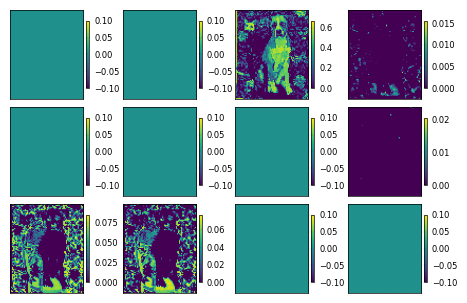

In [44]:
embeddings(encode, shape_=image.shape[0:2], figsize=(4.5, 3.75))


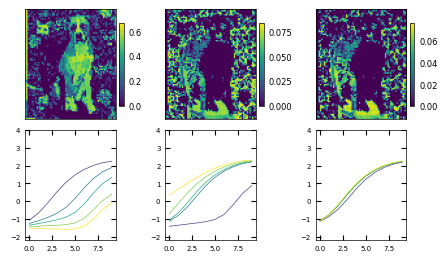

In [45]:
latent_generator(decoder, encode, image, 5, 10, device=device,
                 figsize=(5, 2.5), divider_=False, indx=[2, 8, 9])


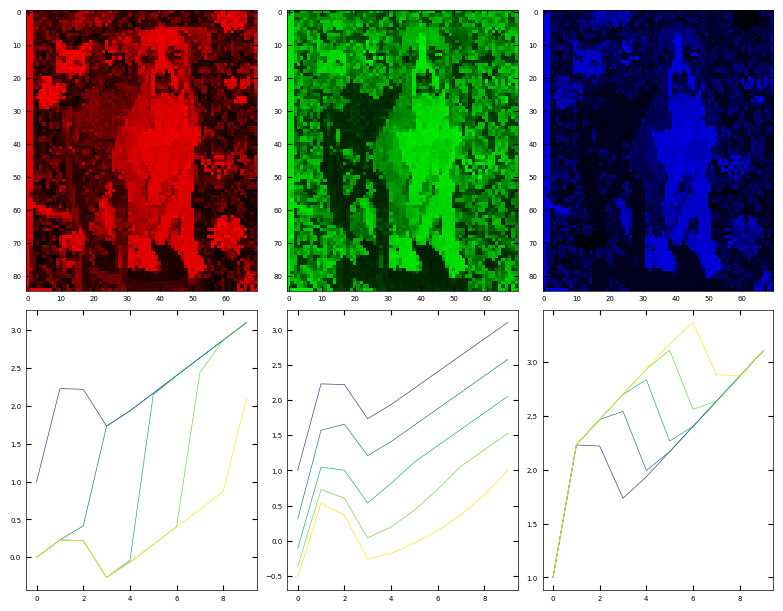

In [46]:
fig, ax = layout_fig(6, mod=3)

ax = ax.ravel()

cmap = plt.cm.viridis

for i, ax in enumerate(ax):
    if i < 3:
        img = np.zeros(image.shape)
        img[:, :, i] = image[:, :, i]
        ax.imshow(img)
    else:
        values = np.zeros((5, 3))
        values[:, i - 3] = np.linspace(0, 1, 5)
        y_data = generate_data(values, length=10)
        for j in range(y_data.shape[0]):
            color = cmap((j + 1) / y_data.shape[0])
            ax.plot(y_data[j], c=color)


In [47]:
from IPython.display import HTML

# Youtube
HTML(
    '<iframe width="560" height="315" src="https://www.youtube.com/embed/ElTwQClLsW0" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
)


/home/ferroelectric/anaconda3/envs/STEM/lib/python3.9/site-packages/IPython/core/display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [48]:
latent_dim = 12

# input (batch,)


class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(1, 12, batch_first=True, bidirectional=True)
        self.embedding = nn.Linear(24, self.latent_dim)
        self.relu = nn.ReLU()
        self.mn = nn.Linear(self.latent_dim, self.latent_dim)
        self.sd = nn.Linear(self.latent_dim, self.latent_dim)

    def forward(self, x):
        x, (_, __) = self.lstm(x)
        x = x[:, -1, :]
        x = self.embedding(x)
        x = self.relu(x)
        mn = self.mn(x)
        sd = self.sd(x)
        std = torch.exp(sd * 0.5).cuda()
        eps = torch.normal(0, 1, size=std.size()).cuda()
        out = eps.mul(std).add_(mn).cuda()

        return out, mn, sd


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(
            latent_dim, 12, batch_first=True, bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
        x = x[:, :, None]
        x = x.transpose(1, 2)
        x = x.repeat([1, 10, 1])
        x, (_, __) = self.lstm(x)
        x = x.transpose(1, 2)
        x = self.tdd(x)
        x = x.transpose(1, 2)
        return x


In [49]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)


In [50]:
def Train(
    model,
    encoder,
    decoder,
    train_iterator,
    optimizer,
    epochs,
    coef=0,
    coef_1=0,
    ln_parm=1,
    beta_step_size=0,
    epoch_per_beta=10,
    initial_epochs=10,
    device=device,
    save=False,
):

    N_EPOCHS = epochs
    best_train_loss = float("inf")

    for epoch in range(N_EPOCHS):

        if epoch < initial_epochs:

            beta = 0
        else:

            beta = ((epoch - initial_epochs) //
                    epoch_per_beta + 1) * beta_step_size

        train_loss = loss_function(
            model,
            encoder,
            decoder,
            train_iterator,
            optimizer,
            coef,
            coef_1,
            ln_parm,
            beta=beta,
            mse=False,
        )

        train_loss /= len(train_iterator)
        print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}")
        print(".............................")

        if save:
            if (
                (epoch - initial_epochs) // epoch_per_beta
                == (epoch - initial_epochs) / epoch_per_beta
            ) and (epoch >= initial_epochs):

                best_train_loss = float("inf")

            if best_train_loss > train_loss:
                best_train_loss = train_loss
                patience_counter = 1
                checkpoint = {
                    "net": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "epoch": epoch,
                    "encoder": encoder.state_dict(),
                    "decoder": decoder.state_dict(),
                }
                if epoch >= 0:
                    torch.save(
                        checkpoint, f"./test__Train_Loss:{train_loss:.4f}-{epoch}.pkl"
                    )


In [51]:
random_seed(seed=42)

Train(
    model,
    encoder,
    decoder,
    train_iterator,
    optimizer,
    500,
    beta_step_size=0.05,
    epoch_per_beta=100,
    initial_epochs=200,
    device=device,
)


Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 159.75it/s]

100%|██████████| 19/19 [00:00<00:00, 159.75it/s]

Epoch 0, Train Loss: 1.8868
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 166.99it/s]

100%|██████████| 19/19 [00:00<00:00, 163.99it/s]

Epoch 1, Train Loss: 1.8601
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 139.49it/s]

100%|██████████| 19/19 [00:00<00:00, 141.44it/s]

Epoch 2, Train Loss: 1.8369
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 149.72it/s]

100%|██████████| 19/19 [00:00<00:00, 145.01it/s]

Epoch 3, Train Loss: 1.8194
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.42it/s]

100%|██████████| 19/19 [00:00<00:00, 144.18it/s]

Epoch 4, Train Loss: 1.7971
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 142.60it/s]

100%|██████████| 19/19 [00:00<00:00, 139.00it/s]

Epoch 5, Train Loss: 1.7614
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.18it/s]

100%|██████████| 19/19 [00:00<00:00, 144.72it/s]

Epoch 6, Train Loss: 1.7277
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 154.08it/s]

100%|██████████| 19/19 [00:00<00:00, 153.42it/s]

Epoch 7, Train Loss: 1.6581
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.82it/s]

100%|██████████| 19/19 [00:00<00:00, 144.82it/s]

Epoch 8, Train Loss: 1.5673
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.55it/s]

100%|██████████| 19/19 [00:00<00:00, 146.97it/s]

Epoch 9, Train Loss: 1.4347
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 143.69it/s]

100%|██████████| 19/19 [00:00<00:00, 142.94it/s]

Epoch 10, Train Loss: 1.2674
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 143.72it/s]

100%|██████████| 19/19 [00:00<00:00, 144.92it/s]

Epoch 11, Train Loss: 1.1148
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 149.68it/s]

100%|██████████| 19/19 [00:00<00:00, 151.52it/s]

Epoch 12, Train Loss: 0.9595
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.14it/s]

100%|██████████| 19/19 [00:00<00:00, 146.91it/s]

Epoch 13, Train Loss: 0.8134
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 140.56it/s]

100%|██████████| 19/19 [00:00<00:00, 143.24it/s]

Epoch 14, Train Loss: 0.6702
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 151.98it/s]

100%|██████████| 19/19 [00:00<00:00, 151.59it/s]

Epoch 15, Train Loss: 0.5385
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 149.88it/s]

100%|██████████| 19/19 [00:00<00:00, 150.08it/s]

Epoch 16, Train Loss: 0.4226
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.51it/s]

100%|██████████| 19/19 [00:00<00:00, 145.41it/s]

Epoch 17, Train Loss: 0.3489
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 153.03it/s]

100%|██████████| 19/19 [00:00<00:00, 149.07it/s]

Epoch 18, Train Loss: 0.3002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 144.36it/s]

100%|██████████| 19/19 [00:00<00:00, 144.77it/s]

Epoch 19, Train Loss: 0.2694
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 143.54it/s]

100%|██████████| 19/19 [00:00<00:00, 143.59it/s]

Epoch 20, Train Loss: 0.2484
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 144.77it/s]

100%|██████████| 19/19 [00:00<00:00, 144.04it/s]

Epoch 21, Train Loss: 0.2366
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.00it/s]

100%|██████████| 19/19 [00:00<00:00, 143.75it/s]

Epoch 22, Train Loss: 0.2302
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 149.75it/s]

100%|██████████| 19/19 [00:00<00:00, 150.99it/s]

Epoch 23, Train Loss: 0.2195
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.87it/s]

100%|██████████| 19/19 [00:00<00:00, 148.55it/s]

Epoch 24, Train Loss: 0.2134
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 136.68it/s]

100%|██████████| 19/19 [00:00<00:00, 141.02it/s]

Epoch 25, Train Loss: 0.2084
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.47it/s]

100%|██████████| 19/19 [00:00<00:00, 144.80it/s]

Epoch 26, Train Loss: 0.2034
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.65it/s]

100%|██████████| 19/19 [00:00<00:00, 148.73it/s]

Epoch 27, Train Loss: 0.1974
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 137.58it/s]

100%|██████████| 19/19 [00:00<00:00, 141.71it/s]

Epoch 28, Train Loss: 0.1946
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.41it/s]

100%|██████████| 19/19 [00:00<00:00, 145.23it/s]

Epoch 29, Train Loss: 0.1912
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.10it/s]

100%|██████████| 19/19 [00:00<00:00, 146.12it/s]

Epoch 30, Train Loss: 0.1883
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.74it/s]

100%|██████████| 19/19 [00:00<00:00, 145.53it/s]

Epoch 31, Train Loss: 0.1846
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.55it/s]

100%|██████████| 19/19 [00:00<00:00, 143.56it/s]

Epoch 32, Train Loss: 0.1818
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.06it/s]

100%|██████████| 19/19 [00:00<00:00, 148.49it/s]

Epoch 33, Train Loss: 0.1795
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 153.34it/s]

100%|██████████| 19/19 [00:00<00:00, 151.30it/s]

Epoch 34, Train Loss: 0.1763
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 151.44it/s]

100%|██████████| 19/19 [00:00<00:00, 151.18it/s]

Epoch 35, Train Loss: 0.1745
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 139.82it/s]

100%|██████████| 19/19 [00:00<00:00, 141.23it/s]

Epoch 36, Train Loss: 0.1719
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 151.27it/s]

100%|██████████| 19/19 [00:00<00:00, 149.84it/s]

Epoch 37, Train Loss: 0.1700
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.88it/s]

100%|██████████| 19/19 [00:00<00:00, 149.38it/s]

Epoch 38, Train Loss: 0.1682
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 141.06it/s]

100%|██████████| 19/19 [00:00<00:00, 141.73it/s]

Epoch 39, Train Loss: 0.1660
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 150.95it/s]

100%|██████████| 19/19 [00:00<00:00, 149.02it/s]

Epoch 40, Train Loss: 0.1636
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 142.39it/s]

100%|██████████| 19/19 [00:00<00:00, 145.04it/s]

Epoch 41, Train Loss: 0.1618
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 140.68it/s]

100%|██████████| 19/19 [00:00<00:00, 141.71it/s]

Epoch 42, Train Loss: 0.1596
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.55it/s]

100%|██████████| 19/19 [00:00<00:00, 145.29it/s]

Epoch 43, Train Loss: 0.1581
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.83it/s]

100%|██████████| 19/19 [00:00<00:00, 144.41it/s]

Epoch 44, Train Loss: 0.1561
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 139.30it/s]

100%|██████████| 19/19 [00:00<00:00, 141.71it/s]

Epoch 45, Train Loss: 0.1540
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.86it/s]

100%|██████████| 19/19 [00:00<00:00, 147.31it/s]

Epoch 46, Train Loss: 0.1523
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 141.66it/s]

100%|██████████| 19/19 [00:00<00:00, 142.91it/s]

Epoch 47, Train Loss: 0.1502
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.16it/s]

100%|██████████| 19/19 [00:00<00:00, 145.50it/s]

Epoch 48, Train Loss: 0.1483
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 151.36it/s]

100%|██████████| 19/19 [00:00<00:00, 149.85it/s]

Epoch 49, Train Loss: 0.1460
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.87it/s]

100%|██████████| 19/19 [00:00<00:00, 147.63it/s]

Epoch 50, Train Loss: 0.1448
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.07it/s]

100%|██████████| 19/19 [00:00<00:00, 149.35it/s]

Epoch 51, Train Loss: 0.1428
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 143.26it/s]

100%|██████████| 19/19 [00:00<00:00, 141.84it/s]

Epoch 52, Train Loss: 0.1410
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.26it/s]

100%|██████████| 19/19 [00:00<00:00, 146.82it/s]

Epoch 53, Train Loss: 0.1391
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 152.37it/s]

100%|██████████| 19/19 [00:00<00:00, 148.98it/s]

Epoch 54, Train Loss: 0.1376
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.83it/s]

100%|██████████| 19/19 [00:00<00:00, 147.67it/s]

Epoch 55, Train Loss: 0.1361
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.05it/s]

100%|██████████| 19/19 [00:00<00:00, 147.55it/s]

Epoch 56, Train Loss: 0.1344
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 142.82it/s]

100%|██████████| 19/19 [00:00<00:00, 144.75it/s]

Epoch 57, Train Loss: 0.1331
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.04it/s]

100%|██████████| 19/19 [00:00<00:00, 146.64it/s]

Epoch 58, Train Loss: 0.1316
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 149.55it/s]

100%|██████████| 19/19 [00:00<00:00, 150.07it/s]

Epoch 59, Train Loss: 0.1302
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.74it/s]

100%|██████████| 19/19 [00:00<00:00, 149.90it/s]

Epoch 60, Train Loss: 0.1289
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 151.50it/s]

100%|██████████| 19/19 [00:00<00:00, 150.77it/s]

Epoch 61, Train Loss: 0.1276
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.01it/s]

100%|██████████| 19/19 [00:00<00:00, 150.76it/s]

Epoch 62, Train Loss: 0.1266
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 188.70it/s]

100%|██████████| 19/19 [00:00<00:00, 187.72it/s]

Epoch 63, Train Loss: 0.1255
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.82it/s]

Epoch 64, Train Loss: 0.1247
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.95it/s]

Epoch 65, Train Loss: 0.1233
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.01it/s]

Epoch 66, Train Loss: 0.1224
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.91it/s]

Epoch 67, Train Loss: 0.1214
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.40it/s]

Epoch 68, Train Loss: 0.1204
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.59it/s]

Epoch 69, Train Loss: 0.1196
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.95it/s]

Epoch 70, Train Loss: 0.1191
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.63it/s]

Epoch 71, Train Loss: 0.1180
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.86it/s]

Epoch 72, Train Loss: 0.1171
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.91it/s]

Epoch 73, Train Loss: 0.1162
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 194.82it/s]

Epoch 74, Train Loss: 0.1157
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 150.79it/s]

100%|██████████| 19/19 [00:00<00:00, 150.51it/s]

Epoch 75, Train Loss: 0.1146
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.92it/s]

100%|██████████| 19/19 [00:00<00:00, 148.52it/s]

Epoch 76, Train Loss: 0.1141
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 144.69it/s]

100%|██████████| 19/19 [00:00<00:00, 146.69it/s]

Epoch 77, Train Loss: 0.1135
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 150.02it/s]

100%|██████████| 19/19 [00:00<00:00, 146.93it/s]

Epoch 78, Train Loss: 0.1125
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.45it/s]

100%|██████████| 19/19 [00:00<00:00, 149.49it/s]

Epoch 79, Train Loss: 0.1119
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 149.41it/s]

100%|██████████| 19/19 [00:00<00:00, 150.30it/s]

Epoch 80, Train Loss: 0.1113
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 153.82it/s]

100%|██████████| 19/19 [00:00<00:00, 152.78it/s]

Epoch 81, Train Loss: 0.1106
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.98it/s]

100%|██████████| 19/19 [00:00<00:00, 148.88it/s]

Epoch 82, Train Loss: 0.1097
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.12it/s]

100%|██████████| 19/19 [00:00<00:00, 147.11it/s]

Epoch 83, Train Loss: 0.1091
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 151.45it/s]

100%|██████████| 19/19 [00:00<00:00, 151.76it/s]

Epoch 84, Train Loss: 0.1085
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 149.32it/s]

100%|██████████| 19/19 [00:00<00:00, 149.21it/s]

Epoch 85, Train Loss: 0.1080
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.32it/s]

100%|██████████| 19/19 [00:00<00:00, 148.05it/s]

Epoch 86, Train Loss: 0.1072
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 144.42it/s]

100%|██████████| 19/19 [00:00<00:00, 143.87it/s]

Epoch 87, Train Loss: 0.1068
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 144.40it/s]

100%|██████████| 19/19 [00:00<00:00, 146.17it/s]

Epoch 88, Train Loss: 0.1059
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 141.15it/s]

100%|██████████| 19/19 [00:00<00:00, 142.69it/s]

Epoch 89, Train Loss: 0.1054
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.49it/s]

100%|██████████| 19/19 [00:00<00:00, 146.59it/s]

Epoch 90, Train Loss: 0.1048
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.40it/s]

100%|██████████| 19/19 [00:00<00:00, 148.59it/s]

Epoch 91, Train Loss: 0.1043
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 150.90it/s]

100%|██████████| 19/19 [00:00<00:00, 149.47it/s]

Epoch 92, Train Loss: 0.1037
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 144.70it/s]

100%|██████████| 19/19 [00:00<00:00, 145.87it/s]

Epoch 93, Train Loss: 0.1032
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.19it/s]

100%|██████████| 19/19 [00:00<00:00, 143.50it/s]

Epoch 94, Train Loss: 0.1026
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.34it/s]

100%|██████████| 19/19 [00:00<00:00, 147.84it/s]

Epoch 95, Train Loss: 0.1021
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.74it/s]

100%|██████████| 19/19 [00:00<00:00, 144.61it/s]

Epoch 96, Train Loss: 0.1016
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 144.75it/s]

100%|██████████| 19/19 [00:00<00:00, 144.10it/s]

Epoch 97, Train Loss: 0.1011
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 150.57it/s]

100%|██████████| 19/19 [00:00<00:00, 148.76it/s]

Epoch 98, Train Loss: 0.1007
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.59it/s]

100%|██████████| 19/19 [00:00<00:00, 148.22it/s]

Epoch 99, Train Loss: 0.1001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.46it/s]

100%|██████████| 19/19 [00:00<00:00, 146.58it/s]

Epoch 100, Train Loss: 0.0997
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.43it/s]

100%|██████████| 19/19 [00:00<00:00, 148.54it/s]

Epoch 101, Train Loss: 0.0993
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.69it/s]

100%|██████████| 19/19 [00:00<00:00, 146.77it/s]

Epoch 102, Train Loss: 0.0986
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 141.03it/s]

100%|██████████| 19/19 [00:00<00:00, 142.54it/s]

Epoch 103, Train Loss: 0.0983
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.44it/s]

100%|██████████| 19/19 [00:00<00:00, 148.79it/s]

Epoch 104, Train Loss: 0.0976
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.42it/s]

100%|██████████| 19/19 [00:00<00:00, 148.01it/s]

Epoch 105, Train Loss: 0.0971
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 138.71it/s]

100%|██████████| 19/19 [00:00<00:00, 141.35it/s]

Epoch 106, Train Loss: 0.0966
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.01it/s]

100%|██████████| 19/19 [00:00<00:00, 147.62it/s]

Epoch 107, Train Loss: 0.0960
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 149.04it/s]

100%|██████████| 19/19 [00:00<00:00, 150.05it/s]

Epoch 108, Train Loss: 0.0958
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.08it/s]

100%|██████████| 19/19 [00:00<00:00, 147.48it/s]

Epoch 109, Train Loss: 0.0949
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.04it/s]

100%|██████████| 19/19 [00:00<00:00, 146.13it/s]

Epoch 110, Train Loss: 0.0945
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 150.71it/s]

100%|██████████| 19/19 [00:00<00:00, 152.79it/s]

Epoch 111, Train Loss: 0.0937
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 144.56it/s]

100%|██████████| 19/19 [00:00<00:00, 146.14it/s]

Epoch 112, Train Loss: 0.0931
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 149.00it/s]

100%|██████████| 19/19 [00:00<00:00, 145.91it/s]

Epoch 113, Train Loss: 0.0924
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.11it/s]

100%|██████████| 19/19 [00:00<00:00, 146.99it/s]

Epoch 114, Train Loss: 0.0917
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.07it/s]

100%|██████████| 19/19 [00:00<00:00, 147.44it/s]

Epoch 115, Train Loss: 0.0908
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 139.81it/s]

100%|██████████| 19/19 [00:00<00:00, 143.17it/s]

Epoch 116, Train Loss: 0.0901
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 151.00it/s]

100%|██████████| 19/19 [00:00<00:00, 153.06it/s]

Epoch 117, Train Loss: 0.0892
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 152.31it/s]

100%|██████████| 19/19 [00:00<00:00, 154.14it/s]

Epoch 118, Train Loss: 0.0883
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 151.33it/s]

100%|██████████| 19/19 [00:00<00:00, 149.93it/s]

Epoch 119, Train Loss: 0.0872
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.95it/s]

100%|██████████| 19/19 [00:00<00:00, 150.06it/s]

Epoch 120, Train Loss: 0.0862
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 149.96it/s]

100%|██████████| 19/19 [00:00<00:00, 152.22it/s]

Epoch 121, Train Loss: 0.0849
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.34it/s]

100%|██████████| 19/19 [00:00<00:00, 146.97it/s]

Epoch 122, Train Loss: 0.0836
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.74it/s]

100%|██████████| 19/19 [00:00<00:00, 148.18it/s]

Epoch 123, Train Loss: 0.0821
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.38it/s]

100%|██████████| 19/19 [00:00<00:00, 138.22it/s]

Epoch 124, Train Loss: 0.0804
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.54it/s]

100%|██████████| 19/19 [00:00<00:00, 146.88it/s]

Epoch 125, Train Loss: 0.0786
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 141.53it/s]

100%|██████████| 19/19 [00:00<00:00, 143.24it/s]

Epoch 126, Train Loss: 0.0768
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.79it/s]

100%|██████████| 19/19 [00:00<00:00, 146.13it/s]

Epoch 127, Train Loss: 0.0744
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.65it/s]

100%|██████████| 19/19 [00:00<00:00, 148.71it/s]

Epoch 128, Train Loss: 0.0723
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.84it/s]

100%|██████████| 19/19 [00:00<00:00, 149.68it/s]

Epoch 129, Train Loss: 0.0704
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.68it/s]

100%|██████████| 19/19 [00:00<00:00, 148.16it/s]

Epoch 130, Train Loss: 0.0687
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.75it/s]

100%|██████████| 19/19 [00:00<00:00, 147.42it/s]

Epoch 131, Train Loss: 0.0670
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.29it/s]

100%|██████████| 19/19 [00:00<00:00, 148.59it/s]

Epoch 132, Train Loss: 0.0653
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.43it/s]

100%|██████████| 19/19 [00:00<00:00, 146.85it/s]

Epoch 133, Train Loss: 0.0638
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 151.18it/s]

100%|██████████| 19/19 [00:00<00:00, 150.76it/s]

Epoch 134, Train Loss: 0.0623
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 144.86it/s]

100%|██████████| 19/19 [00:00<00:00, 145.92it/s]

Epoch 135, Train Loss: 0.0611
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 153.43it/s]

100%|██████████| 19/19 [00:00<00:00, 152.35it/s]

Epoch 136, Train Loss: 0.0600
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 152.41it/s]

100%|██████████| 19/19 [00:00<00:00, 150.74it/s]

Epoch 137, Train Loss: 0.0588
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 151.59it/s]

100%|██████████| 19/19 [00:00<00:00, 149.39it/s]

Epoch 138, Train Loss: 0.0578
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 144.01it/s]

100%|██████████| 19/19 [00:00<00:00, 142.36it/s]

Epoch 139, Train Loss: 0.0569
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.29it/s]

100%|██████████| 19/19 [00:00<00:00, 148.81it/s]

Epoch 140, Train Loss: 0.0560
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.43it/s]

100%|██████████| 19/19 [00:00<00:00, 149.52it/s]

Epoch 141, Train Loss: 0.0549
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 144.89it/s]

100%|██████████| 19/19 [00:00<00:00, 146.73it/s]

Epoch 142, Train Loss: 0.0541
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 149.13it/s]

100%|██████████| 19/19 [00:00<00:00, 149.71it/s]

Epoch 143, Train Loss: 0.0533
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 143.44it/s]

100%|██████████| 19/19 [00:00<00:00, 141.37it/s]

Epoch 144, Train Loss: 0.0526
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.64it/s]

100%|██████████| 19/19 [00:00<00:00, 146.73it/s]

Epoch 145, Train Loss: 0.0518
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.01it/s]

100%|██████████| 19/19 [00:00<00:00, 146.35it/s]

Epoch 146, Train Loss: 0.0512
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.97it/s]

100%|██████████| 19/19 [00:00<00:00, 147.11it/s]

Epoch 147, Train Loss: 0.0504
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.04it/s]

100%|██████████| 19/19 [00:00<00:00, 146.79it/s]

Epoch 148, Train Loss: 0.0497
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 153.76it/s]

100%|██████████| 19/19 [00:00<00:00, 152.30it/s]

Epoch 149, Train Loss: 0.0489
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.84it/s]

100%|██████████| 19/19 [00:00<00:00, 149.33it/s]

Epoch 150, Train Loss: 0.0482
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.77it/s]

100%|██████████| 19/19 [00:00<00:00, 148.41it/s]

Epoch 151, Train Loss: 0.0477
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.55it/s]

100%|██████████| 19/19 [00:00<00:00, 145.22it/s]

Epoch 152, Train Loss: 0.0471
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.54it/s]

100%|██████████| 19/19 [00:00<00:00, 145.93it/s]

Epoch 153, Train Loss: 0.0466
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.60it/s]

100%|██████████| 19/19 [00:00<00:00, 147.08it/s]

Epoch 154, Train Loss: 0.0461
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 144.33it/s]

100%|██████████| 19/19 [00:00<00:00, 144.65it/s]

Epoch 155, Train Loss: 0.0454
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 138.98it/s]

100%|██████████| 19/19 [00:00<00:00, 140.68it/s]

Epoch 156, Train Loss: 0.0450
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.25it/s]

100%|██████████| 19/19 [00:00<00:00, 148.08it/s]

Epoch 157, Train Loss: 0.0443
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.55it/s]

100%|██████████| 19/19 [00:00<00:00, 145.91it/s]

Epoch 158, Train Loss: 0.0438
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.80it/s]

100%|██████████| 19/19 [00:00<00:00, 148.23it/s]

Epoch 159, Train Loss: 0.0433
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.74it/s]

100%|██████████| 19/19 [00:00<00:00, 147.43it/s]

Epoch 160, Train Loss: 0.0428
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 144.45it/s]

100%|██████████| 19/19 [00:00<00:00, 145.75it/s]

Epoch 161, Train Loss: 0.0423
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 142.87it/s]

100%|██████████| 19/19 [00:00<00:00, 143.73it/s]

Epoch 162, Train Loss: 0.0419
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 150.87it/s]

100%|██████████| 19/19 [00:00<00:00, 151.01it/s]

Epoch 163, Train Loss: 0.0412
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.29it/s]

100%|██████████| 19/19 [00:00<00:00, 146.39it/s]

Epoch 164, Train Loss: 0.0408
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.19it/s]

100%|██████████| 19/19 [00:00<00:00, 147.13it/s]

Epoch 165, Train Loss: 0.0404
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.84it/s]

100%|██████████| 19/19 [00:00<00:00, 149.71it/s]

Epoch 166, Train Loss: 0.0400
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 141.95it/s]

100%|██████████| 19/19 [00:00<00:00, 144.17it/s]

Epoch 167, Train Loss: 0.0396
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 140.30it/s]

100%|██████████| 19/19 [00:00<00:00, 142.66it/s]

Epoch 168, Train Loss: 0.0392
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.83it/s]

100%|██████████| 19/19 [00:00<00:00, 146.46it/s]

Epoch 169, Train Loss: 0.0385
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 153.16it/s]

100%|██████████| 19/19 [00:00<00:00, 148.78it/s]

Epoch 170, Train Loss: 0.0380
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 142.85it/s]

100%|██████████| 19/19 [00:00<00:00, 144.99it/s]

Epoch 171, Train Loss: 0.0377
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.96it/s]

100%|██████████| 19/19 [00:00<00:00, 145.94it/s]

Epoch 172, Train Loss: 0.0371
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 152.18it/s]

100%|██████████| 19/19 [00:00<00:00, 151.73it/s]

Epoch 173, Train Loss: 0.0369
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 152.05it/s]

100%|██████████| 19/19 [00:00<00:00, 151.60it/s]

Epoch 174, Train Loss: 0.0365
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.05it/s]

100%|██████████| 19/19 [00:00<00:00, 146.14it/s]

Epoch 175, Train Loss: 0.0360
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.23it/s]

100%|██████████| 19/19 [00:00<00:00, 145.18it/s]

Epoch 176, Train Loss: 0.0356
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 152.57it/s]

100%|██████████| 19/19 [00:00<00:00, 151.98it/s]

Epoch 177, Train Loss: 0.0351
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.55it/s]

100%|██████████| 19/19 [00:00<00:00, 147.78it/s]

Epoch 178, Train Loss: 0.0346
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 149.82it/s]

100%|██████████| 19/19 [00:00<00:00, 150.18it/s]

Epoch 179, Train Loss: 0.0343
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 150.24it/s]

100%|██████████| 19/19 [00:00<00:00, 150.10it/s]

Epoch 180, Train Loss: 0.0338
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 149.40it/s]

100%|██████████| 19/19 [00:00<00:00, 148.69it/s]

Epoch 181, Train Loss: 0.0335
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 152.12it/s]

100%|██████████| 19/19 [00:00<00:00, 150.58it/s]

Epoch 182, Train Loss: 0.0331
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 144.43it/s]

100%|██████████| 19/19 [00:00<00:00, 144.15it/s]

Epoch 183, Train Loss: 0.0326
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 141.21it/s]

100%|██████████| 19/19 [00:00<00:00, 141.10it/s]

Epoch 184, Train Loss: 0.0323
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.98it/s]

100%|██████████| 19/19 [00:00<00:00, 145.86it/s]

Epoch 185, Train Loss: 0.0318
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.28it/s]

100%|██████████| 19/19 [00:00<00:00, 148.87it/s]

Epoch 186, Train Loss: 0.0314
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.30it/s]

100%|██████████| 19/19 [00:00<00:00, 146.14it/s]

Epoch 187, Train Loss: 0.0310
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.28it/s]

100%|██████████| 19/19 [00:00<00:00, 145.43it/s]

Epoch 188, Train Loss: 0.0304
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 154.97it/s]

100%|██████████| 19/19 [00:00<00:00, 151.98it/s]

Epoch 189, Train Loss: 0.0299
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 149.76it/s]

100%|██████████| 19/19 [00:00<00:00, 148.44it/s]

Epoch 190, Train Loss: 0.0294
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 141.01it/s]

100%|██████████| 19/19 [00:00<00:00, 142.55it/s]

Epoch 191, Train Loss: 0.0289
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.58it/s]

100%|██████████| 19/19 [00:00<00:00, 147.91it/s]

Epoch 192, Train Loss: 0.0283
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.93it/s]

100%|██████████| 19/19 [00:00<00:00, 147.26it/s]

Epoch 193, Train Loss: 0.0277
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.31it/s]

100%|██████████| 19/19 [00:00<00:00, 143.10it/s]

Epoch 194, Train Loss: 0.0272
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.47it/s]

100%|██████████| 19/19 [00:00<00:00, 149.64it/s]

Epoch 195, Train Loss: 0.0269
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.12it/s]

100%|██████████| 19/19 [00:00<00:00, 146.48it/s]

Epoch 196, Train Loss: 0.0263
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.97it/s]

100%|██████████| 19/19 [00:00<00:00, 143.08it/s]

Epoch 197, Train Loss: 0.0259
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.47it/s]

100%|██████████| 19/19 [00:00<00:00, 146.08it/s]

Epoch 198, Train Loss: 0.0255
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 148.89it/s]

100%|██████████| 19/19 [00:00<00:00, 151.03it/s]

Epoch 199, Train Loss: 0.0252
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 143.64it/s]

100%|██████████| 19/19 [00:00<00:00, 145.86it/s]

Epoch 200, Train Loss: 2.6317
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 142.01it/s]

100%|██████████| 19/19 [00:00<00:00, 143.84it/s]

Epoch 201, Train Loss: 1.1231
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.86it/s]

100%|██████████| 19/19 [00:00<00:00, 147.79it/s]

Epoch 202, Train Loss: 0.7740
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 143.92it/s]

100%|██████████| 19/19 [00:00<00:00, 144.24it/s]

Epoch 203, Train Loss: 0.6059
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 149.52it/s]

100%|██████████| 19/19 [00:00<00:00, 149.44it/s]

Epoch 204, Train Loss: 0.5093
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.99it/s]

100%|██████████| 19/19 [00:00<00:00, 147.35it/s]

Epoch 205, Train Loss: 0.4461
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.65it/s]

100%|██████████| 19/19 [00:00<00:00, 146.32it/s]

Epoch 206, Train Loss: 0.4062
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.55it/s]

100%|██████████| 19/19 [00:00<00:00, 145.61it/s]

Epoch 207, Train Loss: 0.3746
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 151.47it/s]

100%|██████████| 19/19 [00:00<00:00, 149.84it/s]

Epoch 208, Train Loss: 0.3495
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.74it/s]

100%|██████████| 19/19 [00:00<00:00, 149.92it/s]

Epoch 209, Train Loss: 0.3333
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.84it/s]

100%|██████████| 19/19 [00:00<00:00, 147.35it/s]

Epoch 210, Train Loss: 0.3202
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.27it/s]

100%|██████████| 19/19 [00:00<00:00, 142.87it/s]

Epoch 211, Train Loss: 0.3076
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.22it/s]

100%|██████████| 19/19 [00:00<00:00, 146.41it/s]

Epoch 212, Train Loss: 0.2999
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 143.81it/s]

100%|██████████| 19/19 [00:00<00:00, 143.29it/s]

Epoch 213, Train Loss: 0.2910
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.08it/s]

100%|██████████| 19/19 [00:00<00:00, 146.51it/s]

Epoch 214, Train Loss: 0.2819
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 151.07it/s]

100%|██████████| 19/19 [00:00<00:00, 151.77it/s]

Epoch 215, Train Loss: 0.2748
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.40it/s]

100%|██████████| 19/19 [00:00<00:00, 146.70it/s]

Epoch 216, Train Loss: 0.2684
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 151.09it/s]

100%|██████████| 19/19 [00:00<00:00, 148.74it/s]

Epoch 217, Train Loss: 0.2664
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 142.43it/s]

100%|██████████| 19/19 [00:00<00:00, 142.23it/s]

Epoch 218, Train Loss: 0.2621
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.95it/s]

100%|██████████| 19/19 [00:00<00:00, 147.10it/s]

Epoch 219, Train Loss: 0.2600
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.92it/s]

100%|██████████| 19/19 [00:00<00:00, 148.82it/s]

Epoch 220, Train Loss: 0.2551
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.60it/s]

100%|██████████| 19/19 [00:00<00:00, 146.91it/s]

Epoch 221, Train Loss: 0.2516
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.27it/s]

100%|██████████| 19/19 [00:00<00:00, 146.76it/s]

Epoch 222, Train Loss: 0.2482
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.17it/s]

100%|██████████| 19/19 [00:00<00:00, 148.20it/s]

Epoch 223, Train Loss: 0.2441
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.79it/s]

100%|██████████| 19/19 [00:00<00:00, 146.75it/s]

Epoch 224, Train Loss: 0.2412
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.04it/s]

100%|██████████| 19/19 [00:00<00:00, 149.26it/s]

Epoch 225, Train Loss: 0.2382
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 149.02it/s]

100%|██████████| 19/19 [00:00<00:00, 147.98it/s]

Epoch 226, Train Loss: 0.2361
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.06it/s]

100%|██████████| 19/19 [00:00<00:00, 146.36it/s]

Epoch 227, Train Loss: 0.2343
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.72it/s]

100%|██████████| 19/19 [00:00<00:00, 144.12it/s]

Epoch 228, Train Loss: 0.2322
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 143.32it/s]

100%|██████████| 19/19 [00:00<00:00, 143.99it/s]

Epoch 229, Train Loss: 0.2304
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 149.97it/s]

100%|██████████| 19/19 [00:00<00:00, 150.50it/s]

Epoch 230, Train Loss: 0.2305
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.18it/s]

100%|██████████| 19/19 [00:00<00:00, 143.20it/s]

Epoch 231, Train Loss: 0.2264
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.03it/s]

100%|██████████| 19/19 [00:00<00:00, 147.70it/s]

Epoch 232, Train Loss: 0.2255
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 143.46it/s]

100%|██████████| 19/19 [00:00<00:00, 145.16it/s]

Epoch 233, Train Loss: 0.2229
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 149.50it/s]

100%|██████████| 19/19 [00:00<00:00, 149.50it/s]

Epoch 234, Train Loss: 0.2220
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.89it/s]

100%|██████████| 19/19 [00:00<00:00, 148.55it/s]

Epoch 235, Train Loss: 0.2192
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 152.85it/s]

100%|██████████| 19/19 [00:00<00:00, 152.44it/s]

Epoch 236, Train Loss: 0.2173
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 153.32it/s]

100%|██████████| 19/19 [00:00<00:00, 152.99it/s]

Epoch 237, Train Loss: 0.2159
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 149.56it/s]

100%|██████████| 19/19 [00:00<00:00, 149.34it/s]

Epoch 238, Train Loss: 0.2162
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 150.39it/s]

100%|██████████| 19/19 [00:00<00:00, 149.12it/s]

Epoch 239, Train Loss: 0.2119
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 150.69it/s]

100%|██████████| 19/19 [00:00<00:00, 151.07it/s]

Epoch 240, Train Loss: 0.2105
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.91it/s]

100%|██████████| 19/19 [00:00<00:00, 148.80it/s]

Epoch 241, Train Loss: 0.2092
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 149.76it/s]

100%|██████████| 19/19 [00:00<00:00, 149.06it/s]

Epoch 242, Train Loss: 0.2083
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 150.68it/s]

100%|██████████| 19/19 [00:00<00:00, 150.62it/s]

Epoch 243, Train Loss: 0.2079
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 149.10it/s]

100%|██████████| 19/19 [00:00<00:00, 148.19it/s]

Epoch 244, Train Loss: 0.2047
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 164.86it/s]

100%|██████████| 19/19 [00:00<00:00, 164.53it/s]

Epoch 245, Train Loss: 0.2043
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 156.23it/s]

100%|██████████| 19/19 [00:00<00:00, 153.84it/s]

Epoch 246, Train Loss: 0.1996
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.71it/s]

100%|██████████| 19/19 [00:00<00:00, 149.67it/s]

Epoch 247, Train Loss: 0.1960
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.00it/s]

100%|██████████| 19/19 [00:00<00:00, 145.86it/s]

Epoch 248, Train Loss: 0.1947
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 151.17it/s]

100%|██████████| 19/19 [00:00<00:00, 151.32it/s]

Epoch 249, Train Loss: 0.1930
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.44it/s]

100%|██████████| 19/19 [00:00<00:00, 147.06it/s]

Epoch 250, Train Loss: 0.1916
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.68it/s]

100%|██████████| 19/19 [00:00<00:00, 147.35it/s]

Epoch 251, Train Loss: 0.1870
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 151.62it/s]

100%|██████████| 19/19 [00:00<00:00, 149.14it/s]

Epoch 252, Train Loss: 0.1864
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.19it/s]

100%|██████████| 19/19 [00:00<00:00, 148.15it/s]

Epoch 253, Train Loss: 0.1847
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 153.16it/s]

100%|██████████| 19/19 [00:00<00:00, 152.30it/s]

Epoch 254, Train Loss: 0.1813
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 151.05it/s]

100%|██████████| 19/19 [00:00<00:00, 147.55it/s]

Epoch 255, Train Loss: 0.1799
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 149.10it/s]

100%|██████████| 19/19 [00:00<00:00, 149.90it/s]

Epoch 256, Train Loss: 0.1771
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 149.35it/s]

100%|██████████| 19/19 [00:00<00:00, 150.07it/s]

Epoch 257, Train Loss: 0.1759
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.16it/s]

100%|██████████| 19/19 [00:00<00:00, 147.62it/s]

Epoch 258, Train Loss: 0.1759
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.54it/s]

100%|██████████| 19/19 [00:00<00:00, 149.57it/s]

Epoch 259, Train Loss: 0.1730
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.42it/s]

100%|██████████| 19/19 [00:00<00:00, 148.57it/s]

Epoch 260, Train Loss: 0.1725
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 137.98it/s]

100%|██████████| 19/19 [00:00<00:00, 139.93it/s]

Epoch 261, Train Loss: 0.1694
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 149.79it/s]

100%|██████████| 19/19 [00:00<00:00, 147.44it/s]

Epoch 262, Train Loss: 0.1687
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.02it/s]

100%|██████████| 19/19 [00:00<00:00, 150.59it/s]

Epoch 263, Train Loss: 0.1688
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.59it/s]

100%|██████████| 19/19 [00:00<00:00, 144.80it/s]

Epoch 264, Train Loss: 0.1661
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.67it/s]

100%|██████████| 19/19 [00:00<00:00, 151.09it/s]

Epoch 265, Train Loss: 0.1655
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 165.96it/s]

100%|██████████| 19/19 [00:00<00:00, 167.81it/s]

Epoch 266, Train Loss: 0.1649
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 172.28it/s]

100%|██████████| 19/19 [00:00<00:00, 172.54it/s]

Epoch 267, Train Loss: 0.1627
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 172.90it/s]

100%|██████████| 19/19 [00:00<00:00, 173.12it/s]

Epoch 268, Train Loss: 0.1595
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 164.49it/s]

100%|██████████| 19/19 [00:00<00:00, 159.29it/s]

Epoch 269, Train Loss: 0.1605
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 169.87it/s]

100%|██████████| 19/19 [00:00<00:00, 171.65it/s]

Epoch 270, Train Loss: 0.1604
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 182.34it/s]

100%|██████████| 19/19 [00:00<00:00, 181.59it/s]

Epoch 271, Train Loss: 0.1585
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 182.09it/s]

100%|██████████| 19/19 [00:00<00:00, 181.32it/s]

Epoch 272, Train Loss: 0.1576
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 163.29it/s]

100%|██████████| 19/19 [00:00<00:00, 164.58it/s]

Epoch 273, Train Loss: 0.1573
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 165.27it/s]

100%|██████████| 19/19 [00:00<00:00, 167.26it/s]

Epoch 274, Train Loss: 0.1550
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 163.71it/s]

100%|██████████| 19/19 [00:00<00:00, 165.85it/s]

Epoch 275, Train Loss: 0.1545
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 163.18it/s]

100%|██████████| 19/19 [00:00<00:00, 165.30it/s]

Epoch 276, Train Loss: 0.1518
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 156.62it/s]

100%|██████████| 19/19 [00:00<00:00, 157.82it/s]

Epoch 277, Train Loss: 0.1516
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.01it/s]

100%|██████████| 19/19 [00:00<00:00, 167.55it/s]

Epoch 278, Train Loss: 0.1515
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 165.49it/s]

100%|██████████| 19/19 [00:00<00:00, 163.76it/s]

Epoch 279, Train Loss: 0.1504
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 156.90it/s]

100%|██████████| 19/19 [00:00<00:00, 157.97it/s]

Epoch 280, Train Loss: 0.1486
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 165.66it/s]

100%|██████████| 19/19 [00:00<00:00, 167.96it/s]

Epoch 281, Train Loss: 0.1471
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.72it/s]

100%|██████████| 19/19 [00:00<00:00, 143.74it/s]

Epoch 282, Train Loss: 0.1470
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 151.79it/s]

100%|██████████| 19/19 [00:00<00:00, 150.20it/s]

Epoch 283, Train Loss: 0.1454
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.67it/s]

100%|██████████| 19/19 [00:00<00:00, 148.57it/s]

Epoch 284, Train Loss: 0.1456
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 153.55it/s]

100%|██████████| 19/19 [00:00<00:00, 151.63it/s]

Epoch 285, Train Loss: 0.1455
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.54it/s]

100%|██████████| 19/19 [00:00<00:00, 146.57it/s]

Epoch 286, Train Loss: 0.1436
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 144.54it/s]

100%|██████████| 19/19 [00:00<00:00, 143.38it/s]

Epoch 287, Train Loss: 0.1444
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 140.99it/s]

100%|██████████| 19/19 [00:00<00:00, 143.41it/s]

Epoch 288, Train Loss: 0.1416
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 143.18it/s]

100%|██████████| 19/19 [00:00<00:00, 142.85it/s]

Epoch 289, Train Loss: 0.1419
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.60it/s]

100%|██████████| 19/19 [00:00<00:00, 149.59it/s]

Epoch 290, Train Loss: 0.1411
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 152.26it/s]

100%|██████████| 19/19 [00:00<00:00, 151.77it/s]

Epoch 291, Train Loss: 0.1398
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.71it/s]

100%|██████████| 19/19 [00:00<00:00, 146.65it/s]

Epoch 292, Train Loss: 0.1396
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 156.22it/s]

100%|██████████| 19/19 [00:00<00:00, 160.96it/s]

Epoch 293, Train Loss: 0.1396
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 172.03it/s]

100%|██████████| 19/19 [00:00<00:00, 172.69it/s]

Epoch 294, Train Loss: 0.1386
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 181.01it/s]

100%|██████████| 19/19 [00:00<00:00, 179.72it/s]

Epoch 295, Train Loss: 0.1357
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 176.09it/s]

100%|██████████| 19/19 [00:00<00:00, 172.47it/s]

Epoch 296, Train Loss: 0.1364
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.42it/s]

100%|██████████| 19/19 [00:00<00:00, 144.82it/s]

Epoch 297, Train Loss: 0.1357
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 149.85it/s]

100%|██████████| 19/19 [00:00<00:00, 147.76it/s]

Epoch 298, Train Loss: 0.1358
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 150.50it/s]

100%|██████████| 19/19 [00:00<00:00, 150.18it/s]

Epoch 299, Train Loss: 0.1343
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 149.35it/s]

100%|██████████| 19/19 [00:00<00:00, 149.44it/s]

Epoch 300, Train Loss: 0.1888
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.66it/s]

100%|██████████| 19/19 [00:00<00:00, 149.52it/s]

Epoch 301, Train Loss: 0.1850
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.38it/s]

100%|██████████| 19/19 [00:00<00:00, 144.74it/s]

Epoch 302, Train Loss: 0.1801
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 151.42it/s]

100%|██████████| 19/19 [00:00<00:00, 151.29it/s]

Epoch 303, Train Loss: 0.1782
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 142.70it/s]

100%|██████████| 19/19 [00:00<00:00, 143.89it/s]

Epoch 304, Train Loss: 0.1761
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 151.68it/s]

100%|██████████| 19/19 [00:00<00:00, 150.01it/s]

Epoch 305, Train Loss: 0.1762
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 151.29it/s]

100%|██████████| 19/19 [00:00<00:00, 151.14it/s]

Epoch 306, Train Loss: 0.1758
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 144.63it/s]

100%|██████████| 19/19 [00:00<00:00, 145.47it/s]

Epoch 307, Train Loss: 0.1750
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 142.38it/s]

100%|██████████| 19/19 [00:00<00:00, 144.51it/s]

Epoch 308, Train Loss: 0.1740
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.53it/s]

100%|██████████| 19/19 [00:00<00:00, 147.70it/s]

Epoch 309, Train Loss: 0.1726
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 153.23it/s]

100%|██████████| 19/19 [00:00<00:00, 152.36it/s]

Epoch 310, Train Loss: 0.1718
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 149.33it/s]

100%|██████████| 19/19 [00:00<00:00, 149.20it/s]

Epoch 311, Train Loss: 0.1701
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.88it/s]

100%|██████████| 19/19 [00:00<00:00, 147.01it/s]

Epoch 312, Train Loss: 0.1695
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 152.30it/s]

100%|██████████| 19/19 [00:00<00:00, 151.07it/s]

Epoch 313, Train Loss: 0.1697
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.89it/s]

100%|██████████| 19/19 [00:00<00:00, 148.02it/s]

Epoch 314, Train Loss: 0.1684
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.27it/s]

100%|██████████| 19/19 [00:00<00:00, 147.06it/s]

Epoch 315, Train Loss: 0.1691
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.99it/s]

100%|██████████| 19/19 [00:00<00:00, 149.06it/s]

Epoch 316, Train Loss: 0.1662
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 151.00it/s]

100%|██████████| 19/19 [00:00<00:00, 150.28it/s]

Epoch 317, Train Loss: 0.1670
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 149.48it/s]

100%|██████████| 19/19 [00:00<00:00, 148.34it/s]

Epoch 318, Train Loss: 0.1657
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.40it/s]

100%|██████████| 19/19 [00:00<00:00, 148.56it/s]

Epoch 319, Train Loss: 0.1656
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 144.34it/s]

100%|██████████| 19/19 [00:00<00:00, 143.62it/s]

Epoch 320, Train Loss: 0.1645
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 149.88it/s]

100%|██████████| 19/19 [00:00<00:00, 150.67it/s]

Epoch 321, Train Loss: 0.1631
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.50it/s]

100%|██████████| 19/19 [00:00<00:00, 144.58it/s]

Epoch 322, Train Loss: 0.1639
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 149.87it/s]

100%|██████████| 19/19 [00:00<00:00, 148.06it/s]

Epoch 323, Train Loss: 0.1643
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.78it/s]

100%|██████████| 19/19 [00:00<00:00, 146.47it/s]

Epoch 324, Train Loss: 0.1619
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.03it/s]

100%|██████████| 19/19 [00:00<00:00, 149.17it/s]

Epoch 325, Train Loss: 0.1622
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 143.97it/s]

100%|██████████| 19/19 [00:00<00:00, 145.96it/s]

Epoch 326, Train Loss: 0.1603
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.47it/s]

100%|██████████| 19/19 [00:00<00:00, 148.54it/s]

Epoch 327, Train Loss: 0.1609
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.97it/s]

100%|██████████| 19/19 [00:00<00:00, 146.17it/s]

Epoch 328, Train Loss: 0.1577
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 152.51it/s]

100%|██████████| 19/19 [00:00<00:00, 152.10it/s]

Epoch 329, Train Loss: 0.1584
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 143.33it/s]

100%|██████████| 19/19 [00:00<00:00, 143.69it/s]

Epoch 330, Train Loss: 0.1570
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.08it/s]

100%|██████████| 19/19 [00:00<00:00, 145.85it/s]

Epoch 331, Train Loss: 0.1574
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 142.74it/s]

100%|██████████| 19/19 [00:00<00:00, 142.87it/s]

Epoch 332, Train Loss: 0.1588
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 136.98it/s]

100%|██████████| 19/19 [00:00<00:00, 141.44it/s]

Epoch 333, Train Loss: 0.1566
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 150.99it/s]

100%|██████████| 19/19 [00:00<00:00, 149.55it/s]

Epoch 334, Train Loss: 0.1547
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.68it/s]

100%|██████████| 19/19 [00:00<00:00, 147.35it/s]

Epoch 335, Train Loss: 0.1551
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.11it/s]

100%|██████████| 19/19 [00:00<00:00, 146.43it/s]

Epoch 336, Train Loss: 0.1537
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 149.45it/s]

100%|██████████| 19/19 [00:00<00:00, 149.77it/s]

Epoch 337, Train Loss: 0.1532
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.86it/s]

100%|██████████| 19/19 [00:00<00:00, 147.87it/s]

Epoch 338, Train Loss: 0.1511
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.24it/s]

100%|██████████| 19/19 [00:00<00:00, 147.02it/s]

Epoch 339, Train Loss: 0.1527
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 143.85it/s]

100%|██████████| 19/19 [00:00<00:00, 145.04it/s]

Epoch 340, Train Loss: 0.1517
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.34it/s]

100%|██████████| 19/19 [00:00<00:00, 147.83it/s]

Epoch 341, Train Loss: 0.1502
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.88it/s]

100%|██████████| 19/19 [00:00<00:00, 147.08it/s]

Epoch 342, Train Loss: 0.1514
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 152.85it/s]

100%|██████████| 19/19 [00:00<00:00, 152.37it/s]

Epoch 343, Train Loss: 0.1496
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.60it/s]

100%|██████████| 19/19 [00:00<00:00, 146.23it/s]

Epoch 344, Train Loss: 0.1487
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 151.97it/s]

100%|██████████| 19/19 [00:00<00:00, 151.31it/s]

Epoch 345, Train Loss: 0.1490
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.12it/s]

100%|██████████| 19/19 [00:00<00:00, 148.87it/s]

Epoch 346, Train Loss: 0.1486
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 144.12it/s]

100%|██████████| 19/19 [00:00<00:00, 143.20it/s]

Epoch 347, Train Loss: 0.1487
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.85it/s]

100%|██████████| 19/19 [00:00<00:00, 148.92it/s]

Epoch 348, Train Loss: 0.1464
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.58it/s]

100%|██████████| 19/19 [00:00<00:00, 144.75it/s]

Epoch 349, Train Loss: 0.1461
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 141.05it/s]

100%|██████████| 19/19 [00:00<00:00, 143.63it/s]

Epoch 350, Train Loss: 0.1442
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.55it/s]

100%|██████████| 19/19 [00:00<00:00, 146.71it/s]

Epoch 351, Train Loss: 0.1460
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.34it/s]

100%|██████████| 19/19 [00:00<00:00, 146.22it/s]

Epoch 352, Train Loss: 0.1443
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 143.59it/s]

100%|██████████| 19/19 [00:00<00:00, 142.64it/s]

Epoch 353, Train Loss: 0.1434
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 140.99it/s]

100%|██████████| 19/19 [00:00<00:00, 143.50it/s]

Epoch 354, Train Loss: 0.1424
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.12it/s]

100%|██████████| 19/19 [00:00<00:00, 146.03it/s]

Epoch 355, Train Loss: 0.1425
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 153.59it/s]

100%|██████████| 19/19 [00:00<00:00, 152.13it/s]

Epoch 356, Train Loss: 0.1416
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.00it/s]

100%|██████████| 19/19 [00:00<00:00, 147.64it/s]

Epoch 357, Train Loss: 0.1415
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 142.76it/s]

100%|██████████| 19/19 [00:00<00:00, 141.53it/s]

Epoch 358, Train Loss: 0.1416
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.26it/s]

100%|██████████| 19/19 [00:00<00:00, 147.93it/s]

Epoch 359, Train Loss: 0.1397
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 151.31it/s]

100%|██████████| 19/19 [00:00<00:00, 149.73it/s]

Epoch 360, Train Loss: 0.1393
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 144.03it/s]

100%|██████████| 19/19 [00:00<00:00, 145.00it/s]

Epoch 361, Train Loss: 0.1386
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.51it/s]

100%|██████████| 19/19 [00:00<00:00, 146.24it/s]

Epoch 362, Train Loss: 0.1381
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 139.43it/s]

100%|██████████| 19/19 [00:00<00:00, 140.81it/s]

Epoch 363, Train Loss: 0.1375
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 139.86it/s]

100%|██████████| 19/19 [00:00<00:00, 142.18it/s]

Epoch 364, Train Loss: 0.1375
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 151.43it/s]

100%|██████████| 19/19 [00:00<00:00, 151.45it/s]

Epoch 365, Train Loss: 0.1364
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.17it/s]

100%|██████████| 19/19 [00:00<00:00, 145.57it/s]

Epoch 366, Train Loss: 0.1376
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 149.43it/s]

100%|██████████| 19/19 [00:00<00:00, 148.18it/s]

Epoch 367, Train Loss: 0.1352
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.54it/s]

100%|██████████| 19/19 [00:00<00:00, 146.94it/s]

Epoch 368, Train Loss: 0.1359
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 152.19it/s]

100%|██████████| 19/19 [00:00<00:00, 150.84it/s]

Epoch 369, Train Loss: 0.1349
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.60it/s]

100%|██████████| 19/19 [00:00<00:00, 147.93it/s]

Epoch 370, Train Loss: 0.1338
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 138.49it/s]

100%|██████████| 19/19 [00:00<00:00, 139.64it/s]

Epoch 371, Train Loss: 0.1351
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.13it/s]

100%|██████████| 19/19 [00:00<00:00, 148.32it/s]

Epoch 372, Train Loss: 0.1314
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 144.07it/s]

100%|██████████| 19/19 [00:00<00:00, 143.48it/s]

Epoch 373, Train Loss: 0.1329
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 142.62it/s]

100%|██████████| 19/19 [00:00<00:00, 142.61it/s]

Epoch 374, Train Loss: 0.1301
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.29it/s]

100%|██████████| 19/19 [00:00<00:00, 145.77it/s]

Epoch 375, Train Loss: 0.1311
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 144.71it/s]

100%|██████████| 19/19 [00:00<00:00, 145.31it/s]

Epoch 376, Train Loss: 0.1290
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.91it/s]

100%|██████████| 19/19 [00:00<00:00, 147.54it/s]

Epoch 377, Train Loss: 0.1295
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.48it/s]

100%|██████████| 19/19 [00:00<00:00, 147.99it/s]

Epoch 378, Train Loss: 0.1295
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.75it/s]

100%|██████████| 19/19 [00:00<00:00, 148.35it/s]

Epoch 379, Train Loss: 0.1275
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 142.23it/s]

100%|██████████| 19/19 [00:00<00:00, 143.72it/s]

Epoch 380, Train Loss: 0.1274
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.10it/s]

100%|██████████| 19/19 [00:00<00:00, 146.64it/s]

Epoch 381, Train Loss: 0.1273
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 151.30it/s]

100%|██████████| 19/19 [00:00<00:00, 151.10it/s]

Epoch 382, Train Loss: 0.1277
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.01it/s]

100%|██████████| 19/19 [00:00<00:00, 147.52it/s]

Epoch 383, Train Loss: 0.1254
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 142.48it/s]

100%|██████████| 19/19 [00:00<00:00, 144.62it/s]

Epoch 384, Train Loss: 0.1261
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.98it/s]

100%|██████████| 19/19 [00:00<00:00, 145.78it/s]

Epoch 385, Train Loss: 0.1256
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.63it/s]

100%|██████████| 19/19 [00:00<00:00, 144.75it/s]

Epoch 386, Train Loss: 0.1244
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 142.90it/s]

100%|██████████| 19/19 [00:00<00:00, 141.82it/s]

Epoch 387, Train Loss: 0.1238
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 144.44it/s]

100%|██████████| 19/19 [00:00<00:00, 145.85it/s]

Epoch 388, Train Loss: 0.1234
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.27it/s]

100%|██████████| 19/19 [00:00<00:00, 146.16it/s]

Epoch 389, Train Loss: 0.1233
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.46it/s]

100%|██████████| 19/19 [00:00<00:00, 143.26it/s]

Epoch 390, Train Loss: 0.1211
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.92it/s]

100%|██████████| 19/19 [00:00<00:00, 143.77it/s]

Epoch 391, Train Loss: 0.1215
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 143.28it/s]

100%|██████████| 19/19 [00:00<00:00, 143.68it/s]

Epoch 392, Train Loss: 0.1209
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 143.63it/s]

100%|██████████| 19/19 [00:00<00:00, 144.96it/s]

Epoch 393, Train Loss: 0.1209
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.42it/s]

100%|██████████| 19/19 [00:00<00:00, 146.26it/s]

Epoch 394, Train Loss: 0.1204
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 142.97it/s]

100%|██████████| 19/19 [00:00<00:00, 144.32it/s]

Epoch 395, Train Loss: 0.1190
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.50it/s]

100%|██████████| 19/19 [00:00<00:00, 149.00it/s]

Epoch 396, Train Loss: 0.1183
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.95it/s]

100%|██████████| 19/19 [00:00<00:00, 146.38it/s]

Epoch 397, Train Loss: 0.1194
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.35it/s]

100%|██████████| 19/19 [00:00<00:00, 146.37it/s]

Epoch 398, Train Loss: 0.1184
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 142.77it/s]

100%|██████████| 19/19 [00:00<00:00, 143.38it/s]

Epoch 399, Train Loss: 0.1178
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.68it/s]

100%|██████████| 19/19 [00:00<00:00, 145.18it/s]

Epoch 400, Train Loss: 0.1454
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.14it/s]

100%|██████████| 19/19 [00:00<00:00, 146.71it/s]

Epoch 401, Train Loss: 0.1419
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.73it/s]

100%|██████████| 19/19 [00:00<00:00, 147.92it/s]

Epoch 402, Train Loss: 0.1408
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.96it/s]

100%|██████████| 19/19 [00:00<00:00, 146.27it/s]

Epoch 403, Train Loss: 0.1400
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 144.82it/s]

100%|██████████| 19/19 [00:00<00:00, 145.55it/s]

Epoch 404, Train Loss: 0.1398
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.02it/s]

100%|██████████| 19/19 [00:00<00:00, 147.39it/s]

Epoch 405, Train Loss: 0.1391
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.27it/s]

100%|██████████| 19/19 [00:00<00:00, 148.72it/s]

Epoch 406, Train Loss: 0.1380
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 143.40it/s]

100%|██████████| 19/19 [00:00<00:00, 142.44it/s]

Epoch 407, Train Loss: 0.1375
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.03it/s]

100%|██████████| 19/19 [00:00<00:00, 147.31it/s]

Epoch 408, Train Loss: 0.1378
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 140.49it/s]

100%|██████████| 19/19 [00:00<00:00, 140.37it/s]

Epoch 409, Train Loss: 0.1362
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.55it/s]

100%|██████████| 19/19 [00:00<00:00, 146.96it/s]

Epoch 410, Train Loss: 0.1358
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 149.11it/s]

100%|██████████| 19/19 [00:00<00:00, 149.53it/s]

Epoch 411, Train Loss: 0.1377
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.60it/s]

100%|██████████| 19/19 [00:00<00:00, 150.21it/s]

Epoch 412, Train Loss: 0.1349
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.91it/s]

100%|██████████| 19/19 [00:00<00:00, 148.37it/s]

Epoch 413, Train Loss: 0.1341
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 142.31it/s]

100%|██████████| 19/19 [00:00<00:00, 144.78it/s]

Epoch 414, Train Loss: 0.1341
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.61it/s]

100%|██████████| 19/19 [00:00<00:00, 146.76it/s]

Epoch 415, Train Loss: 0.1327
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.17it/s]

100%|██████████| 19/19 [00:00<00:00, 147.29it/s]

Epoch 416, Train Loss: 0.1327
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 144.22it/s]

100%|██████████| 19/19 [00:00<00:00, 144.85it/s]

Epoch 417, Train Loss: 0.1320
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.35it/s]

100%|██████████| 19/19 [00:00<00:00, 145.90it/s]

Epoch 418, Train Loss: 0.1308
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.59it/s]

100%|██████████| 19/19 [00:00<00:00, 144.93it/s]

Epoch 419, Train Loss: 0.1303
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.74it/s]

100%|██████████| 19/19 [00:00<00:00, 146.71it/s]

Epoch 420, Train Loss: 0.1305
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.74it/s]

100%|██████████| 19/19 [00:00<00:00, 146.42it/s]

Epoch 421, Train Loss: 0.1294
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.91it/s]

100%|██████████| 19/19 [00:00<00:00, 148.93it/s]

Epoch 422, Train Loss: 0.1295
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.84it/s]

100%|██████████| 19/19 [00:00<00:00, 148.93it/s]

Epoch 423, Train Loss: 0.1284
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.69it/s]

100%|██████████| 19/19 [00:00<00:00, 144.35it/s]

Epoch 424, Train Loss: 0.1274
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.06it/s]

100%|██████████| 19/19 [00:00<00:00, 148.40it/s]

Epoch 425, Train Loss: 0.1277
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.75it/s]

100%|██████████| 19/19 [00:00<00:00, 148.28it/s]

Epoch 426, Train Loss: 0.1296
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 149.19it/s]

100%|██████████| 19/19 [00:00<00:00, 143.89it/s]

Epoch 427, Train Loss: 0.1276
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 141.45it/s]

100%|██████████| 19/19 [00:00<00:00, 143.86it/s]

Epoch 428, Train Loss: 0.1283
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 149.50it/s]

100%|██████████| 19/19 [00:00<00:00, 148.25it/s]

Epoch 429, Train Loss: 0.1278
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 150.39it/s]

100%|██████████| 19/19 [00:00<00:00, 151.17it/s]

Epoch 430, Train Loss: 0.1254
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 151.53it/s]

100%|██████████| 19/19 [00:00<00:00, 150.99it/s]

Epoch 431, Train Loss: 0.1275
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.84it/s]

100%|██████████| 19/19 [00:00<00:00, 148.12it/s]

Epoch 432, Train Loss: 0.1258
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.93it/s]

100%|██████████| 19/19 [00:00<00:00, 147.68it/s]

Epoch 433, Train Loss: 0.1272
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.18it/s]

100%|██████████| 19/19 [00:00<00:00, 147.21it/s]

Epoch 434, Train Loss: 0.1243
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 151.97it/s]

100%|██████████| 19/19 [00:00<00:00, 150.38it/s]

Epoch 435, Train Loss: 0.1249
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 151.91it/s]

100%|██████████| 19/19 [00:00<00:00, 147.88it/s]

Epoch 436, Train Loss: 0.1238
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.76it/s]

100%|██████████| 19/19 [00:00<00:00, 144.90it/s]

Epoch 437, Train Loss: 0.1249
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.58it/s]

100%|██████████| 19/19 [00:00<00:00, 145.02it/s]

Epoch 438, Train Loss: 0.1244
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 153.67it/s]

100%|██████████| 19/19 [00:00<00:00, 151.93it/s]

Epoch 439, Train Loss: 0.1226
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 144.70it/s]

100%|██████████| 19/19 [00:00<00:00, 146.62it/s]

Epoch 440, Train Loss: 0.1243
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.31it/s]

100%|██████████| 19/19 [00:00<00:00, 148.11it/s]

Epoch 441, Train Loss: 0.1234
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 139.78it/s]

100%|██████████| 19/19 [00:00<00:00, 143.13it/s]

Epoch 442, Train Loss: 0.1216
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.91it/s]

100%|██████████| 19/19 [00:00<00:00, 149.34it/s]

Epoch 443, Train Loss: 0.1218
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.42it/s]

100%|██████████| 19/19 [00:00<00:00, 144.98it/s]

Epoch 444, Train Loss: 0.1216
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 140.34it/s]

100%|██████████| 19/19 [00:00<00:00, 140.82it/s]

Epoch 445, Train Loss: 0.1222
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.83it/s]

100%|██████████| 19/19 [00:00<00:00, 145.70it/s]

Epoch 446, Train Loss: 0.1210
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.95it/s]

100%|██████████| 19/19 [00:00<00:00, 142.50it/s]

Epoch 447, Train Loss: 0.1208
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.27it/s]

100%|██████████| 19/19 [00:00<00:00, 145.96it/s]

Epoch 448, Train Loss: 0.1216
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.13it/s]

100%|██████████| 19/19 [00:00<00:00, 148.27it/s]

Epoch 449, Train Loss: 0.1206
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 153.17it/s]

100%|██████████| 19/19 [00:00<00:00, 151.08it/s]

Epoch 450, Train Loss: 0.1198
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 140.89it/s]

100%|██████████| 19/19 [00:00<00:00, 142.10it/s]

Epoch 451, Train Loss: 0.1203
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 150.83it/s]

100%|██████████| 19/19 [00:00<00:00, 149.55it/s]

Epoch 452, Train Loss: 0.1195
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 149.13it/s]

100%|██████████| 19/19 [00:00<00:00, 149.65it/s]

Epoch 453, Train Loss: 0.1200
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 144.51it/s]

100%|██████████| 19/19 [00:00<00:00, 146.23it/s]

Epoch 454, Train Loss: 0.1187
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 149.03it/s]

100%|██████████| 19/19 [00:00<00:00, 147.61it/s]

Epoch 455, Train Loss: 0.1174
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 149.70it/s]

100%|██████████| 19/19 [00:00<00:00, 150.56it/s]

Epoch 456, Train Loss: 0.1200
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 152.30it/s]

100%|██████████| 19/19 [00:00<00:00, 148.42it/s]

Epoch 457, Train Loss: 0.1187
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.83it/s]

100%|██████████| 19/19 [00:00<00:00, 148.93it/s]

Epoch 458, Train Loss: 0.1188
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.43it/s]

100%|██████████| 19/19 [00:00<00:00, 145.92it/s]

Epoch 459, Train Loss: 0.1187
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.57it/s]

100%|██████████| 19/19 [00:00<00:00, 145.61it/s]

Epoch 460, Train Loss: 0.1185
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.40it/s]

100%|██████████| 19/19 [00:00<00:00, 145.31it/s]

Epoch 461, Train Loss: 0.1176
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 150.19it/s]

100%|██████████| 19/19 [00:00<00:00, 148.04it/s]

Epoch 462, Train Loss: 0.1178
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.51it/s]

100%|██████████| 19/19 [00:00<00:00, 146.21it/s]

Epoch 463, Train Loss: 0.1186
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.92it/s]

100%|██████████| 19/19 [00:00<00:00, 145.98it/s]

Epoch 464, Train Loss: 0.1172
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.75it/s]

100%|██████████| 19/19 [00:00<00:00, 143.28it/s]

Epoch 465, Train Loss: 0.1169
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.20it/s]

100%|██████████| 19/19 [00:00<00:00, 149.29it/s]

Epoch 466, Train Loss: 0.1157
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.30it/s]

100%|██████████| 19/19 [00:00<00:00, 143.35it/s]

Epoch 467, Train Loss: 0.1169
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.09it/s]

100%|██████████| 19/19 [00:00<00:00, 148.25it/s]

Epoch 468, Train Loss: 0.1164
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 142.43it/s]

100%|██████████| 19/19 [00:00<00:00, 144.65it/s]

Epoch 469, Train Loss: 0.1165
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.99it/s]

100%|██████████| 19/19 [00:00<00:00, 149.98it/s]

Epoch 470, Train Loss: 0.1167
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 151.26it/s]

100%|██████████| 19/19 [00:00<00:00, 148.52it/s]

Epoch 471, Train Loss: 0.1170
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 148.61it/s]

100%|██████████| 19/19 [00:00<00:00, 149.49it/s]

Epoch 472, Train Loss: 0.1150
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 142.24it/s]

100%|██████████| 19/19 [00:00<00:00, 143.89it/s]

Epoch 473, Train Loss: 0.1152
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.07it/s]

100%|██████████| 19/19 [00:00<00:00, 147.46it/s]

Epoch 474, Train Loss: 0.1169
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 143.52it/s]

100%|██████████| 19/19 [00:00<00:00, 143.63it/s]

Epoch 475, Train Loss: 0.1159
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 136.44it/s]

100%|██████████| 19/19 [00:00<00:00, 140.89it/s]

Epoch 476, Train Loss: 0.1148
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.17it/s]

100%|██████████| 19/19 [00:00<00:00, 145.04it/s]

Epoch 477, Train Loss: 0.1152
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 138.54it/s]

100%|██████████| 19/19 [00:00<00:00, 141.02it/s]

Epoch 478, Train Loss: 0.1152
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 151.24it/s]

100%|██████████| 19/19 [00:00<00:00, 152.61it/s]

Epoch 479, Train Loss: 0.1147
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.77it/s]

100%|██████████| 19/19 [00:00<00:00, 146.31it/s]

Epoch 480, Train Loss: 0.1144
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.41it/s]

100%|██████████| 19/19 [00:00<00:00, 147.03it/s]

Epoch 481, Train Loss: 0.1151
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 151.06it/s]

100%|██████████| 19/19 [00:00<00:00, 148.16it/s]

Epoch 482, Train Loss: 0.1134
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 151.14it/s]

100%|██████████| 19/19 [00:00<00:00, 152.91it/s]

Epoch 483, Train Loss: 0.1152
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 142.01it/s]

100%|██████████| 19/19 [00:00<00:00, 143.41it/s]

Epoch 484, Train Loss: 0.1144
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 145.66it/s]

100%|██████████| 19/19 [00:00<00:00, 147.30it/s]

Epoch 485, Train Loss: 0.1143
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.88it/s]

100%|██████████| 19/19 [00:00<00:00, 146.67it/s]

Epoch 486, Train Loss: 0.1132
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 142.40it/s]

100%|██████████| 19/19 [00:00<00:00, 143.46it/s]

Epoch 487, Train Loss: 0.1149
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.51it/s]

100%|██████████| 19/19 [00:00<00:00, 145.51it/s]

Epoch 488, Train Loss: 0.1129
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 151.12it/s]

100%|██████████| 19/19 [00:00<00:00, 150.01it/s]

Epoch 489, Train Loss: 0.1128
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 143.55it/s]

100%|██████████| 19/19 [00:00<00:00, 144.14it/s]

Epoch 490, Train Loss: 0.1124
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.65it/s]

100%|██████████| 19/19 [00:00<00:00, 149.07it/s]

Epoch 491, Train Loss: 0.1123
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 149.97it/s]

100%|██████████| 19/19 [00:00<00:00, 150.46it/s]

Epoch 492, Train Loss: 0.1130
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 149.12it/s]

100%|██████████| 19/19 [00:00<00:00, 150.50it/s]

Epoch 493, Train Loss: 0.1128
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 147.02it/s]

100%|██████████| 19/19 [00:00<00:00, 149.56it/s]

Epoch 494, Train Loss: 0.1122
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 153.33it/s]

100%|██████████| 19/19 [00:00<00:00, 150.85it/s]

Epoch 495, Train Loss: 0.1129
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 139.56it/s]

100%|██████████| 19/19 [00:00<00:00, 142.36it/s]

Epoch 496, Train Loss: 0.1124
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.73it/s]

100%|██████████| 19/19 [00:00<00:00, 147.15it/s]

Epoch 497, Train Loss: 0.1126
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 146.06it/s]

100%|██████████| 19/19 [00:00<00:00, 147.19it/s]

Epoch 498, Train Loss: 0.1108
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 84%|████████▍ | 16/19 [00:00<00:00, 149.28it/s]

100%|██████████| 19/19 [00:00<00:00, 148.47it/s]

Epoch 499, Train Loss: 0.1119
.............................


In [52]:
encoded_spectra, mn, sd = encoder(
    torch.tensor(np.atleast_3d(dog_data), dtype=torch.float32).to(device)
)
decoded_spectra = decoder(encoded_spectra)


In [53]:
encoded_spectra = encoded_spectra.to("cpu")
encoded_spectra = encoded_spectra.detach().numpy()
decoded_spectra = decoded_spectra.to("cpu")
decoded_spectra = decoded_spectra.detach().numpy()


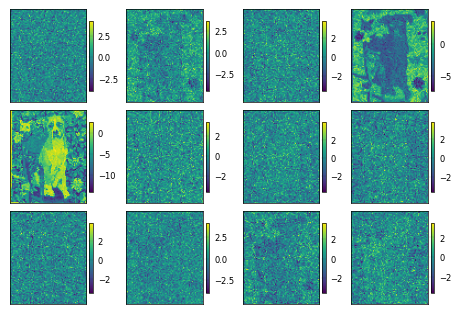

In [54]:
embeddings(encoded_spectra, shape_=image.shape[0:2], figsize=(4.5, 3.75))


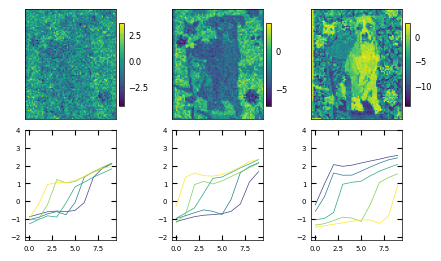

In [55]:
latent_generator(decoder, encoded_spectra, image, 5, 10,
                 device=device, figsize=(5, 2.5), divider_=False, indx=[1, 3, 4])
